In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Union, Optional
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import stats
import os
import datetime
import subprocess
from mech_dot_inp_gen import *
import jinja2
import copy

In [2]:
class OptimaOutput:
    def __init__(self, job_name: Union[str, Path],
                 optima_path: Optional[Union[str, Path]] = None):

        self.job_name = str(job_name)
        if optima_path == None:
            self.optima_path = Path("/home/nvme/Opt/outputs")
        self.job_folder = self.optima_path / job_name
        file_path = self.job_folder / "mechanismInfo.txt"
        try:
            with open(file_path, "r") as f:
                self.mech_info = f.read()
        except Exception as e:
            raise e

In [3]:
class OptimaMechtest(OptimaOutput):
    def __init__(self, job_name: Union[str, Path],
                 input_mech: str,
                 optima_path: Optional[Union[str, Path]] = None,
                 errf_type: Union[str, List[str]] = "default"):
        super().__init__(job_name, optima_path)

        self._errf_files = {
           "default": "errfValues",
           "data_series": "errfValues_by_data_series", 
           "points": "errfValues_by_points",
           "species": "errfValues_by_species"
            }

        if (self.job_folder / "debug").exists():
            self.all_data = {}
            for csv_data in (self.job_folder / "debug").glob("*.csv"):
                try:
                    self.all_data[csv_data.stem] = pd.read_csv(csv_data)
                except Exception as e:
                    print(e)
        print((self.job_folder / f"mechTestResults_{input_mech}.csv"))
        if (self.job_folder / f"mechTestResults_{input_mech}.csv").exists():
            print((self.job_folder / f"mechTestResults_{input_mech}.csv").exists())
            self.all_sheets_dP = pd.read_csv(self.job_folder / f"mechTestResults_{input_mech}.csv",  # dP as in the info in dataPoints
                                        header=None,
                                        delimiter=';',
                                        index_col=False,
                                        names=['xml', 'time_point', 'species', 'dP_val', 'sim_val'],
                                        )#low_memory=False)
            #print(self.all_sheets_dP)
            self.get_coarse_df(all_sheets_dP=self.all_sheets_dP)

        stac_eq_df = pd.concat({k: v.iloc[-1] for k, v in self.all_data.items()}, axis=1)                # makes a dict() with the
        #followed18 = pd.concat({k: v.iloc[-1] for k, v in self.orig_time_sim_df.items()}, axis=1)        # same keys, the values are
        self.df_basal = stac_eq_df.iloc[3:-1].T                                                          # the last elements i.e.,
        #self.df_followed18 = followed18.T                                                                # t = last time_point

    def __str__(self):
        if not self.df_basal.empty and not self.df_followed18.empty:
            return f"Mech object was successfully generated with fields\ndf_basal: {self.df_basal.shape}\ndf_followed18: {self.df_followed18.shape}"
        elif self.df_basal.empty and not self.df_followed18.empty:
            return "Unsuccessful, error with df_basal"
        elif not self.df_basal.empty and self.df_followed18.empty:
            return "Unsuccessful, error with df_followed18"
        else:
            return "Mech object was not successfully created"

    def get_coarse_df(self, all_sheets_dP):
        self.orig_time_sim_df = {}
        self.orig_time_exp_df = {}

        time_point = 0
        species = 'ilyen_species_tuti_nem_lesz'
        self.failed_sims_xmls = []

        for _, row in all_sheets_dP.iterrows():
            if row.xml in self.failed_sims_xmls:
                continue

            xml_name = row.xml
            sim_val = row.sim_val
            exp_val = row.dP_val

            if row.species == species:
                time_point += 1
            else:
                species = row.species
                time_point = 1

            if sim_val != 'FAILED':
                # ensure dict entries exist
                if xml_name not in self.orig_time_sim_df:
                    self.orig_time_sim_df[xml_name] = pd.DataFrame()
                if xml_name not in self.orig_time_exp_df:
                    self.orig_time_exp_df[xml_name] = pd.DataFrame()

                # ALWAYS assign (no else:)
                self.orig_time_sim_df[xml_name].loc[time_point, species] = float(sim_val)
                self.orig_time_exp_df[xml_name].loc[time_point, species] = exp_val
            else:
                self.failed_sims_xmls.append(xml_name)

        # make sure rows are in time order and numeric
        for xml, df in self.orig_time_sim_df.items():
            self.orig_time_sim_df[xml] = df.sort_index().apply(pd.to_numeric, errors='coerce')

        # build “followed18” as last valid values per species
        followed18 = pd.concat(
            {xml: df.ffill().iloc[-1]              # or: df.apply(lambda c: c.dropna().iloc[-1])
            for xml, df in self.orig_time_sim_df.items()},
            axis=1
        )
        self.df_followed18 = followed18.T


In [4]:
class Processing:
    def __init__(self, species_txt: str, ) -> None:
        self.species = self.get_species(species_txt)
        self.observables, self.not_observables = self.get_observables()

    def get_species(self, species_txt: str) -> list[str]:
        species = []
        with open(species_txt, 'r') as f:
            lines = f.readlines()
        for line in lines:
            for s in line.strip().split():
                species.append(s)
        print(len(species), species)
        return species

    def get_observables(self) -> tuple[list[str], list[str]]:
        dont_observe = []
        for s in self.species:
            if s == 'Q' or 'LKB1' in s or 'PP2A' in s or 'GLUT1' in s or 'RAP' in s or 'RK' in s or s in ['RHEB', 'PYRUVATE', 'AKT', 'TSCA']:
                dont_observe.append(s)
            elif s == 'FKBP12' or s == 'REF':
                dont_observe.append(s)
        observe = list(set(self.species) - set(dont_observe))
        print(len(observe), observe)
        return observe, dont_observe

In [5]:
class Model:
    def __init__(self, model_name: str, ics_df_path, # data_source: a pandas DataFrame
                 dont_observe: list[str], time_points: list[float],
                 time_course_vals: Union[dict[str, list[float]], float],
                 food: str, must_be_zero: list[str]=[], uncertainty=False,
                 inputs: dict[str, float]={'GLUCOUT': 6e-6}): # dict[stress_species: init_cc] = [rap extracell.: [mol/cm^3]]
        self.model_name = model_name
        self.ics_df = pd.read_csv(ics_df_path, sep=',')
        self.ics_df['minconc'] = self.ics_df['minconc'].astype(float)
        self.ics_df['maxconc'] = self.ics_df['maxconc'].astype(float)
        self.ics_df['value'] = self.ics_df['value'].astype(float)
        self.ics_df.species = [s.upper() for s in self.ics_df.species]
        self.species = self.ics_df['species'].to_list()
        self.output_species = list(set(self.species) - set(dont_observe))
        self.time_points = time_points
        if isinstance(time_course_vals, float):
            self.time_course_vals = self.gen_time_course_vals(time_course_vals)
        else:
            self.time_course_vals = time_course_vals
        self.food = food
        self.must_be_zero = must_be_zero
        self.uncertainty = uncertainty
        self.inputs = inputs

        self.ranges = self.get_bounds()
        print(f"range values stored in model.ranges of length {len(self.ranges.keys())}")
        self.get_sigmas()
        self.gen_exp_data()

    def get_bounds(self) -> dict[str, tuple[float, float]]:
        bounds = dict()
        for _, row in self.ics_df.iterrows():
            if 'REF' not in row.species and row.species not in self.must_be_zero:
                if row.value < 1e-13:
                    lb = 1e-14
                    ub = 1e-13
                elif row.minconc == row.maxconc:
                    lb = row.minconc
                    ub = row.maxconc
                else:
                    if row.value/2 >= row.minconc:
                        lb = (row.value/2)
                    else:
                        lb = row.minconc
                    if row.value*1.5 <= row.maxconc:
                        ub = (row.value*1.5)
                    else:
                        ub = row.maxconc
            bounds[row.species.upper()] = [lb, ub]
        return bounds

    def get_sigmas(self):
        self.sigmas = dict()
        for key, value in self.ranges.items():
            if self.uncertainty:
                if key in self.must_be_zero: # this line might be unnecessary, as I think we need sigma only if the species is an output
                    self.sigmas[key] = 5e-18
                elif key in self.output_species:
                    if value[1] > value[0]:
                        self.sigmas[key] = ((value[1]-value[0])/8)
                    else:
                        self.sigmas[key] = 5e-13
            else:
                self.sigmas[key] = 2.5e-11

    def gen_time_course_vals(self, time_course_vals):
        species_time_course = {}
        for s in self.species:
            species_time_course[s] = np.ones(len(self.time_points)) * time_course_vals
        return species_time_course

    def gen_exp_data(self):
        self.exp_data = pd.DataFrame()
        self.exp_data['time'] = self.time_points
        for s in self.output_species:
            self.exp_data[s] = self.ics_df[self.ics_df['species'] == s].iloc[0, 2] # "exp_data" = value of the csv column

In [6]:
class Genesis:
    def __init__(self, model: Model, max_digit = 4):
        self.model = model
        self.maxdigit = max_digit

    def create_xml_files(self, output_xmls_path: str, num_of_xmls: int,
                         xml_template_path: str, prefix: str='', kiir=True) -> None:
        if not os.path.exists(output_xmls_path):
            os.makedirs(output_xmls_path)
        self.num_xmls = num_of_xmls
        self.output_dir = output_xmls_path
        env = jinja2.Environment(loader=jinja2.FileSystemLoader(os.path.dirname(xml_template_path)))
        self.template = env.get_template(os.path.basename(xml_template_path))

        if kiir:
            for i in range(1, num_of_xmls+1):
                np.random.seed(i+1)
                self.random_ics = self.get_random_ics()
                self.make_xml_output(i, output_xmls_path, prefix)

    def get_random_ics(self) -> dict[str, float]:
        random_ics = {}
        if self.model.uncertainty:
            for key in self.model.species:
                if key not in self.model.must_be_zero:
                    random_ics[key] = np.random.uniform(*self.model.ranges[key])
                else:
                    random_ics[key] = 0
        else:
           random_ics = dict(zip(self.model.ics_df['species'], self.model.ics_df['value']))
        for key in self.model.inputs.keys():
            random_ics[key] = self.model.inputs[key]
        random_ics["REF"] = 1.0
        if self.model.food == 'stac':
            random_ics['Q'] = 6e-6
        return random_ics

    def make_xml_output(self, file_index: int, output_xmls_path: str, prefix) -> None:
        dataPoints = [self.compileDataRow(row.values) for _, row in self.model.exp_data.iterrows()]
        output = self.template.render(ics=self.random_ics, relsigmas=self.model.sigmas,
                                      variables=self.model.output_species, dataPoints=dataPoints)
        padded_number = str(file_index).zfill(self.maxdigit)
        filename = f"{prefix}_{padded_number}.xml"
        with open(os.path.join(output_xmls_path, filename), 'w') as f:
            f.write(output)

    def compileDataRow(self, dataPoints):
        meas = "".join(f"<{v}>{{:.4e}}</{v}>" for v in self.model.exp_data.columns)
        return f"<dataPoint>{meas.format(*dataPoints)}</dataPoint>"

In [7]:
class Simulation:
    def __init__(self, gen: Genesis, xmls_in_one_opp: int) -> None:
      self.gen = gen
      self.get_xml_vec(xmls_in_one_opp)

    def get_xml_vec(self, xmls_in_one_opp) -> None:
      self.xmls = []
      for i in range(1, self.gen.num_xmls, xmls_in_one_opp):
          xml_cnt = np.arange(i, i+xmls_in_one_opp, 1) 
          self.xmls.append(xml_cnt)

    def opp_gen(self, opp_output_dir, opp_name_prefix, kiir, mech_file, food) -> None:
      self.opps = []
      self.indices = []
      self.food = food
      self.mech_file = mech_file
      self.mech_inp_name = self.mech_file.split('/')[-1].split('.inp')[0]
      for num in self.xmls:
          opp_filename = f"{opp_name_prefix}_{num[-1]}.opp"
          self.opps.append(opp_filename)
          self.indices.append(f"{num[-1]}")
          if kiir:
            opp_content = self.generate_opp_content(xml_folder=self.gen.output_dir,
                                                    num_xmls=num,
                                                    mech_file=mech_file,
                                                    name=self.food)
            with open(os.path.join(opp_output_dir, opp_filename), "w") as f:
              f.write(opp_content)

    def generate_opp_content(self, xml_folder: str, num_xmls: Union[list[int], list[list[int]]],
                             mech_file: str, name: str, time_limit: int = 50, thread_limit: int = 32,
                             settings_tag: str = "systems_biology", solver: str = "cantera") -> str:
      mech_name = mech_file.split('/')[-1].split('.inp')[0]
      yaml = mech_file.split('.inp')[0]

      # Create MECHMOD section
      mechmod = f"""MECHMOD
      USE_NAME         {mech_name}
      MECH_FILE        {mech_file}
      COMPILE_{solver} {yaml}.yaml
      END
      """

      # Create MECHTEST section
      mechtest = f"""MECHTEST
      MECHANISM  {mech_name}
      TIME_LIMIT {time_limit}
      THREAD_LIMIT {thread_limit}
      SETTINGS_TAG {settings_tag}
      FALLBACK_TO_DEFAULT_SETTINGS
      PLOTS FALSE

      SOLVER {solver}
      SAVE_STATES      CSV
      """

      # Add each XML file name
      for xml in num_xmls:
          padded_number = str(xml).zfill(self.gen.maxdigit)
          mechtest += f"      NAME {xml_folder}/{name}_{padded_number}.xml\n"

      mechtest += "END\n"

      return mechmod + "\n" + mechtest

    def sim_runner(self, log_location:str = ''):
      self.parent_path = Path.cwd().parents[2]

      if log_location == '':
        for idx, opp_file in enumerate(self.opps):
            command = ["bin/Release/OptimaPP", f"7_Krisztian/1_mechtest/{opp_file}"]
            print(f"Running: {' '.join(command)}")
            subprocess.run(command, check=True, cwd=self.parent_path)
      else:
        for idx, opp_file in enumerate(self.opps):
          command = ["bin/Release/OptimaPP", f"7_Krisztian/1_mechtest/{opp_file}"]
          print(f"Running: {' '.join(command)}")
          log_idx = self.xmls[idx][-1]
          with open(f"{log_location}/run_log_stac_starve_rap{log_idx}.txt", "w") as log:
              subprocess.run(command, check=True, stdout=log, stderr=subprocess.STDOUT, cwd=self.parent_path)

In [8]:
class Natural_Selection:
    def __init__(self, sim: Simulation) -> None:
        self.sim = sim
        self.sim_data: dict[str, OptimaMechtest] = {}
        self.get_sim_data()
        #self.survival_of_the_fittest()

    def get_sim_data(self) -> None:
        for idx, key in enumerate(self.sim.indices):
            self.sim_data[key] = OptimaMechtest(job_name=self.sim.opps[idx],
                                                input_mech=self.sim.mech_inp_name)

    def sigma_range(self, meas, sim, sigma):
        radius = (sim-meas)/sigma
        return radius
    
    def isit_init(self, row):
        lut = self.sim.gen.model.ics_df
        rel_sigmas = self.sim.gen.model.sigmas
        for k, v in row.items():
            if k in self.condition_vars:
                right_row = lut[lut['species'] == k]

                meas = right_row['value'].iloc[0]

                radius = self.sigma_range(meas=meas, sim=v, sigma=rel_sigmas[k])

                if radius >= 4:
                    self.wrongdoers[k] += 1
                    return False

        return True
    
    def survival_of_the_fittest(self) -> None:
        self.good_xmls = []
        self.get_condition_vars()
        self.wrongdoers = {k: 0 for k in self.condition_vars}
        for idx in self.sim.indices:
            for xml_name, row in self.sim_data[idx].df_followed18.iterrows():
                all_ok = self.isit_init(row)
                if all_ok:
                    self.good_xmls.append(xml_name)
        print(f"Found {len(self.good_xmls)} good xmls")

    def get_condition_vars(self) -> None:
        self.condition_vars = ['RHEBA', 'AKTA', 'TSC', 'MTORA', 'ATP', 'ULK', 'GLUCIN']
# too big LKB1 activity could mean upregged AMPK biologically speaking
# ADP, AMP make complexes just like ATP, but for AMP/ADP the complex concentrations are comparable to the
# cc. of either ADP or AMP --> complex-bound ADP/AMP would throw the calculation off
# LKB1 and PP2A form complexes with the AMPKs --> their cc. should change --> not adequate conditions
    def filtering(self) -> None:
        data = copy.deepcopy(self.sim_data)
        first = True
        self.filtered_basal = pd.DataFrame()
        self.filtered_followed = pd.DataFrame()
        for k, v in data.items():
            v.df_basal.index = v.df_basal.index.str[7:-9]
            v.df_basal = v.df_basal.sort_index()
            if first:
                self.filtered_basal = v.df_basal[[xml in self.good_xmls for xml in v.df_basal.index]]
                self.filtered_followed = v.df_followed18[[xml in self.good_xmls for xml in v.df_followed18.index]]
                first = False
            else:
                self.filtered_basal = pd.concat([self.filtered_basal, v.df_basal[[xml in self.good_xmls for xml in v.df_basal.index]]],
                                        ignore_index=False)
                self.filtered_followed = pd.concat([self.filtered_followed, v.df_followed18[[xml in self.good_xmls for xml in v.df_followed18.index]]],
                                            ignore_index=False)

    def get_cov_cor(self, corr_xmls, keys: list[str]) -> None:
        self.dict_b = {}
        self.dict_f = {}
        self.dict_b_corr = {}
        self.dict_f_corr = {}
        self.dict_b_cov = {}
        self.dict_f_cov = {}
        for idx, alma in enumerate(corr_xmls):
            self.dict_f[f"{keys[idx]}"] = self.filtered_followed.iloc[alma].copy()
            #self.dict_b[f"{keys[idx]}"] = self.filtered_basal.iloc[alma].copy()
            #self.dict_b_corr[f"{keys[idx]}"] = self.filtered_basal.iloc[alma].copy().corr()
            self.dict_f_corr[f"{keys[idx]}"] = self.filtered_followed.iloc[alma].copy().corr()
            self.dict_f_cov[f"{keys[idx]}"] = self.filtered_followed.iloc[alma].copy().cov()
            #self.dict_b_cov[f"{keys[idx]}"] = self.filtered_basal.iloc[alma].copy().cov()

In [9]:
def plot_correlation_distance_heatmap(dict, corr_xmls, title: str, method='fro',
                                      save_fig=False, nat_select:Natural_Selection=None):
    num_corrs = len(corr_xmls)
    distance_matrix = np.zeros((num_corrs, num_corrs))

    for i, n1 in enumerate(corr_xmls):
        for j, n2 in enumerate(corr_xmls):
            mat1 = dict[str(n1)].values
            mat2 = dict[str(n2)].values
            if method == 'kl':
                mu1 = nat_select.dict_f[str(n1)].mean()
                mu2 = nat_select.dict_f[str(n2)].mean()
                distance_matrix[i, j] = compute_matrix_distance(mat1, mat2, method=method, mu1=mu1, mu2=mu2)
            else:
                distance_matrix[i, j] = compute_matrix_distance(mat1, mat2, method=method)
    plot_it(distance_matrix, corr_xmls, corr_xmls, method, save_fig, title)

def plot_dual_metric_heatmap(dict, keys,
                              method_lower='cmd', method_upper='frobenius',
                              title='Dual Distance Plot',
                              cmap_lower='Blues', cmap_upper='Reds',
                              save_fig=False,
                              nat_select_dict: dict[str, pd.DataFrame] = None):
    n = len(keys)
    data_lower = np.zeros((n, n))
    data_upper = np.zeros((n, n))

    # Compute both metrics for all pairs
    for i, n1 in enumerate(keys):
        for j, n2 in enumerate(keys):
            mat1 = dict[str(n1)]
            mat2 = dict[str(n2)]
            if method_lower == 'kl' or method_upper == 'kl':
                mu1 = nat_select_dict[str(n1)].mean()
                mu2 = nat_select_dict[str(n2)].mean()
            if i >= j:
                data_lower[i, j] = compute_matrix_distance(mat1, mat2, method_lower, mu1=mu1, mu2=mu2)
            elif i < j:
                data_upper[i, j] = compute_matrix_distance(mat1, mat2, method_upper, mu1=mu1, mu2=mu2)

    # Create masks
    mask_lower = np.triu(np.ones_like(data_lower, dtype=bool), k=1)
    mask_upper = np.tril(np.ones_like(data_upper, dtype=bool), k=0)

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot lower triangle
    norm_lower = Normalize(vmin=np.min(data_lower[np.tril_indices(n, -1)]),
                           vmax=np.max(data_lower[np.tril_indices(n, -1)]))
    sns.heatmap(data_lower,
                mask=mask_lower,
                cmap=cmap_lower,
                annot=True,
                square=True,
                linewidths=0.5,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax)

    plt.xlabel('Number of XMLs')
    plt.ylabel('Number of XMLs')

    # Plot upper triangle
    norm_upper = Normalize(vmin=np.min(data_upper[np.triu_indices(n, 1)]),
                           vmax=np.max(data_upper[np.triu_indices(n, 1)]))
    sns.heatmap(data_upper,
                mask=mask_upper,
                cmap=cmap_upper,
                annot=True,
                square=True,
                linewidths=0.5,
                cbar=False,
                xticklabels=keys,
                yticklabels=keys,
                ax=ax)

    ax.set_xticklabels(keys, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(keys, rotation=0, fontsize=9)
    ax.set_title(title, fontsize=14, pad=12)

    # Add both colorbars
    cbar_ax1 = fig.add_axes([0.84, 0.25, 0.02, 0.5])  # Right colorbar
    sm1 = cm.ScalarMappable(cmap=cmap_upper, norm=norm_upper)
    sm1.set_array([])
    cbar1 = fig.colorbar(sm1, cax=cbar_ax1)
    cbar1.set_label(f'{method_upper.upper()} (upper)', rotation=270, labelpad=15)

    cbar_ax2 = fig.add_axes([0.0, 0.25, 0.02, 0.5])  # Left colorbar
    sm2 = cm.ScalarMappable(cmap=cmap_lower, norm=norm_lower)
    sm2.set_array([])
    cbar2 = fig.colorbar(sm2, cax=cbar_ax2)
    cbar2.set_label(f'{method_lower.upper()} (lower)', rotation=90, labelpad=15)

    #fig.patch.set_facecolor('#f8f6f6')
    #plt.tight_layout(rect=[0.1, 0, 0.9, 1])

    if save_fig:
        plt.savefig(f"pics/{title.replace(' ', '_')}.png", dpi=300)
        plt.savefig(f"pics/{title.replace(' ', '_')}.pdf")

    plt.show()

def plot_correlation_distance_heatmap_leodit(dict, corr_xmls, title: str, method='frobenius',
                                      save_fig=False, nat_select:Natural_Selection=None):
    num_corrs = len(corr_xmls)
    distance_matrix = np.zeros((num_corrs, num_corrs))

    for i, n1 in enumerate(corr_xmls):
        for j, n2 in enumerate(corr_xmls):
            mat1 = dict[str(n1)]
            mat2 = dict[str(n2)]
            if method == 'kl':
                mu1 = nat_select.dict_b[str(n1)].mean()
                mu2 = nat_select.dict_b[str(n2)].mean()
                distance_matrix[i, j] = compute_matrix_distance(mat1, mat2, method=method, mu1=mu1, mu2=mu2)
            else:
                distance_matrix[i, j] = compute_matrix_distance(mat1, mat2, method=method)
    plot_it(distance_matrix, corr_xmls, corr_xmls, method, save_fig, title)

In [24]:
from typing import Dict, Iterable, Optional, Tuple

def _normalize_species(species):
    if isinstance(species, str):
        return (species,)
    return tuple(species)

def _stack_runs(df_dict, species, n_expected=None):
    species = _normalize_species(species)
    max_idx = max(df.index.max() for df in df_dict.values())
    if n_expected is not None:
        max_idx = max(max_idx, n_expected)
    idx = pd.RangeIndex(1, max_idx + 1)

    mats = []
    for _, df in df_dict.items():
        tmp = (df.sort_index()
                 .reindex(idx)
                 .apply(pd.to_numeric, errors='coerce')
                 .ffill().bfill())
        if set(species).issubset(tmp.columns):
            mats.append(tmp.loc[:, list(species)].to_numpy())
    if not mats:
        raise ValueError(f"No runs contained the requested species: {species}")
    return idx, np.stack(mats, axis=0)

def _summary(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    q10 = np.quantile(X, 0.10, axis=0)
    q25 = np.quantile(X, 0.25, axis=0)
    med = np.quantile(X, 0.50, axis=0)
    q75 = np.quantile(X, 0.75, axis=0)
    q90 = np.quantile(X, 0.90, axis=0)
    mean = X.mean(axis=0)
    return q10, q25, med, q75, q90, mean

def _spread(y_values, min_gap):
    """
    Given a list of y positions, return adjusted positions so that
    consecutive labels are at least `min_gap` apart (in data units),
    while preserving ordering as much as possible.
    """
    y = np.array(y_values, dtype=float)
    order = np.argsort(y)
    y_sorted = y[order]

    adj = np.empty_like(y_sorted)
    prev = -np.inf
    for i, val in enumerate(y_sorted):
        if val <= prev + min_gap:
            adj[i] = prev + min_gap
        else:
            adj[i] = val
        prev = adj[i]

    result = np.empty_like(adj)
    result[order] = adj
    return result

def plot_compare_summary_gluc(
    df_dict_a: Dict[str, pd.DataFrame],
    df_dict_b: Dict[str, pd.DataFrame],
    label_a: str = 'cond A',
    label_b: str = 'cond B',
    species=('ATP','ADP','AMP'),
    dt_minutes=30,
    total_hours=84,
    show_iqr: bool = True,
    show_p80: bool = False,
    show_mean: bool = True,
    show_median: bool = False,
    sample_trajs: int = 0,
    traj_alpha: float = 0.10,
    band_alpha_iqr: float = 0.20,
    band_alpha_p80: float = 0.10,
    legend_pos: str = "below",
    show_axp: bool = True,
    y_label = r'concentration $[\frac{mol}{cm^{3}}]$',
    figsize=(12, 8),
    curve_labels=False
):

    species = _normalize_species(species)
    n_expected = int(total_hours*60/dt_minutes + 1)

    idx_a, Xa = _stack_runs(df_dict_a, species, n_expected)
    idx_b, Xb = _stack_runs(df_dict_b, species, n_expected)
    t_h_a = (idx_a.values - 1) * dt_minutes / 60.0
    t_h_b = (idx_b.values - 1) * dt_minutes / 60.0

    qa10, qa25, qamed, qa75, qa90, qamean = _summary(Xa)
    qb10, qb25, qbmed, qb75, qb90, qbmean = _summary(Xb)

    fig, axes = plt.subplots(1, len(species), figsize=figsize, sharex=True)
    if len(species) == 1:
        axes = [axes]

    rng = np.random.default_rng(0)
    samp_a = rng.choice(Xa.shape[0], size=min(sample_trajs, Xa.shape[0]),
                        replace=False) if sample_trajs else []
    samp_b = rng.choice(Xb.shape[0], size=min(sample_trajs, Xb.shape[0]),
                        replace=False) if sample_trajs else []

    for si, sp in enumerate(species):
        ax = axes[si]

        for ridx in samp_a:
            ax.plot(t_h_a, Xa[ridx, :, si], lw=0.6, alpha=traj_alpha)
        for ridx in samp_b:
            ax.plot(t_h_b, Xb[ridx, :, si], lw=0.6, alpha=traj_alpha)

        if show_p80:
            ax.fill_between(t_h_a, qa10[:, si], qa90[:, si],
                            alpha=band_alpha_p80, linewidth=0, label=f'{label_a} 10–90%')
        if show_iqr:
            ax.fill_between(t_h_a, qa25[:, si], qa75[:, si],
                            alpha=band_alpha_iqr, linewidth=0, label=f'{label_a} IQR')

        if show_p80:
            ax.fill_between(t_h_b, qb10[:, si], qb90[:, si],
                            alpha=band_alpha_p80, linewidth=0, label=f'{label_b} 10–90%')
        if show_iqr:
            ax.fill_between(t_h_b, qb25[:, si], qb75[:, si],
                            alpha=band_alpha_iqr, linewidth=0, label=f'{label_b} IQR')

        if curve_labels:
            y0_a = qamean[0, si]
            y0_b = qbmean[0, si]
            ax.text(-2.5, y0_a, f"{label_a}", color='tab:blue', va='center', ha='right',
                    fontsize=12, weight='bold')
            ax.text(-2.5, y0_b, f"{label_b}", color='tab:orange', va='center', ha='right',
                    fontsize=12, weight='bold')

        if show_mean:
            ax.plot(t_h_a, qamean[:, si], lw=2, label=f'{label_a} mean')
            ax.plot(t_h_b, qbmean[:, si], lw=2, label=f'{label_b} mean')
        if show_median:
            ax.plot(t_h_a, qamed[:, si], lw=1, linestyle='--', label=f'{label_a} median')
            ax.plot(t_h_b, qbmed[:, si], lw=1, linestyle='--', label=f'{label_b} median')

        ax.set_title("Extracellular Glucose Concentrations - Simulations and Measurements",
                     fontsize=19)
        ax.set_xlim(-0.2, total_hours)
        ax.set_xticks(np.arange(0, total_hours+0.1, 6))
        if si == 0:
            ax.set_ylabel(y_label, fontsize=18)
        ax.set_xlabel('time [h]', fontsize=15)
        ax.grid(alpha=0.2, linestyle=':')

        # ------- EXP DATA + SQUARED ERROR QUANTIFICATION (GLUCOUT only) -------
        if sp == 'GLUCOUT' and (label_a == 'Starved' or label_b == 'Starved'):
            # experimental data
            ax.errorbar(
                sejeong_gluc.t,
                sejeong_gluc.y,
                yerr=sejeong_gluc.sigma,
                fmt='x',
                capsize=5,
                lw=1.8,
                markersize=5,
                color='tab:red',
                ecolor='tab:red',
                elinewidth=2,
                alpha=0.9,
                label='Experimental Data'
            )

            # squared errors between experimental data and sim mean (cond A)
            mean_sim = qamean[:, si]                            # mean curve for GLUCOUT
            sim_at_meas = np.interp(sejeong_gluc.t, t_h_a, mean_sim)
            sq_errors = (sim_at_meas - sejeong_gluc.y) ** 2
            sse = sq_errors.sum()
            mse = sq_errors.mean()
            rmse = np.sqrt(mse)

            # print to console (optional)
            print(f"[GLUCOUT] SSE = {sse:.4e}, RMSE = {rmse:.4e}")

            # show on the plot
            ax.text(
                0.98, 0.82,
                r"$\sum (y_{\mathrm{sim}}-y_{\mathrm{exp}})^2$"
                + f" = {sse:.2e}\nRMSE = {rmse:.2e}",
                transform=ax.transAxes,
                ha='right', va='bottom',
                fontsize=20,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7)
            )
        # ----------------------------------------------------------------------

    if show_axp and set(species) == {'ATP','ADP','AMP'}:
        axes[0].plot(t_h_a, qamean.sum(axis=1), lw=1.2, linestyle=':',
                     label=f'AXP mean – {label_a}')
        axes[0].plot(t_h_b, qbmean.sum(axis=1), lw=1.2, linestyle=':',
                     label=f'AXP mean – {label_b}')

    handles, labels = axes[0].get_legend_handles_labels()
    if legend_pos == "below":
        fig.legend(handles, labels, frameon=False, loc='lower center',
                   bbox_to_anchor=(0.5, -0.01), ncol=6, fontsize=15)
        fig.tight_layout(rect=[0, 0.06, 1, 1])
    elif legend_pos == "above":
        fig.legend(handles, labels, frameon=False, loc='upper center',
                   bbox_to_anchor=(0.5, 1.15), ncol=6, fontsize=15)
        fig.tight_layout(rect=[0, 0, 1, 0.94])
    else:
        axes[-1].legend(handles, labels, frameon=False, loc='upper right')
        fig.tight_layout()

    fig.patch.set_facecolor('white')
    return fig

In [11]:
from typing import Dict, Iterable, Optional, Tuple

def _normalize_species(species):
    if isinstance(species, str):
        return (species,)
    return tuple(species)

def _stack_runs(df_dict, species, n_expected=None):
    species = _normalize_species(species)
    max_idx = max(df.index.max() for df in df_dict.values())
    if n_expected is not None:
        max_idx = max(max_idx, n_expected)
    idx = pd.RangeIndex(1, max_idx + 1)

    mats = []
    for _, df in df_dict.items():
        tmp = (df.sort_index()
                 .reindex(idx)
                 .apply(pd.to_numeric, errors='coerce')
                 .ffill().bfill())
        if set(species).issubset(tmp.columns):
            mats.append(tmp.loc[:, list(species)].to_numpy())
    if not mats:
        raise ValueError(f"No runs contained the requested species: {species}")
    return idx, np.stack(mats, axis=0)

def _summary(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    q10 = np.quantile(X, 0.10, axis=0)
    q25 = np.quantile(X, 0.25, axis=0)
    med  = np.quantile(X, 0.50, axis=0)
    q75 = np.quantile(X, 0.75, axis=0)
    q90 = np.quantile(X, 0.90, axis=0)
    mean = X.mean(axis=0)
    return q10, q25, med, q75, q90, mean

def _spread(y_values, min_gap):
    """
    Given a list of y positions, return adjusted positions so that
    consecutive labels are at least `min_gap` apart (in data units),
    while preserving ordering as much as possible.
    """
    y = np.array(y_values, dtype=float)
    order = np.argsort(y)
    y_sorted = y[order]

    adj = np.empty_like(y_sorted)
    prev = -np.inf
    for i, val in enumerate(y_sorted):
        if val <= prev + min_gap:
            adj[i] = prev + min_gap
        else:
            adj[i] = val
        prev = adj[i]

    result = np.empty_like(adj)
    result[order] = adj
    return result

def plot_compare_summary(
    df_dict_a: Dict[str, pd.DataFrame],
    df_dict_b: Dict[str, pd.DataFrame],
    label_a: str = 'cond A',
    label_b: str = 'cond B',
    species=('ATP','ADP','AMP'),
    dt_minutes=30,
    total_hours=84,
    # ---- layout switch ----
    layout_mode: str = "species",   # "species" | "condition"
    # ---- stat controls ----
    show_iqr: bool = True,
    show_p80: bool = False,
    show_mean: bool = True,
    show_median: bool = False,
    sample_trajs: int = 0,          # 0 -> no thin trajectories
    traj_alpha: float = 0.10,
    band_alpha_iqr: float = 0.20,
    band_alpha_p80: float = 0.10,
    legend_pos: str = "below",      # "below" | "above" | "inside"
    # -----------------------
    show_axp: bool = True,          # only used if plotting the AXP trio
    figsize=(12, 8),
    curve_labels: bool = False,
    curve_label_min_gap_frac: float = 0.02,
    curve_label_xpad: float = -3.0,
    curve_label_connectors: bool = True,
    # ---- NEW: separate figures per species ----
    multi_fig: bool = False,
):
    """
    Compare conditions A vs B for the given species.

    layout_mode = "species":
        One subplot per species. Each subplot shows both conditions.

    layout_mode = "condition":
        Two subplots (A, B). Each subplot shows all species for that condition.

    multi_fig = True:
        Instead of one figure for all species, return a *list of figures*,
        one figure per species, using the chosen layout_mode.
    """
    if layout_mode not in {"species", "condition"}:
        raise ValueError('layout_mode must be "species" or "condition".')

    species = _normalize_species(species)

    # --- NEW: create one fig per species if requested -------------------
    if multi_fig and len(species) > 1:
        figs = []
        for sp in species:
            figs.append(
                plot_compare_summary(
                    df_dict_a=df_dict_a,
                    df_dict_b=df_dict_b,
                    label_a=label_a,
                    label_b=label_b,
                    species=(sp,),
                    dt_minutes=dt_minutes,
                    total_hours=total_hours,
                    layout_mode=layout_mode,
                    show_iqr=show_iqr,
                    show_p80=show_p80,
                    show_mean=show_mean,
                    show_median=show_median,
                    sample_trajs=sample_trajs,
                    traj_alpha=traj_alpha,
                    band_alpha_iqr=band_alpha_iqr,
                    band_alpha_p80=band_alpha_p80,
                    legend_pos=legend_pos,
                    show_axp=show_axp,
                    figsize=figsize,
                    curve_labels=curve_labels,
                    curve_label_min_gap_frac=curve_label_min_gap_frac,
                    curve_label_xpad=curve_label_xpad,
                    curve_label_connectors=curve_label_connectors,
                    multi_fig=False,      # avoid infinite recursion
                )
            )
        return figs
    # --------------------------------------------------------------------

    n_expected = int(total_hours*60/dt_minutes + 1)

    # stack & summarize
    idx_a, Xa = _stack_runs(df_dict_a, species, n_expected)  # [runs, time, species]
    idx_b, Xb = _stack_runs(df_dict_b, species, n_expected)
    t_h_a = (idx_a.values - 1) * dt_minutes / 60.0
    t_h_b = (idx_b.values - 1) * dt_minutes / 60.0

    qa10, qa25, qamed, qa75, qa90, qamean = _summary(Xa)
    qb10, qb25, qbmed, qb75, qb90, qbmean = _summary(Xb)

    rng = np.random.default_rng(0)
    samp_a = rng.choice(Xa.shape[0], size=min(sample_trajs, Xa.shape[0]), replace=False) if sample_trajs else []
    samp_b = rng.choice(Xb.shape[0], size=min(sample_trajs, Xb.shape[0]), replace=False) if sample_trajs else []

    legend_data = {label_a: {}, label_b: {}}

    # ---------------- LAYOUT 1: one subplot per species ----------------
    if layout_mode == "species":
        fig, axes = plt.subplots(1, len(species), figsize=figsize, sharex=True)
        if len(species) == 1:
            axes = [axes]

        for si, sp in enumerate(species):
            ax = axes[si]

            for ridx in samp_a:
                ax.plot(t_h_a, Xa[ridx, :, si], lw=0.6, alpha=traj_alpha)
            for ridx in samp_b:
                ax.plot(t_h_b, Xb[ridx, :, si], lw=0.6, alpha=traj_alpha)

            if show_p80:
                ax.fill_between(t_h_a, qa10[:, si], qa90[:, si],
                                alpha=band_alpha_p80, linewidth=0, label=f'{label_a} 10–90%')
            if show_iqr:
                ax.fill_between(t_h_a, qa25[:, si], qa75[:, si],
                                alpha=band_alpha_iqr, linewidth=0, label=f'{label_a} IQR')

            if show_p80:
                ax.fill_between(t_h_b, qb10[:, si], qb90[:, si],
                                alpha=band_alpha_p80, linewidth=0, label=f'{label_b} 10–90%')
            if show_iqr:
                ax.fill_between(t_h_b, qb25[:, si], qb75[:, si],
                                alpha=band_alpha_iqr, linewidth=0, label=f'{label_b} IQR')

            if curve_labels:
                y0_a = qamean[0, si]
                y0_b = qbmean[0, si]
                ax.text(-2.5, y0_a, f"{label_a}", color='tab:blue',
                        va='center', ha='right', fontsize=12, weight='bold')
                ax.text(-2.5, y0_b, f"{label_b}", color='tab:orange',
                        va='center', ha='right', fontsize=12, weight='bold')

            if show_mean:
                ax.plot(t_h_a, qamean[:, si], lw=2, label=f'{label_a} mean')
                ax.plot(t_h_b, qbmean[:, si], lw=2, label=f'{label_b} mean')
            if show_median:
                ax.plot(t_h_a, qamed[:, si], lw=1, linestyle='--', label=f'{label_a} median')
                ax.plot(t_h_b, qbmed[:, si], lw=1, linestyle='--', label=f'{label_b} median')

            ax.set_title(f"Time Profile of {sp} Dynamics for N = {Xa.shape[0]} Simulations", fontsize=20)
            ax.set_xlim(0, total_hours)
            ax.set_xticks(np.arange(0, total_hours+0.1, 6))
            if si == 0:
                ax.set_ylabel(r'concentration $[\frac{mol}{cm^{3}}]$', fontsize=15)
            ax.set_xlabel('time [h]', fontsize=12)
            ax.grid(alpha=0.2, linestyle=':')

            if sp == 'GLUCOUT' and (label_a == 'Starved' or label_b == 'Starved'):
                ax.errorbar(
                    sejeong_gluc.t,
                    sejeong_gluc.y,
                    yerr=sejeong_gluc.sigma,
                    fmt='x',
                    capsize=5,
                    lw=1.8,
                    markersize=5,
                    color='tab:red',
                    ecolor='tab:red',
                    elinewidth=2,
                    alpha=0.9
                )

    # ---------------- LAYOUT 2: one subplot per condition ----------------
    else: # stac vs starve
        fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)

        def _plot_condition_panel(ax, t_h, X, q10, q25, qmed, q75, q90, qmean,
                                  samp_idx, cond_label, bucket):
            first_for_stat = True
            sp_colors = {}

            for si, sp in enumerate(species):
                for ridx in samp_idx:
                    ax.plot(t_h, X[ridx, :, si], lw=0.6, alpha=traj_alpha, label='_nolegend_')

                if show_p80:
                    band = ax.fill_between(
                        t_h, q10[:, si], q90[:, si],
                        alpha=band_alpha_p80, linewidth=0
                    )
                    if first_for_stat:
                        bucket[('P80', None)] = band
                if show_iqr:
                    band = ax.fill_between(
                        t_h, q25[:, si], q75[:, si],
                        alpha=band_alpha_iqr, linewidth=0
                    )
                    if first_for_stat:
                        bucket[('IQR', None)] = band

                if show_mean:
                    line = ax.plot(t_h, qmean[:, si], lw=2)[0]
                    sp_colors[sp] = line.get_color()
                    bucket[('mean', sp)] = line
                if show_median:
                    line = ax.plot(t_h, qmed[:, si], lw=1, linestyle='--')[0]
                    bucket[('median', sp)] = line

                first_for_stat = False

            if cond_label == 'Starved':
                ax.set_title(f"Starvation AXP Dynamics for N = {X.shape[0]} simulations", fontsize=15)
            else:
                ax.set_title(f"Basal State AXP Dynamics for N = {X.shape[0]} simulations", fontsize=15)
            ax.set_xlim(0, total_hours)
            ax.set_xticks(np.arange(0, total_hours+0.1, 6))
            ax.set_xlabel('time [h]', fontsize=12)
            ax.grid(alpha=0.2, linestyle=':')

            # left species labels
            if curve_labels and show_mean:
                y0s = [qmean[0, si] for si in range(len(species))]
                y_min, y_max = ax.get_ylim()
                y_range = max(1e-12, (y_max - y_min))
                y_labs = _spread(y0s, curve_label_min_gap_frac * y_range)

                x_min, x_max = ax.get_xlim()
                ax.set_xlim(0, x_max)

                for sp, y_lab, y_true in zip(species, y_labs, y0s):
                    col = sp_colors.get(sp, 'black')
                    ax.text(curve_label_xpad, y_lab, sp,
                            color=col, va='center', ha='right',
                            fontsize=12, weight='bold')
                    if curve_label_connectors:
                        ax.plot([curve_label_xpad + 0.2, 0],
                                [y_lab, y_true],
                                lw=2.0, alpha=0.6, color=col,
                                label='_nolegend_',
                                clip_on=False)

        _plot_condition_panel(axes[0], t_h_a, Xa, qa10, qa25, qamed, qa75, qa90, qamean,
                              samp_a, label_a, legend_data[label_a])
        _plot_condition_panel(axes[1], t_h_b, Xb, qb10, qb25, qbmed, qb75, qb90, qbmean,
                              samp_b, label_b, legend_data[label_b])

        axes[0].set_ylabel(r'concentration $[\frac{mol}{cm^{3}}]$', fontsize=15)

        # --- NEW: force y-ticks/labels on the right subplot as well -----
        axes[1].tick_params(labelleft=True)
        # ----------------------------------------------------------------

        if show_axp and set(species) == {'ATP','ADP','AMP'}:
            line_a = axes[0].plot(t_h_a, qamean.sum(axis=1), lw=1.2, linestyle=':')[0]
            line_b = axes[1].plot(t_h_b, qbmean.sum(axis=1), lw=1.2, linestyle=':')[0]
            legend_data[label_a][('AXP_mean', None)] = line_a
            legend_data[label_b][('AXP_mean', None)] = line_b

    # -------- legend placement (same as your last version) -------------
    if layout_mode == "condition" and legend_pos in {"below", "above"}:
        cols = []
        if show_iqr:
            cols.append(('IQR', None))
        if show_p80:
            cols.append(('P80', None))
        for sp in species:
            if show_mean:
                cols.append(('mean', sp))
            if show_median:
                cols.append(('median', sp))
        if show_axp and set(species) == {'ATP','ADP','AMP'}:
            cols.append(('AXP_mean', None))

        def desc_str(key):
            kind, sp = key
            if kind == 'IQR':
                return 'IQR'
            if kind == 'P80':
                return '10–90%'
            if kind == 'mean' and sp is not None:
                return f'{sp} mean'
            if kind == 'median' and sp is not None:
                return f'{sp} median'
            if kind == 'AXP_mean':
                return 'AXP mean'
            return str(key)

        handles, labels = [], []
        for cond_label in (label_a, label_b):
            bucket = legend_data[cond_label]
            for key in cols:
                h = bucket.get(key)
                if h is not None:
                    handles.append(h)
                    labels.append(f"{cond_label} {desc_str(key)}")

        ncol = len(cols) if cols else 1
    else:
        if layout_mode == "condition":
            h0, l0 = axes[0].get_legend_handles_labels()
            h1, l1 = axes[1].get_legend_handles_labels()
            handles, labels = list(h0), list(l0)
            for h, lab in zip(h1, l1):
                if lab not in labels:
                    handles.append(h)
                    labels.append(lab)
        else:
            handles, labels = axes[0].get_legend_handles_labels()
        ncol = 6

    if legend_pos == "below":
        fig.legend(handles, labels, frameon=False, loc='lower center',
                   bbox_to_anchor=(0.5, -0.01), ncol=ncol, fontsize=12)
        fig.tight_layout(rect=[0, 0.06, 1, 1])
    elif legend_pos == "above":
        fig.legend(handles, labels, frameon=False, loc='upper center',
                   bbox_to_anchor=(0.5, 1.15), ncol=ncol, fontsize=12)
        fig.tight_layout(rect=[0, 0, 1, 0.94])
    else:
        axes[-1].legend(handles, labels, frameon=False, loc='upper right')
        fig.tight_layout()

    fig.patch.set_facecolor('white')
    #fig.subplots_adjust(left=0.22)
    return fig

In [12]:
def plot_compare_summary_ampk(
    df_dict_a: Dict[str, pd.DataFrame],
    df_dict_b: Dict[str, pd.DataFrame],
    label_a: str = 'cond A',
    label_b: str = 'cond B',
    species=('ATP','ADP','AMP'),
    dt_minutes=30,
    total_hours=84,
    # ---- layout switch ----
    layout_mode: str = "species",   # "species" | "condition"
    # ---- stat controls ----
    show_iqr: bool = True,
    show_p80: bool = False,
    show_mean: bool = True,
    show_median: bool = False,
    sample_trajs: int = 0,          # 0 -> no thin trajectories
    traj_alpha: float = 0.10,
    band_alpha_iqr: float = 0.20,
    band_alpha_p80: float = 0.10,
    legend_pos: str = "below",      # "below" | "above" | "inside"
    # -----------------------
    show_axp: bool = True,          # only used if plotting the AXP trio
    figsize=(12, 8),
    curve_labels: bool = False,
    curve_label_min_gap_frac: float = 0.02,
    curve_label_xpad: float = -3.0,
    curve_label_connectors: bool = True,
    # ---- separate figures ----
    multi_fig: bool = False,        # one fig per *species*
    separate_conditions: bool = False,  # only used if layout_mode="condition"
    user_title='',
    curve_label_xfrac=1,
    curve_label_y_offset_frac=0.02
):
    """
    Compare conditions A vs B for the given species.

    layout_mode = "species":
        One subplot per species. Each subplot shows both conditions.

    layout_mode = "condition":
        Two panels (A, B). Each panel shows all species for that condition.

    multi_fig = True:
        Instead of one figure for all species, return a list of figures, one
        per species (using the chosen layout_mode).

    separate_conditions = True (with layout_mode="condition"):
        Instead of a single figure with two subplots, return two separate
        figures: (fig_A, fig_B).
    """
    if layout_mode not in {"species", "condition"}:
        raise ValueError('layout_mode must be "species" or "condition".')

    species = _normalize_species(species)

    # --- one fig per species if requested -------------------
    if multi_fig and len(species) > 1:
        figs = []
        for sp in species:
            figs.append(
                plot_compare_summary(
                    df_dict_a=df_dict_a,
                    df_dict_b=df_dict_b,
                    label_a=label_a,
                    label_b=label_b,
                    species=(sp,),
                    dt_minutes=dt_minutes,
                    total_hours=total_hours,
                    layout_mode=layout_mode,
                    show_iqr=show_iqr,
                    show_p80=show_p80,
                    show_mean=show_mean,
                    show_median=show_median,
                    sample_trajs=sample_trajs,
                    traj_alpha=traj_alpha,
                    band_alpha_iqr=band_alpha_iqr,
                    band_alpha_p80=band_alpha_p80,
                    legend_pos=legend_pos,
                    show_axp=show_axp,
                    figsize=figsize,
                    curve_labels=curve_labels,
                    curve_label_min_gap_frac=curve_label_min_gap_frac,
                    curve_label_xpad=curve_label_xpad,
                    curve_label_connectors=curve_label_connectors,
                    multi_fig=False,
                    separate_conditions=separate_conditions,
                    user_title=user_title
                )
            )
        return figs
    # --------------------------------------------------------

    n_expected = int(total_hours*60/dt_minutes + 1)

    idx_a, Xa = _stack_runs(df_dict_a, species, n_expected)
    idx_b, Xb = _stack_runs(df_dict_b, species, n_expected)
    t_h_a = (idx_a.values - 1) * dt_minutes / 60.0
    t_h_b = (idx_b.values - 1) * dt_minutes / 60.0

    qa10, qa25, qamed, qa75, qa90, qamean = _summary(Xa)
    qb10, qb25, qbmed, qb75, qb90, qbmean = _summary(Xb)

    rng = np.random.default_rng(0)
    samp_a = rng.choice(Xa.shape[0], size=min(sample_trajs, Xa.shape[0]),
                        replace=False) if sample_trajs else []
    samp_b = rng.choice(Xb.shape[0], size=min(sample_trajs, Xb.shape[0]),
                        replace=False) if sample_trajs else []

    legend_data = {label_a: {}, label_b: {}}

    # ---------------- LAYOUT 1: one subplot per species ----------------
    if layout_mode == "species":
        fig, axes = plt.subplots(1, len(species), figsize=figsize, sharex=True)
        if len(species) == 1:
            axes = [axes]

        for si, sp in enumerate(species):
            ax = axes[si]

            for ridx in samp_a:
                ax.plot(t_h_a, Xa[ridx, :, si], lw=0.6, alpha=traj_alpha)
            for ridx in samp_b:
                ax.plot(t_h_b, Xb[ridx, :, si], lw=0.6, alpha=traj_alpha)

            if show_p80:
                ax.fill_between(t_h_a, qa10[:, si], qa90[:, si],
                                alpha=band_alpha_p80, linewidth=0,
                                label=f'{label_a} 10–90%')
            if show_iqr:
                ax.fill_between(t_h_a, qa25[:, si], qa75[:, si],
                                alpha=band_alpha_iqr, linewidth=0,
                                label=f'{label_a} IQR')

            if show_p80:
                ax.fill_between(t_h_b, qb10[:, si], qb90[:, si],
                                alpha=band_alpha_p80, linewidth=0,
                                label=f'{label_b} 10–90%')
            if show_iqr:
                ax.fill_between(t_h_b, qb25[:, si], qb75[:, si],
                                alpha=band_alpha_iqr, linewidth=0,
                                label=f'{label_b} IQR')

            if curve_labels:
                y0_a = qamean[0, si]
                y0_b = qbmean[0, si]
                ax.text(-2.5, y0_a, f"{label_a}", color='tab:blue',
                        va='center', ha='right', fontsize=12, weight='bold')
                ax.text(-2.5, y0_b, f"{label_b}", color='tab:orange',
                        va='center', ha='right', fontsize=12, weight='bold')

            if show_mean:
                ax.plot(t_h_a, qamean[:, si], lw=2, label=f'{label_a} mean')
                ax.plot(t_h_b, qbmean[:, si], lw=2, label=f'{label_b} mean')
            if show_median:
                ax.plot(t_h_a, qamed[:, si], lw=1, linestyle='--',
                        label=f'{label_a} median')
                ax.plot(t_h_b, qbmed[:, si], lw=1, linestyle='--',
                        label=f'{label_b} median')

            ax.set_title(
                f"Time Profile of {sp} Dynamics for N = {Xa.shape[0]} Simulations",
                fontsize=20
            )
            ax.set_xlim(0, total_hours)
            ax.set_xticks(np.arange(0, total_hours+0.1, 6))
            if si == 0:
                ax.set_ylabel(r'concentration $[\frac{mol}{cm^{3}}]$', fontsize=15)
            ax.set_xlabel('time [h]', fontsize=12)
            ax.grid(alpha=0.2, linestyle=':')

        # legend for layout_mode="species"
        handles, labels = axes[0].get_legend_handles_labels()
        ncol = 6

        if legend_pos == "below":
            fig.legend(handles, labels, frameon=False, loc='lower center',
                       bbox_to_anchor=(0.5, -0.01), ncol=ncol, fontsize=12)
            fig.tight_layout(rect=[0, 0.06, 1, 1])
        elif legend_pos == "above":
            fig.legend(handles, labels, frameon=False, loc='upper center',
                       bbox_to_anchor=(0.5, 1.15), ncol=ncol, fontsize=12)
            fig.tight_layout(rect=[0, 0, 1, 0.94])
        elif legend_pos == 'none':
            pass
        else:
            axes[-1].legend(handles, labels, frameon=False, loc='upper right')
            fig.tight_layout()

        fig.patch.set_facecolor('white')
        return fig

    # ---------------- LAYOUT 2: condition layout ----------------
    # option A: separate figures per condition
    if separate_conditions:
        figs = []

        def _single_condition_fig(t_h, X, q10, q25, qmed, q75, q90, qmean,
                                  samp_idx, cond_label):
            fig_c, ax = plt.subplots(1, 1, figsize=figsize)

            sp_colors = {}
            for si, sp in enumerate(species):
                for ridx in samp_idx:
                    ax.plot(t_h, X[ridx, :, si], lw=0.6, alpha=traj_alpha,
                            label='_nolegend_')

                if show_p80:
                    ax.fill_between(t_h, q10[:, si], q90[:, si],
                                    alpha=band_alpha_p80, linewidth=0,
                                    label='_nolegend_')
                if show_iqr:
                    ax.fill_between(t_h, q25[:, si], q75[:, si],
                                    alpha=band_alpha_iqr, linewidth=0,
                                    label='_nolegend_')

                if show_mean:
                    line = ax.plot(t_h, qmean[:, si], lw=2,
                                   label=f"{sp} mean")[0]
                    sp_colors[sp] = line.get_color()
                if show_median:
                    ax.plot(t_h, qmed[:, si], lw=1, linestyle='--',
                            label=f"{sp} median")

            if show_axp and set(species) == {'ATP','ADP','AMP'}: #####################################x
                ax.plot(t_h, qmean.sum(axis=1), lw=2.2, linestyle=':',
                        label='AXP mean')

            title = ("Starvation" if cond_label == 'Starved' else "Basal State") ############################x
            ax.set_title(f"{user_title} in {title}  for N = {X.shape[0]} simulations",
                         fontsize=15)
            ax.set_xlim(0, total_hours)
            ax.set_xticks(np.arange(0, total_hours+0.1, 6))
            ax.set_xlabel('time [h]', fontsize=12)
            ax.set_ylabel(r'concentration $[\frac{mol}{cm^{3}}]$', fontsize=15)
            ax.grid(alpha=0.2, linestyle=':')

            # left-side species labels if requested
                        # curve labels with connectors at arbitrary x-position
            if curve_labels and show_mean:
                # --- choose x-position along the curve ---
                x0, x1 = t_h[0], t_h[-1]
                if 0.0 <= curve_label_xfrac <= 1.0:
                    # interpret as fraction of [x0, x1]
                    x_target = x0 + curve_label_xfrac * (x1 - x0)
                else:
                    # interpret as absolute time in hours
                    x_target = curve_label_xfrac
                x_target = np.clip(x_target, x0, x1)

                # --- y-values of each curve at that x (via interpolation) ---
                y_at_x = [
                    np.interp(x_target, t_h, qmean[:, si])
                    for si in range(len(species))
                ]

                # --- spread vertically to avoid overlaps ---
                y_min, y_max = ax.get_ylim()
                y_range = max(1e-12, (y_max - y_min))
                y_spread = _spread(y_at_x, curve_label_min_gap_frac * y_range)

                # optional extra offset above/below the curve
                y_labels = [
                    y_s + curve_label_y_offset_frac * y_range
                    for y_s in y_spread
                ]

                # x-position of labels: a bit to the right of x_target
                x_label = x_target + curve_label_xpad

                # extend x-limits if labels would be outside the axes
                if x_label > x1:
                    ax.set_xlim(x0, x_label + 0.5)

                for sp, y_lab, y_true in zip(species, y_labels, y_at_x):
                    col = sp_colors.get(sp, 'black')
                    ax.text(
                        x_label, y_lab, sp,
                        color=col, va='center', ha='left',
                        fontsize=12, weight='bold'
                    )
                    if curve_label_connectors:
                        ax.plot(
                            [x_target, x_label - 0.2],
                            [y_true,  y_lab],
                            lw=2.0, alpha=0.6, color=col,
                            label='_nolegend_',
                            clip_on=False
                        )


            handles_c, labels_c = ax.get_legend_handles_labels()
            if legend_pos == "below":
                fig_c.legend(handles_c, labels_c, frameon=False, loc='lower center',
                             bbox_to_anchor=(0.5, -0.01), ncol=len(labels_c),
                             fontsize=12)
                fig_c.tight_layout(rect=[0, 0.06, 1, 1])
            elif legend_pos == "above":
                fig_c.legend(handles_c, labels_c, frameon=False, loc='upper center',
                             bbox_to_anchor=(0.5, 1.15), ncol=len(labels_c),
                             fontsize=12)
                fig_c.tight_layout(rect=[0, 0, 1, 0.94])
            elif legend_pos == 'none':
                pass
            else:
                ax.legend(frameon=False, loc='upper right')
                fig_c.tight_layout()

            fig_c.patch.set_facecolor('white')
            return fig_c

        figs.append(_single_condition_fig(
            t_h_a, Xa, qa10, qa25, qamed, qa75, qa90, qamean,
            samp_a, label_a
        ))
        figs.append(_single_condition_fig(
            t_h_b, Xb, qb10, qb25, qbmed, qb75, qb90, qbmean,
            samp_b, label_b
        ))
        return figs

    # option B: original behaviour – one figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)

    def _plot_condition_panel(ax, t_h, X, q10, q25, qmed, q75, q90, qmean,
                              samp_idx, cond_label, bucket):
        first_for_stat = True
        sp_colors = {}

        for si, sp in enumerate(species):
            for ridx in samp_idx:
                ax.plot(t_h, X[ridx, :, si], lw=0.6, alpha=traj_alpha,
                        label='_nolegend_')

            if show_p80:
                band = ax.fill_between(
                    t_h, q10[:, si], q90[:, si],
                    alpha=band_alpha_p80, linewidth=0
                )
                if first_for_stat:
                    bucket[('P80', None)] = band
            if show_iqr:
                band = ax.fill_between(
                    t_h, q25[:, si], q75[:, si],
                    alpha=band_alpha_iqr, linewidth=0
                )
                if first_for_stat:
                    bucket[('IQR', None)] = band

            if show_mean:
                line = ax.plot(t_h, qmean[:, si], lw=2)[0]
                sp_colors[sp] = line.get_color()
                bucket[('mean', sp)] = line
            if show_median:
                line = ax.plot(t_h, qmed[:, si], lw=1, linestyle='--')[0]
                bucket[('median', sp)] = line

            first_for_stat = False

        if cond_label == 'Starved':
            ax.set_title(
                f"AXP Dynamics during Starvation  for N = {X.shape[0]} simulations",
                fontsize=15
            )
        else:
            ax.set_title(
                f" AXP Dynamics in Basal State for N = {X.shape[0]} simulations",
                fontsize=15
            )
        ax.set_xlim(0, total_hours)
        ax.set_xticks(np.arange(0, total_hours+0.1, 6))
        ax.set_xlabel('time [h]', fontsize=12)
        ax.grid(alpha=0.2, linestyle=':')

        if curve_labels and show_mean:
            y0s = [qmean[0, si] for si in range(len(species))]
            y_min, y_max = ax.get_ylim()
            y_range = max(1e-12, (y_max - y_min))
            y_labs = _spread(y0s, curve_label_min_gap_frac * y_range)

            for sp, y_lab, y_true in zip(species, y_labs, y0s):
                col = sp_colors.get(sp, 'black')
                ax.text(curve_label_xpad, y_lab, sp,
                        color=col, va='center', ha='right',
                        fontsize=12, weight='bold')
                if curve_label_connectors:
                    ax.plot([curve_label_xpad + 0.2, 0],
                            [y_lab, y_true],
                            lw=2.0, alpha=0.6, color=col,
                            label='_nolegend_',
                            clip_on=False)

    _plot_condition_panel(axes[0], t_h_a, Xa, qa10, qa25, qamed, qa75, qa90,
                          qamean, samp_a, label_a, legend_data[label_a])
    _plot_condition_panel(axes[1], t_h_b, Xb, qb10, qb25, qbmed, qb75, qb90,
                          qbmean, samp_b, label_b, legend_data[label_b])

    axes[0].set_ylabel(r'concentration $[\frac{mol}{cm^{3}}]$', fontsize=15)
    axes[1].tick_params(labelleft=True)

    if show_axp and set(species) == {'ATP','ADP','AMP'}:
        line_a = axes[0].plot(t_h_a, qamean.sum(axis=1),
                              lw=1.2, linestyle=':')[0]
        line_b = axes[1].plot(t_h_b, qbmean.sum(axis=1),
                              lw=1.2, linestyle=':')[0]
        legend_data[label_a][('AXP_mean', None)] = line_a
        legend_data[label_b][('AXP_mean', None)] = line_b

    # ---- shared legend for this layout ----
    if legend_pos in {"below", "above"}:
        cols = []
        if show_iqr:
            cols.append(('IQR', None))
        if show_p80:
            cols.append(('P80', None))
        for sp in species:
            if show_mean:
                cols.append(('mean', sp))
            if show_median:
                cols.append(('median', sp))
        if show_axp and set(species) == {'ATP','ADP','AMP'}:
            cols.append(('AXP_mean', None))

        def desc_str(key):
            kind, sp = key
            if kind == 'IQR':
                return 'IQR'
            if kind == 'P80':
                return '10–90%'
            if kind == 'mean' and sp is not None:
                return f'{sp} mean'
            if kind == 'median' and sp is not None:
                return f'{sp} median'
            if kind == 'AXP_mean':
                return 'AXP mean'
            return str(key)

        handles, labels = [], []
        for cond_label in (label_a, label_b):
            bucket = legend_data[cond_label]
            for key in cols:
                h = bucket.get(key)
                if h is not None:
                    handles.append(h)
                    labels.append(f"{cond_label} {desc_str(key)}")

        ncol = len(cols) if cols else 1

        if legend_pos == "below":
            fig.legend(handles, labels, frameon=False, loc='lower center',
                       bbox_to_anchor=(0.5, -0.01), ncol=ncol, fontsize=12)
            fig.tight_layout(rect=[0, 0.06, 1, 1])
        else:  # "above"
            fig.legend(handles, labels, frameon=False, loc='upper center',
                       bbox_to_anchor=(0.5, 1.15), ncol=ncol, fontsize=12)
            fig.tight_layout(rect=[0, 0, 1, 0.94])
    else:
        axes[-1].legend(frameon=False, loc='upper right')
        fig.tight_layout()

    fig.patch.set_facecolor('white')
    return fig


In [13]:
def add_ampk_totals(df_dict,
                    ampk_name='AMPK',
                    ampka_name='AMPKA'):
    """
    Return a new dict of DataFrames where each df has two extra columns:
    AMPK_tot  = AMPK  + AMPK_ATP  + AMPK_ADP  + AMPK_AMP
    AMPKA_tot = AMPKA + AMPKA_ATP + AMPKA_ADP + AMPKA_AMP
    """
    out = {}
    for key, df in df_dict.items():
        tmp = df.copy()

        tmp[ampk_name] = (
            tmp['AMPK'] +
            tmp['AMPK_ATP'] +
            tmp['AMPK_ADP'] +
            tmp['AMPK_AMP']
        )

        tmp[ampka_name] = (
            tmp['AMPKA'] +
            tmp['AMPKA_ATP'] +
            tmp['AMPKA_ADP'] +
            tmp['AMPKA_AMP']
        )

        out[key] = tmp
    return out

In [14]:
def plot_compare_summary_atp(
    df_dict_a: Dict[str, pd.DataFrame],
    df_dict_b: Dict[str, pd.DataFrame],
    label_a: str = 'cond A',
    label_b: str = 'cond B',
    species=('ATP','ADP','AMP'),
    dt_minutes=30,
    total_hours=84,
    # ---- layout switch ----
    layout_mode: str = "species",   # "species" | "condition"
    # ---- stat controls ----
    show_iqr: bool = True,
    show_p80: bool = False,
    show_mean: bool = True,
    show_median: bool = False,
    sample_trajs: int = 0,          # 0 -> no thin trajectories
    traj_alpha: float = 0.10,
    band_alpha_iqr: float = 0.20,
    band_alpha_p80: float = 0.10,
    legend_pos: str = "below",      # "below" | "above" | "inside"
    # -----------------------
    show_axp: bool = True,          # only used if plotting the AXP trio
    figsize=(12, 8),
    curve_labels: bool = False,
    curve_label_min_gap_frac: float = 0.02,
    curve_label_xpad: float = -3.0,
    curve_label_connectors: bool = True,
    # ---- separate figures ----
    multi_fig: bool = False,        # one fig per *species*
    separate_conditions: bool = False,  # only used if layout_mode="condition"
    user_title='',
    title_font_size=15,
    x_title_font_size=10
):
    """
    Compare conditions A vs B for the given species.

    layout_mode = "species":
        One subplot per species. Each subplot shows both conditions.

    layout_mode = "condition":
        Two panels (A, B). Each panel shows all species for that condition.

    multi_fig = True:
        Instead of one figure for all species, return a list of figures, one
        per species (using the chosen layout_mode).

    separate_conditions = True (with layout_mode="condition"):
        Instead of a single figure with two subplots, return two separate
        figures: (fig_A, fig_B).
    """
    if layout_mode not in {"species", "condition"}:
        raise ValueError('layout_mode must be "species" or "condition".')

    species = _normalize_species(species)

    # --- one fig per species if requested -------------------
    if multi_fig and len(species) > 1:
        figs = []
        for sp in species:
            figs.append(
                plot_compare_summary(
                    df_dict_a=df_dict_a,
                    df_dict_b=df_dict_b,
                    label_a=label_a,
                    label_b=label_b,
                    species=(sp,),
                    dt_minutes=dt_minutes,
                    total_hours=total_hours,
                    layout_mode=layout_mode,
                    show_iqr=show_iqr,
                    show_p80=show_p80,
                    show_mean=show_mean,
                    show_median=show_median,
                    sample_trajs=sample_trajs,
                    traj_alpha=traj_alpha,
                    band_alpha_iqr=band_alpha_iqr,
                    band_alpha_p80=band_alpha_p80,
                    legend_pos=legend_pos,
                    show_axp=show_axp,
                    figsize=figsize,
                    curve_labels=curve_labels,
                    curve_label_min_gap_frac=curve_label_min_gap_frac,
                    curve_label_xpad=curve_label_xpad,
                    curve_label_connectors=curve_label_connectors,
                    multi_fig=False,
                    separate_conditions=separate_conditions,
                    user_title=user_title,
                    title_font_size=title_font_size,
                    x_title_font_size=x_title_font_size
                )
            )
        return figs
    # --------------------------------------------------------

    n_expected = int(total_hours*60/dt_minutes + 1)

    idx_a, Xa = _stack_runs(df_dict_a, species, n_expected)
    idx_b, Xb = _stack_runs(df_dict_b, species, n_expected)
    t_h_a = (idx_a.values - 1) * dt_minutes / 60.0
    t_h_b = (idx_b.values - 1) * dt_minutes / 60.0

    qa10, qa25, qamed, qa75, qa90, qamean = _summary(Xa)
    qb10, qb25, qbmed, qb75, qb90, qbmean = _summary(Xb)

    rng = np.random.default_rng(0)
    samp_a = rng.choice(Xa.shape[0], size=min(sample_trajs, Xa.shape[0]),
                        replace=False) if sample_trajs else []
    samp_b = rng.choice(Xb.shape[0], size=min(sample_trajs, Xb.shape[0]),
                        replace=False) if sample_trajs else []

    legend_data = {label_a: {}, label_b: {}}

    # ---------------- LAYOUT 1: one subplot per species ----------------
    if layout_mode == "species":
        fig, axes = plt.subplots(1, len(species), figsize=figsize, sharex=True)
        if len(species) == 1:
            axes = [axes]

        for si, sp in enumerate(species):
            ax = axes[si]

            for ridx in samp_a:
                ax.plot(t_h_a, Xa[ridx, :, si], lw=0.6, alpha=traj_alpha)
            for ridx in samp_b:
                ax.plot(t_h_b, Xb[ridx, :, si], lw=0.6, alpha=traj_alpha)

            if show_p80:
                ax.fill_between(t_h_a, qa10[:, si], qa90[:, si],
                                alpha=band_alpha_p80, linewidth=0,
                                label=f'{label_a} 10–90%')
            if show_iqr:
                ax.fill_between(t_h_a, qa25[:, si], qa75[:, si],
                                alpha=band_alpha_iqr, linewidth=0,
                                label=f'{label_a} IQR')

            if show_p80:
                ax.fill_between(t_h_b, qb10[:, si], qb90[:, si],
                                alpha=band_alpha_p80, linewidth=0,
                                label=f'{label_b} 10–90%')
            if show_iqr:
                ax.fill_between(t_h_b, qb25[:, si], qb75[:, si],
                                alpha=band_alpha_iqr, linewidth=0,
                                label=f'{label_b} IQR')

            if curve_labels:
                y0_a = qamean[0, si]
                y0_b = qbmean[0, si]
                ax.text(-2.5, y0_a, f"{label_a}", color='tab:blue',
                        va='center', ha='right', fontsize=12, weight='bold')
                ax.text(-2.5, y0_b, f"{label_b}", color='tab:orange',
                        va='center', ha='right', fontsize=12, weight='bold')

            if show_mean:
                ax.plot(t_h_a, qamean[:, si], lw=2, label=f'{label_a} mean')
                ax.plot(t_h_b, qbmean[:, si], lw=2, label=f'{label_b} mean')
            if show_median:
                ax.plot(t_h_a, qamed[:, si], lw=1, linestyle='--',
                        label=f'{label_a} median')
                ax.plot(t_h_b, qbmed[:, si], lw=1, linestyle='--',
                        label=f'{label_b} median')

            ax.set_title(
                f"Time Profile of {sp} Dynamics for N = {Xa.shape[0]} Simulations",
                fontsize=20
            )
            ax.set_xlim(0, total_hours)
            ax.set_xticks(np.arange(0, total_hours+0.1, 6))
            if si == 0:
                ax.set_ylabel(r'concentration $[\frac{mol}{cm^{3}}]$', fontsize=15)
            ax.set_xlabel('time [h]', fontsize=x_title_font_size)
            ax.grid(alpha=0.2, linestyle=':')

        # legend for layout_mode="species"
        handles, labels = axes[0].get_legend_handles_labels()
        ncol = 6

        if legend_pos == "below":
            fig.legend(handles, labels, frameon=False, loc='lower center',
                       bbox_to_anchor=(0.5, -0.01), ncol=ncol, fontsize=12)
            fig.tight_layout(rect=[0, 0.06, 1, 1])
        elif legend_pos == "above":
            fig.legend(handles, labels, frameon=False, loc='upper center',
                       bbox_to_anchor=(0.5, 1.15), ncol=ncol, fontsize=12)
            fig.tight_layout(rect=[0, 0, 1, 0.94])
        else:
            axes[-1].legend(handles, labels, frameon=False, loc='upper right')
            fig.tight_layout()

        fig.patch.set_facecolor('white')
        return fig

    # ---------------- LAYOUT 2: condition layout ----------------
    # option A: separate figures per condition
    if separate_conditions:
        figs = []

        def _single_condition_fig(t_h, X, q10, q25, qmed, q75, q90, qmean,
                                  samp_idx, cond_label):
            fig_c, ax = plt.subplots(1, 1, figsize=figsize)

            sp_colors = {}
            for si, sp in enumerate(species):
                for ridx in samp_idx:
                    ax.plot(t_h, X[ridx, :, si], lw=0.6, alpha=traj_alpha,
                            label='_nolegend_')

                if show_p80:
                    ax.fill_between(t_h, q10[:, si], q90[:, si],
                                    alpha=band_alpha_p80, linewidth=0,
                                    label='_nolegend_')
                if show_iqr:
                    ax.fill_between(t_h, q25[:, si], q75[:, si],
                                    alpha=band_alpha_iqr, linewidth=0,
                                    label='_nolegend_')

                if show_mean:
                    line = ax.plot(t_h, qmean[:, si], lw=2,
                                   label=f"{sp} mean")[0]
                    sp_colors[sp] = line.get_color()
                if show_median:
                    ax.plot(t_h, qmed[:, si], lw=1, linestyle='--',
                            label=f"{sp} median")

            if show_axp and set(species) == {'ATP','ADP','AMP'}: #####################################x
                ax.plot(t_h, qmean.sum(axis=1), lw=2.2, linestyle=':',
                        label='AXP mean')

            title = ("Starvation" if cond_label == 'Starved' else "Basal State") ############################x
            ax.set_title(f"{user_title} in {title}  for N = {X.shape[0]} simulations",
                         fontsize=title_font_size)
            ax.set_xlim(0, total_hours)
            ax.set_xticks(np.arange(0, total_hours+0.1, 6))
            ax.set_xlabel('time [h]', fontsize=12)
            ax.set_ylabel(r'concentration $[\frac{mol}{cm^{3}}]$', fontsize=15)
            ax.grid(alpha=0.2, linestyle=':')

            # left-side species labels if requested
            if curve_labels and show_mean:
                y0s = [qmean[0, si] for si in range(len(species))]
                y_min, y_max = ax.get_ylim()
                y_range = max(1e-12, (y_max - y_min))
                y_labs = _spread(y0s, curve_label_min_gap_frac * y_range)

                for sp, y_lab, y_true in zip(species, y_labs, y0s):
                    col = sp_colors.get(sp, 'black')
                    ax.text(curve_label_xpad, y_lab, sp,
                            color=col, va='center', ha='right',
                            fontsize=12, weight='bold')
                    if curve_label_connectors:
                        ax.plot([curve_label_xpad + 0.2, 0],
                                [y_lab, y_true],
                                lw=2.0, alpha=0.6, color=col,
                                label='_nolegend_',
                                clip_on=False)

            handles_c, labels_c = ax.get_legend_handles_labels()
            if legend_pos == "below":
                fig_c.legend(handles_c, labels_c, frameon=False, loc='lower center',
                             bbox_to_anchor=(0.5, -0.01), ncol=len(labels_c),
                             fontsize=12)
                fig_c.tight_layout(rect=[0, 0.06, 1, 1])
            elif legend_pos == "above":
                fig_c.legend(handles_c, labels_c, frameon=False, loc='upper center',
                             bbox_to_anchor=(0.5, 1.15), ncol=len(labels_c),
                             fontsize=12)
                fig_c.tight_layout(rect=[0, 0, 1, 0.94])
            else:
                ax.legend(frameon=False, loc='upper right')
                fig_c.tight_layout()

            fig_c.patch.set_facecolor('white')
            return fig_c

        figs.append(_single_condition_fig(
            t_h_a, Xa, qa10, qa25, qamed, qa75, qa90, qamean,
            samp_a, label_a
        ))
        figs.append(_single_condition_fig(
            t_h_b, Xb, qb10, qb25, qbmed, qb75, qb90, qbmean,
            samp_b, label_b
        ))
        return figs

    # option B: original behaviour – one figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)

    def _plot_condition_panel(ax, t_h, X, q10, q25, qmed, q75, q90, qmean,
                              samp_idx, cond_label, bucket):
        first_for_stat = True
        sp_colors = {}

        for si, sp in enumerate(species):
            for ridx in samp_idx:
                ax.plot(t_h, X[ridx, :, si], lw=0.6, alpha=traj_alpha,
                        label='_nolegend_')

            if show_p80:
                band = ax.fill_between(
                    t_h, q10[:, si], q90[:, si],
                    alpha=band_alpha_p80, linewidth=0
                )
                if first_for_stat:
                    bucket[('P80', None)] = band
            if show_iqr:
                band = ax.fill_between(
                    t_h, q25[:, si], q75[:, si],
                    alpha=band_alpha_iqr, linewidth=0
                )
                if first_for_stat:
                    bucket[('IQR', None)] = band

            if show_mean:
                line = ax.plot(t_h, qmean[:, si], lw=2)[0]
                sp_colors[sp] = line.get_color()
                bucket[('mean', sp)] = line
            if show_median:
                line = ax.plot(t_h, qmed[:, si], lw=1, linestyle='--')[0]
                bucket[('median', sp)] = line

            first_for_stat = False

        if cond_label == 'Starved':
            ax.set_title(
                f"AXP Dynamics during Starvation  for N = {X.shape[0]} simulations",
                fontsize=title_font_size
            )
        else:
            ax.set_title(
                f" AXP Dynamics in Basal State for N = {X.shape[0]} simulations",
                fontsize=title_font_size
            )
        ax.set_xlim(0, total_hours)
        ax.set_xticks(np.arange(0, total_hours+0.1, 6))
        ax.set_xlabel('time [h]', fontsize=x_title_font_size)
        ax.grid(alpha=0.2, linestyle=':')

        if curve_labels and show_mean:
            y0s = [qmean[0, si] for si in range(len(species))]
            y_min, y_max = ax.get_ylim()
            y_range = max(1e-12, (y_max - y_min))
            y_labs = _spread(y0s, curve_label_min_gap_frac * y_range)

            for sp, y_lab, y_true in zip(species, y_labs, y0s):
                col = sp_colors.get(sp, 'black')
                ax.text(curve_label_xpad, y_lab, sp,
                        color=col, va='center', ha='right',
                        fontsize=12, weight='bold')
                if curve_label_connectors:
                    ax.plot([curve_label_xpad + 0.2, 0],
                            [y_lab, y_true],
                            lw=2.0, alpha=0.6, color=col,
                            label='_nolegend_',
                            clip_on=False)

    _plot_condition_panel(axes[0], t_h_a, Xa, qa10, qa25, qamed, qa75, qa90,
                          qamean, samp_a, label_a, legend_data[label_a])
    _plot_condition_panel(axes[1], t_h_b, Xb, qb10, qb25, qbmed, qb75, qb90,
                          qbmean, samp_b, label_b, legend_data[label_b])

    axes[0].set_ylabel(r'concentration $[\frac{mol}{cm^{3}}]$', fontsize=15)
    axes[1].tick_params(labelleft=True)

    if show_axp and set(species) == {'ATP','ADP','AMP'}:
        line_a = axes[0].plot(t_h_a, qamean.sum(axis=1),
                              lw=1.2, linestyle=':')[0]
        line_b = axes[1].plot(t_h_b, qbmean.sum(axis=1),
                              lw=1.2, linestyle=':')[0]
        legend_data[label_a][('AXP_mean', None)] = line_a
        legend_data[label_b][('AXP_mean', None)] = line_b

    # ---- shared legend for this layout ----
    if legend_pos in {"below", "above"}:
        cols = []
        if show_iqr:
            cols.append(('IQR', None))
        if show_p80:
            cols.append(('P80', None))
        for sp in species:
            if show_mean:
                cols.append(('mean', sp))
            if show_median:
                cols.append(('median', sp))
        if show_axp and set(species) == {'ATP','ADP','AMP'}:
            cols.append(('AXP_mean', None))

        def desc_str(key):
            kind, sp = key
            if kind == 'IQR':
                return 'IQR'
            if kind == 'P80':
                return '10–90%'
            if kind == 'mean' and sp is not None:
                return f'{sp} mean'
            if kind == 'median' and sp is not None:
                return f'{sp} median'
            if kind == 'AXP_mean':
                return 'AXP mean'
            return str(key)

        handles, labels = [], []
        for cond_label in (label_a, label_b):
            bucket = legend_data[cond_label]
            for key in cols:
                h = bucket.get(key)
                if h is not None:
                    handles.append(h)
                    labels.append(f"{cond_label} {desc_str(key)}")

        ncol = len(cols) if cols else 1

        if legend_pos == "below":
            fig.legend(handles, labels, frameon=False, loc='lower center',
                       bbox_to_anchor=(0.5, -0.01), ncol=ncol, fontsize=12)
            fig.tight_layout(rect=[0, 0.06, 1, 1])
        else:  # "above"
            fig.legend(handles, labels, frameon=False, loc='upper center',
                       bbox_to_anchor=(0.5, 1.15), ncol=ncol, fontsize=12)
            fig.tight_layout(rect=[0, 0, 1, 0.94])
    else:
        axes[-1].legend(frameon=False, loc='upper right')
        fig.tight_layout()

    fig.patch.set_facecolor('white')
    return fig


In [7]:
proc = Processing('../input_files/species.txt')

0 []
0 []


In [13]:
t = np.arange(0, 5070, 30)
food = 'stac'
if food == 'starve':
    exp_food = 1e-6
elif food == 'stac':
    exp_food = 6e-6
else:
    raise Exception('food must either be "starve" or "stac"')

In [16]:
exp_foods = ['stac', 'starve']
must_be_zero = ['RAP', 'RK', 'RKMTORA', 'RAPOUT']
date = datetime.datetime.now()
date_prefix = '20251113'#f"{date.year}{date.month}{date.day}"
t = np.arange(0, 5070, 30)
sims: dict[str, Simulation] = {}

for food in exp_foods:
    if food == 'starve':
        exp_food = 1e-6
    elif food == 'stac':
        exp_food = 6e-6
    else:
        raise Exception('food must either be "starve" or "stac"')

    mod = Model(model_name='gluc_rap_mTOR', ics_df_path='../input_files/species_ics_ranges.csv',
                dont_observe=proc.not_observables, time_points=t, time_course_vals=7e-10,
                uncertainty=True, must_be_zero=must_be_zero, inputs={'GLUCOUT': exp_food},
                food=food)

    gen = Genesis(mod, max_digit=4)
    gen.create_xml_files(output_xmls_path=f'/home/nvme/Opt/7_Krisztian/xml/testing_ULK_{food}',
                         num_of_xmls=100,
                         xml_template_path='../input_files/std_xml_template.xml',
                         prefix=food, kiir=False)

    sim = Simulation(gen, 100)
    sim.opp_gen(opp_output_dir='/home/nvme/Opt/7_Krisztian/1_mechtest',
                opp_name_prefix=f'{date_prefix}_testing_ULK_{food}',
                kiir=False, mech_file='7_Krisztian/mech/Minimal_gluc_rap_mTOR_v1.inp',
                food=food)

    #sim.sim_runner('/home/nvme/Opt/7_Krisztian/logs/testing')

    sims[food] = sim

range values stored in model.ranges of length 44
range values stored in model.ranges of length 44


In [17]:
mechs: dict[str, OptimaMechtest] = {}
for k in sims.keys():
    mechs[k] = OptimaMechtest(sims[k].opps[0], sims[k].mech_inp_name)

/home/nvme/Opt/outputs/20251113_testing_ULK_stac_100.opp/mechTestResults_Minimal_gluc_rap_mTOR_v1.csv
True
/home/nvme/Opt/outputs/20251113_testing_ULK_starve_100.opp/mechTestResults_Minimal_gluc_rap_mTOR_v1.csv
True


In [22]:
sejeong_gluc = pd.read_csv('../input_files/sejeong_gluc_cc_starve.csv')
sejeong_gluc.t = sejeong_gluc.t
sejeong_gluc.y = sejeong_gluc.y #* 1e-6
sejeong_gluc.sigma = sejeong_gluc.sigma #* 1e-6
sejeong_gluc

t         y     sigma
0   0  1.000000  0.131959
1  12  0.768595  0.202062
2  24  0.276860  0.138144
3  36  0.173554  0.094845
4  48  0.088843  0.113402
5  60  0.078512  0.090722

[GLUCOUT] SSE = 3.2147e-02, RMSE = 7.3197e-02


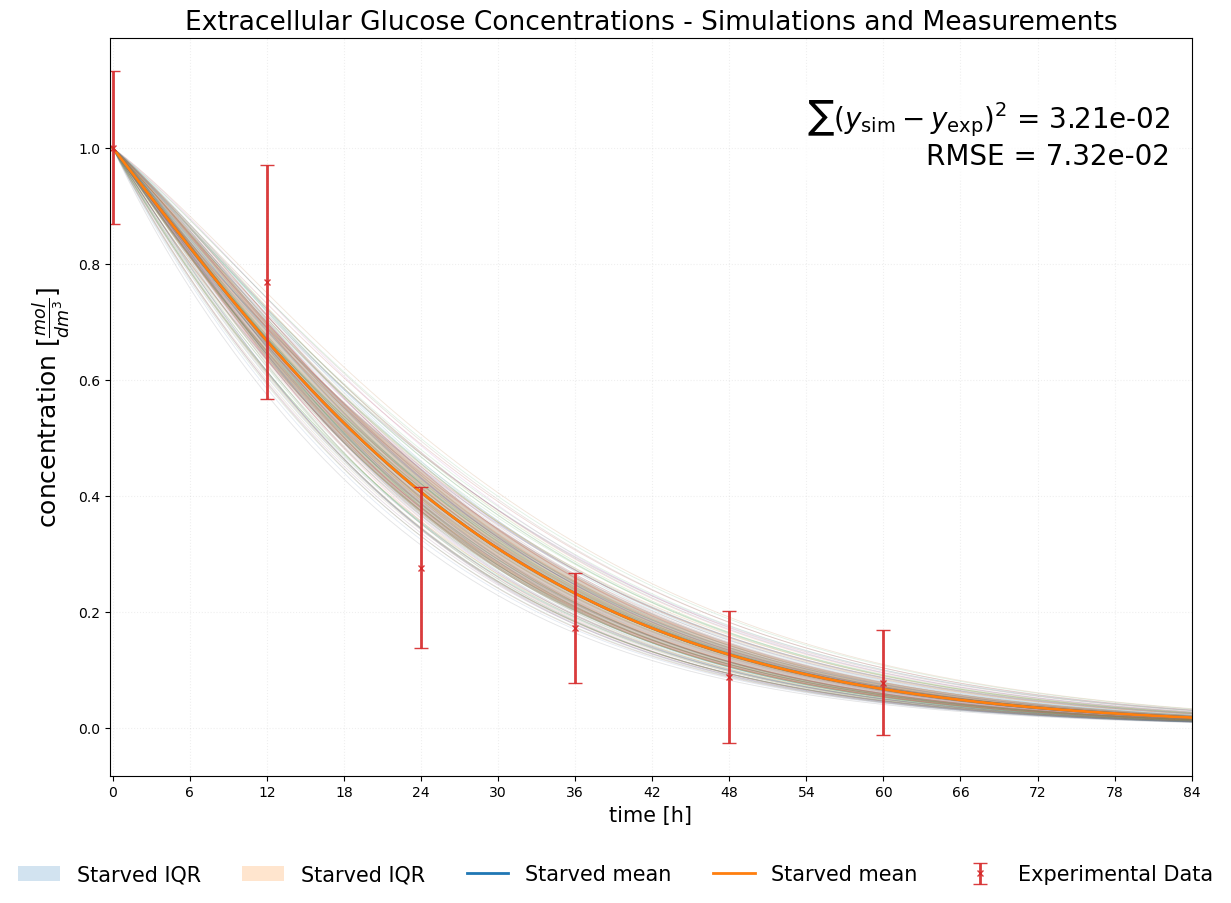

In [25]:
alma = copy.deepcopy(mechs['starve'].orig_time_sim_df)
for xml_name, temp_df in alma.items():
    alma[xml_name]['GLUCOUT'] *= 1e+6

fig = plot_compare_summary_gluc(
    df_dict_a=alma,
    df_dict_b=alma,
    label_a='Starved', label_b='Starved',
    species=('GLUCOUT'),
    show_iqr=True, show_p80=False,
    show_mean=True, show_median=False,
    sample_trajs=100, legend_pos="below",
    curve_labels=False,
    y_label=r"concentration $[\frac{mol}{dm^{3}}]$",
    figsize=(12, 9)
)

plt.show()

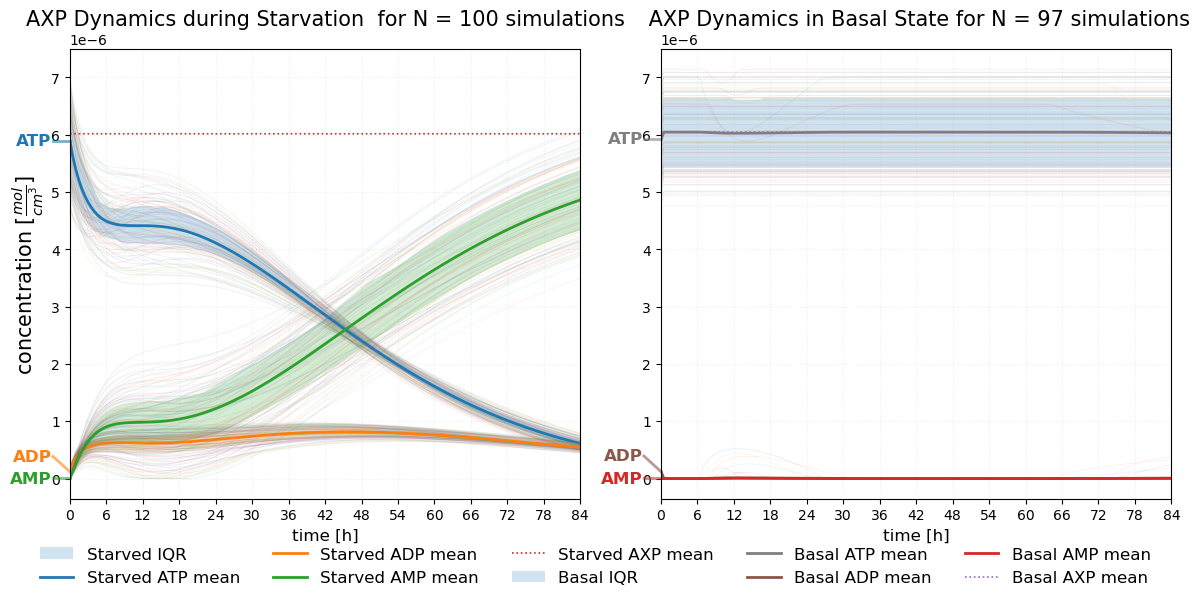

In [155]:
fig = plot_compare_summary_atp(
    df_dict_a=mechs['starve'].orig_time_sim_df,
    df_dict_b=mechs['stac'].orig_time_sim_df,
    label_a='Starved', label_b='Basal',
    species=('ATP', 'ADP', 'AMP'),
    layout_mode="condition",
    show_iqr=True, show_p80=False,
    show_mean=True, show_median=False,
    sample_trajs=100,
    legend_pos="below",
    curve_labels=True,
    curve_label_min_gap_frac=0.05,
    curve_label_xpad=-3.0,
    curve_label_connectors=True,
    figsize=(12, 6),
    separate_conditions=False
)

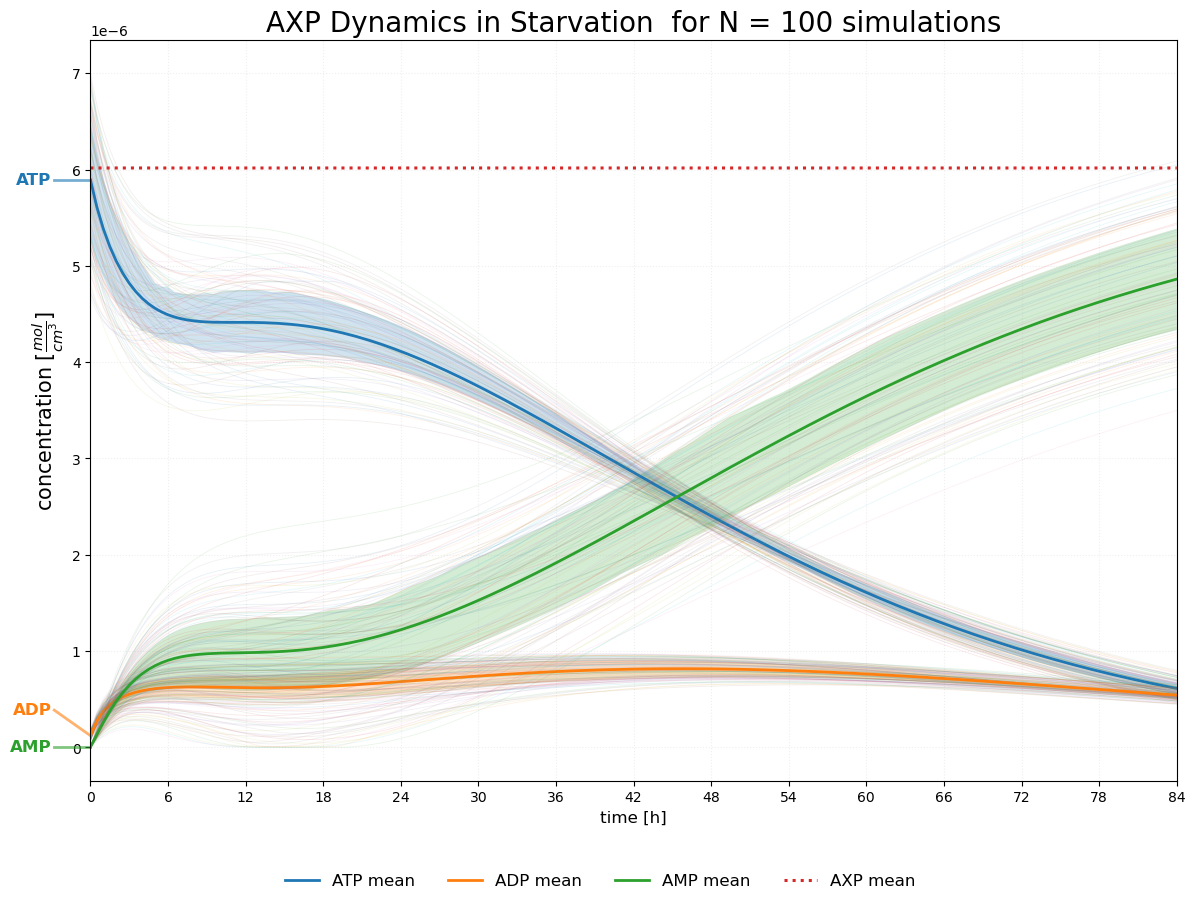

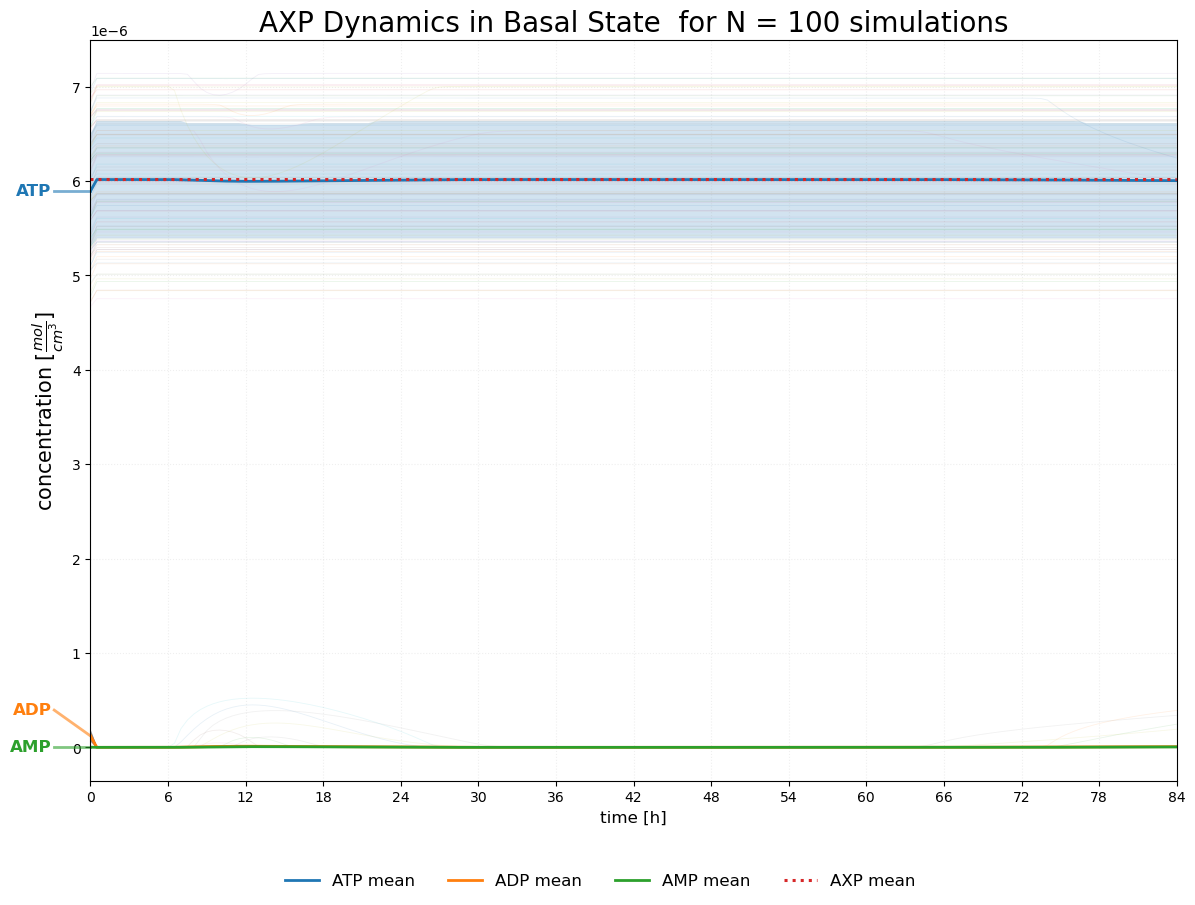

In [33]:
fig = plot_compare_summary_atp(
    df_dict_a=mechs['starve'].orig_time_sim_df,
    df_dict_b=mechs['stac'].orig_time_sim_df,
    label_a='Starved', label_b='Basal',
    species=('ATP', 'ADP', 'AMP'),
    layout_mode="condition",
    show_iqr=True, show_p80=False,
    show_mean=True, show_median=False,
    sample_trajs=100,
    legend_pos="below",
    curve_labels=True,
    curve_label_min_gap_frac=0.05,
    curve_label_xpad=-3.0,
    curve_label_connectors=True,
    figsize=(12, 9),
    separate_conditions=True,
    user_title='AXP Dynamics',
    title_font_size=20,
    x_title_font_size=56
    )

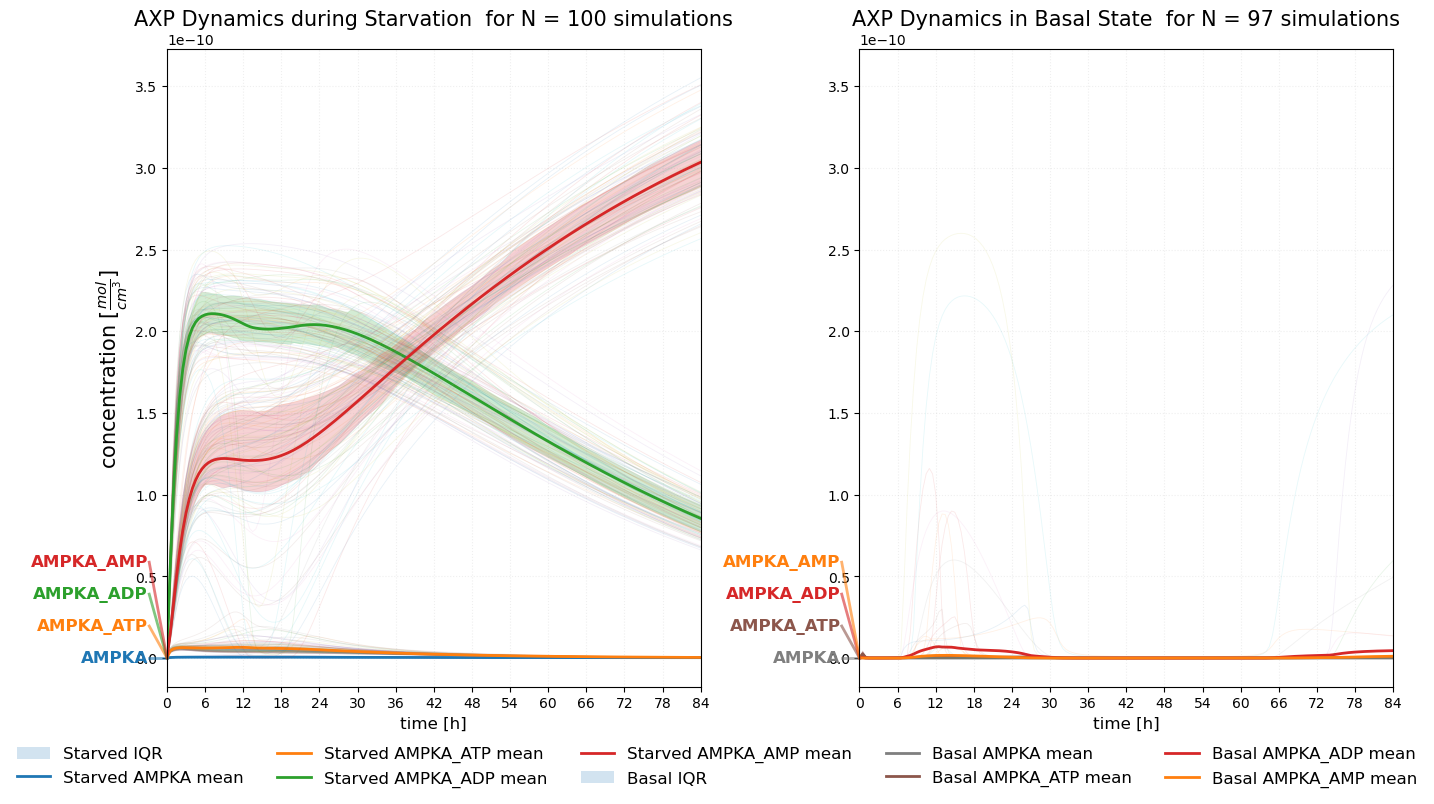

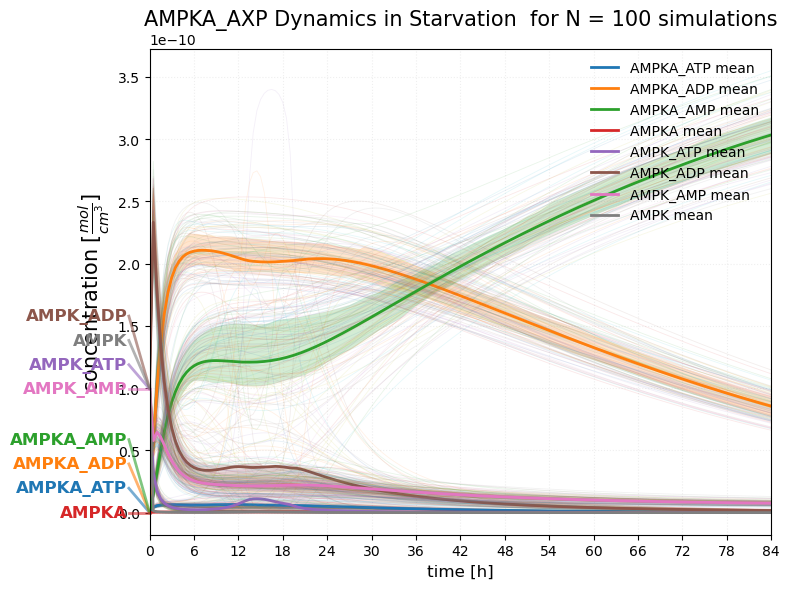

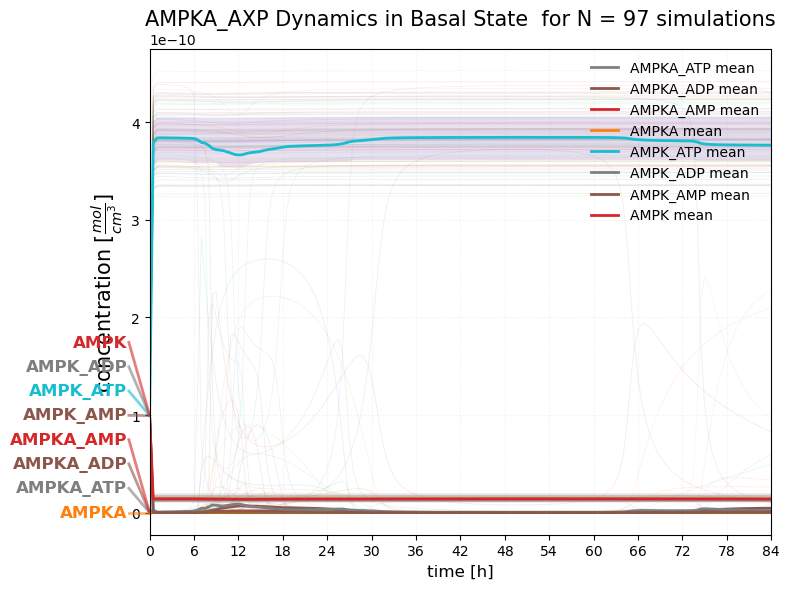

In [ ]:
fig = plot_compare_summary(
    df_dict_a=mechs['starve'].orig_time_sim_df,
    df_dict_b=mechs['stac'].orig_time_sim_df,
    label_a='Starved', label_b='Basal',
    species=('AMPKA', 'AMPKA_ATP', 'AMPKA_ADP', 'AMPKA_AMP'),
    layout_mode="condition",
    show_iqr=True, show_p80=False,
    show_mean=True, show_median=False,
    sample_trajs=100,
    legend_pos="below",
    curve_labels=True,
    curve_label_min_gap_frac=0.05,
    curve_label_xpad=-3.0,
    curve_label_connectors=True,
    figsize=(14, 8)
)
fig = plot_compare_summary_atp(
    df_dict_a=mechs['starve'].orig_time_sim_df,
    df_dict_b=mechs['stac'].orig_time_sim_df,
    label_a='Starved', label_b='Basal',
    species=('AMPKA_ATP', 'AMPKA_ADP', 'AMPKA_AMP','AMPKA',
             'AMPK_ATP', 'AMPK_ADP', 'AMPK_AMP','AMPK'),
    layout_mode="condition",
    show_iqr=True, show_p80=False,
    show_mean=True, show_median=False,
    sample_trajs=100,
    legend_pos="up",
    curve_labels=True,
    curve_label_min_gap_frac=0.05,
    curve_label_xpad=-3.0,
    curve_label_connectors=True,
    figsize=(12, 9),
    separate_conditions=True,
    user_title='AMPKA_AXP Dynamics'
    )

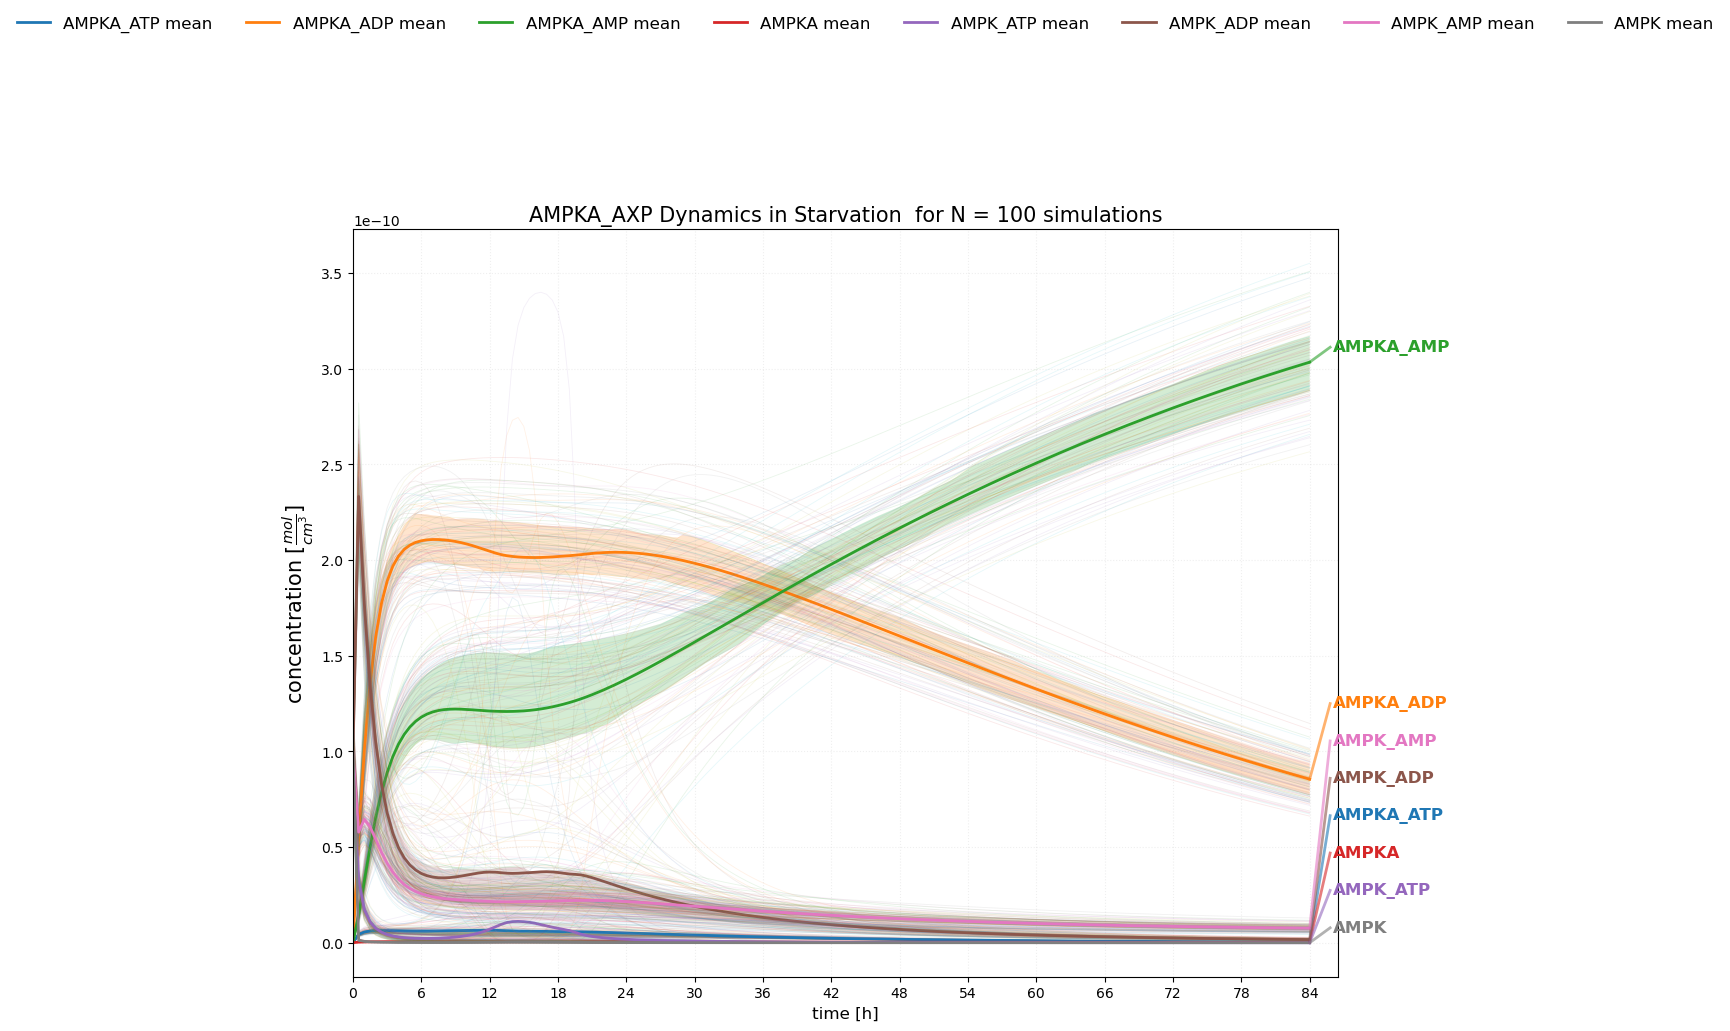

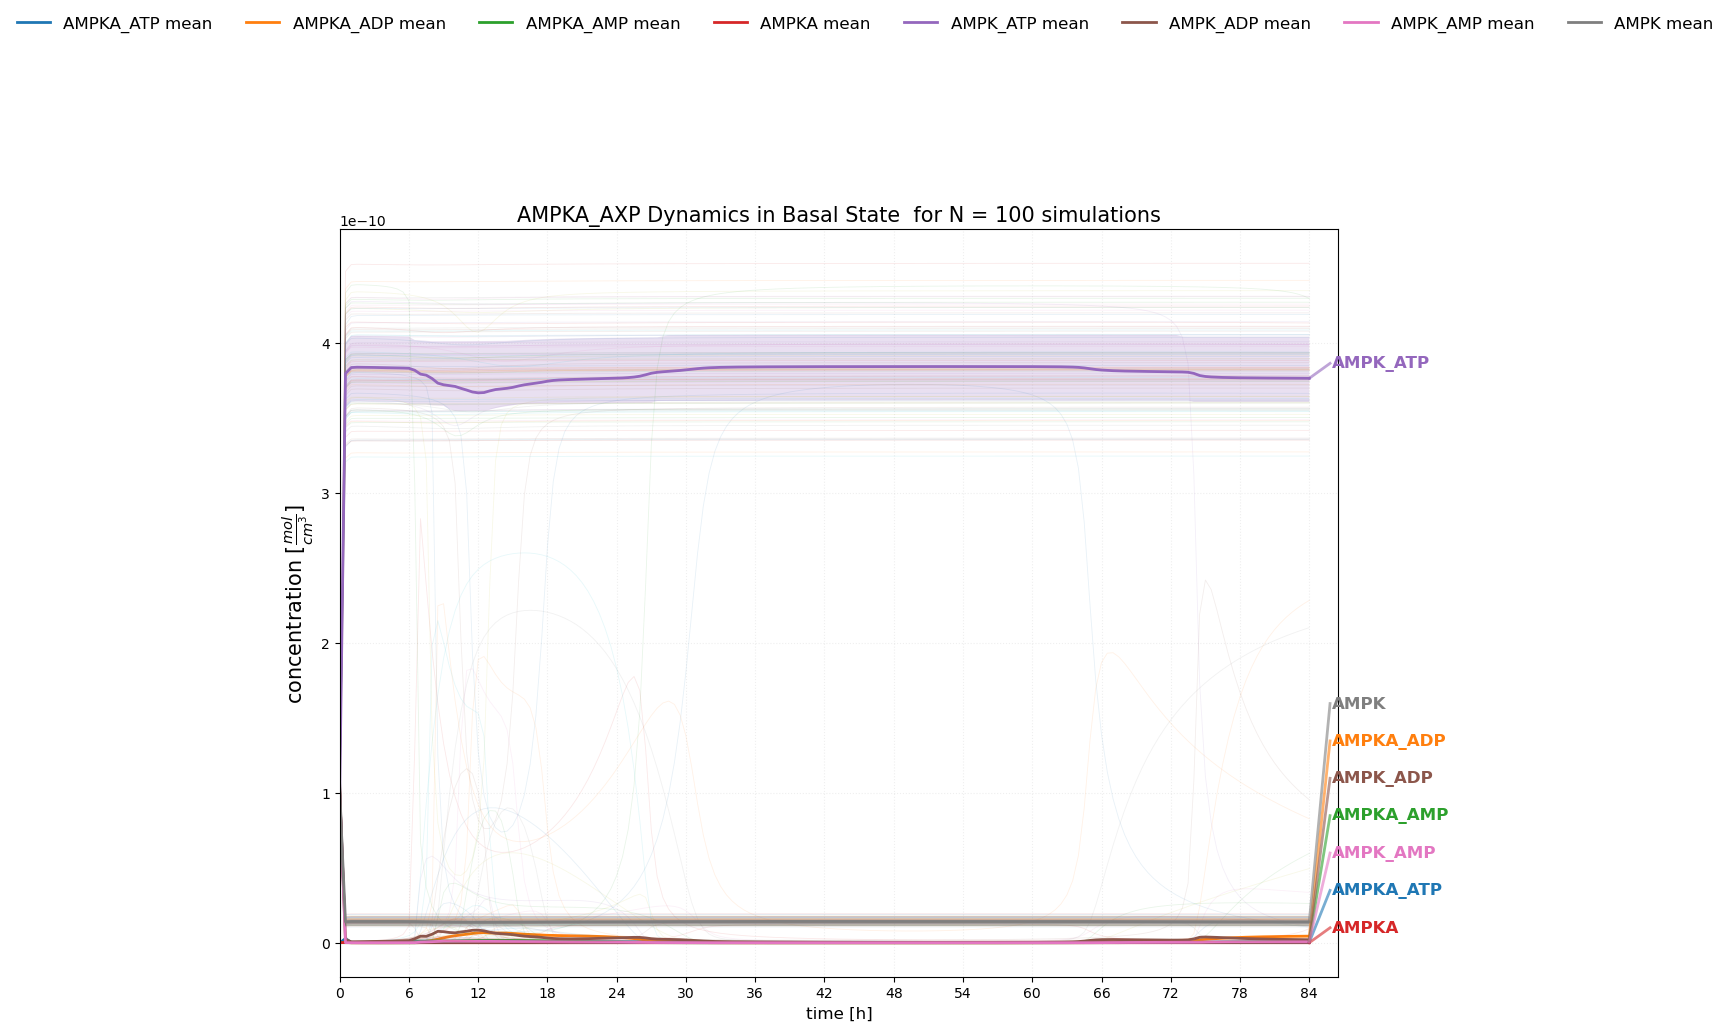

In [35]:
fig = plot_compare_summary_ampk(
    df_dict_a=mechs['starve'].orig_time_sim_df,
    df_dict_b=mechs['stac'].orig_time_sim_df,
    label_a='Starved', label_b='Basal',
    species=('AMPKA_ATP', 'AMPKA_ADP', 'AMPKA_AMP','AMPKA',
             'AMPK_ATP', 'AMPK_ADP', 'AMPK_AMP','AMPK'),
    layout_mode="condition",
    show_iqr=True, show_p80=False,
    show_mean=True, show_median=False,
    sample_trajs=100,
    legend_pos='above',
    curve_labels=True,
    curve_label_min_gap_frac=0.05,
    curve_label_xpad=2.0,
    curve_label_connectors=True,
    figsize=(12, 9),
    separate_conditions=True,
    user_title='AMPKA_AXP Dynamics'
    )

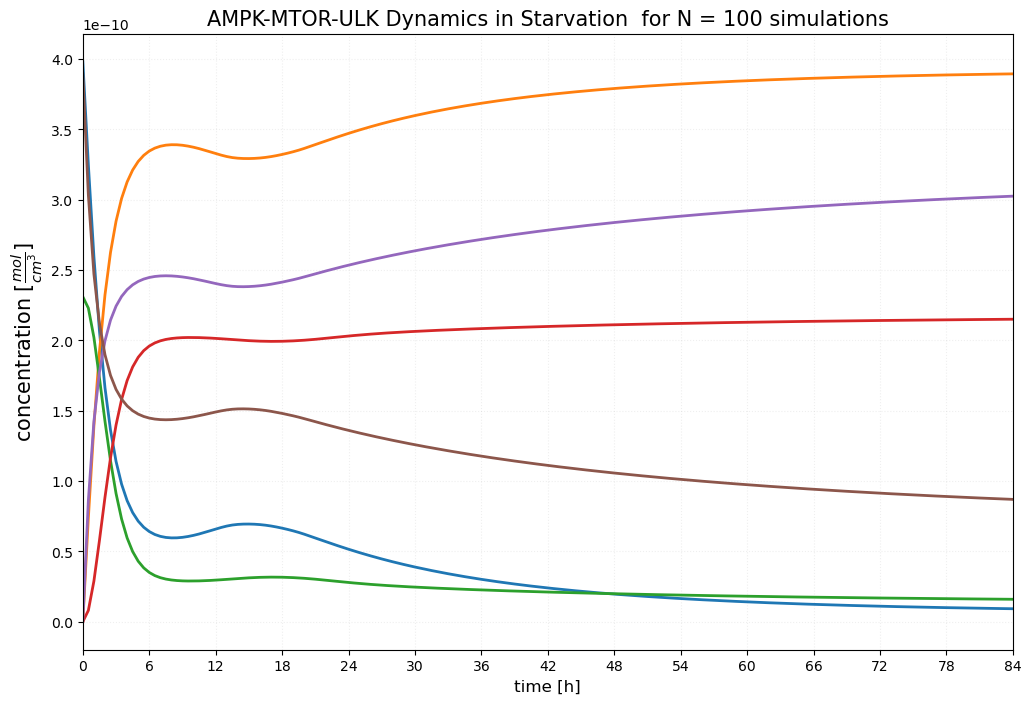

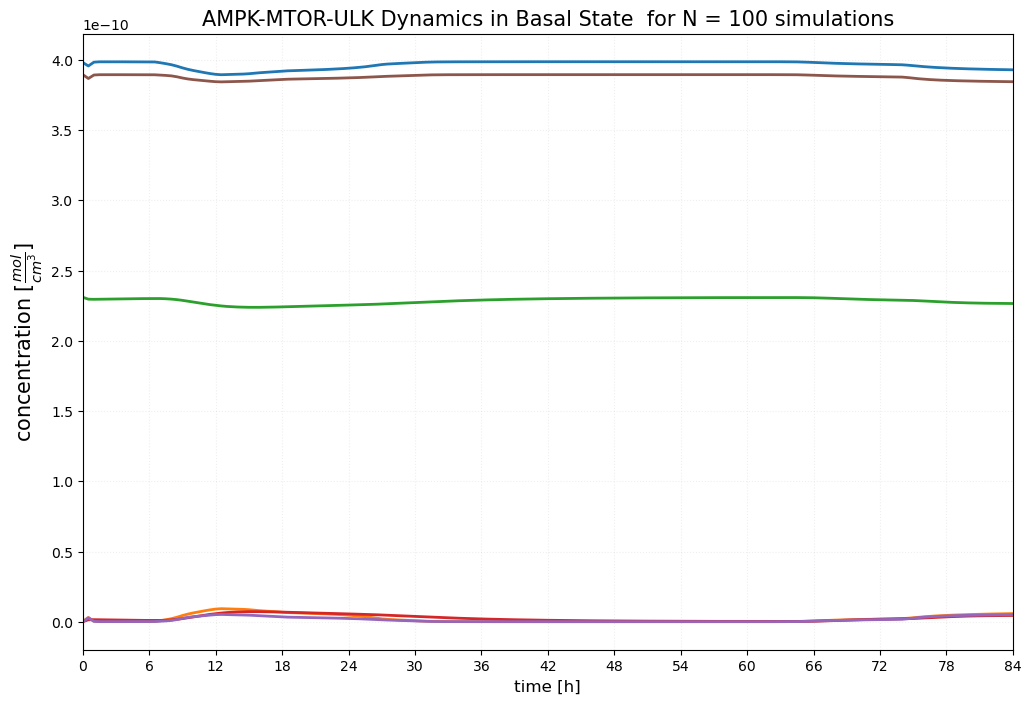

In [36]:
def add_ampk_totals(df_dict,
                    ampk_name='AMPK_t',
                    ampka_name='AMPKA_t'):
    """
    Return a new dict of DataFrames where each df has two extra columns:
    AMPK_tot  = AMPK  + AMPK_ATP  + AMPK_ADP  + AMPK_AMP
    AMPKA_tot = AMPKA + AMPKA_ATP + AMPKA_ADP + AMPKA_AMP
    """
    out = {}
    for key, df in df_dict.items():
        tmp = df.copy()

        tmp[ampk_name] = (
            tmp['AMPK'] +
            tmp['AMPK_ATP'] +
            tmp['AMPK_ADP'] +
            tmp['AMPK_AMP']
        )

        tmp[ampka_name] = (
            tmp['AMPKA'] +
            tmp['AMPKA_ATP'] +
            tmp['AMPKA_ADP'] +
            tmp['AMPKA_AMP']
        )

        out[key] = tmp
    return out

stac_ampk   = add_ampk_totals(mechs['stac'].orig_time_sim_df)
starve_ampk = add_ampk_totals(mechs['starve'].orig_time_sim_df)

fig = plot_compare_summary_ampk(
    df_dict_a=starve_ampk,
    df_dict_b=stac_ampk,
    label_a='Starved',
    label_b='Basal',
    species=('AMPK_t', 'AMPKA_t', 'ULK', 'ULKA', 'MTOR', 'MTORA'),
    layout_mode="condition",   # or "species", as you like
    show_iqr=False, show_p80=False,
    show_mean=True, show_median=False,
    sample_trajs=0,
    legend_pos="none",
    separate_conditions=True, 
    curve_labels=False,
    curve_label_xfrac=20,        # 1.0 = end of time window
    curve_label_xpad=1.5,         # 1.5 h to the right of that point
    curve_label_y_offset_frac=0.02,  # 2% of y-range above the curve
    figsize=(12, 8),
    user_title='AMPK-MTOR-ULK Dynamics'
)

plt.show()

In [ ]:
stac_ampk   = add_ampk_totals(mechs['stac'].orig_time_sim_df)
starve_ampk = add_ampk_totals(mechs['starve'].orig_time_sim_df)


{'stac_0001':             RHEBA        GLUCIN           ADP           AMP     AMPKA_ATP  \
 1    2.949160e-10  3.790170e-07  1.169130e-07  1.840700e-09  6.590080e-14   
 2    2.949160e-10  3.774330e-07  6.812690e-11  1.186050e-14  2.009510e-12   
 3    2.949160e-10  3.759590e-07  7.331570e-11  8.892770e-15  2.523100e-13   
 4    2.949160e-10  3.745800e-07  7.869240e-11  1.023910e-14  7.411410e-14   
 5    2.949160e-10  3.732830e-07  8.420480e-11  1.172570e-14  5.786320e-14   
 ..            ...           ...           ...           ...           ...   
 165  2.949170e-10  2.861900e-07  2.485920e-11  1.023920e-15  3.630450e-14   
 166  2.949170e-10  2.853790e-07  2.484390e-11  1.022630e-15  3.629720e-14   
 167  2.949170e-10  2.845580e-07  2.483160e-11  1.021490e-15  3.629120e-14   
 168  2.949170e-10  2.837280e-07  2.482260e-11  1.020480e-15  3.628650e-14   
 169  2.949170e-10  2.828970e-07  2.481360e-11  1.019470e-15  3.628180e-14   
 
         AMPKA_ADP      AMPK_ADP     AMPKA_AMP   

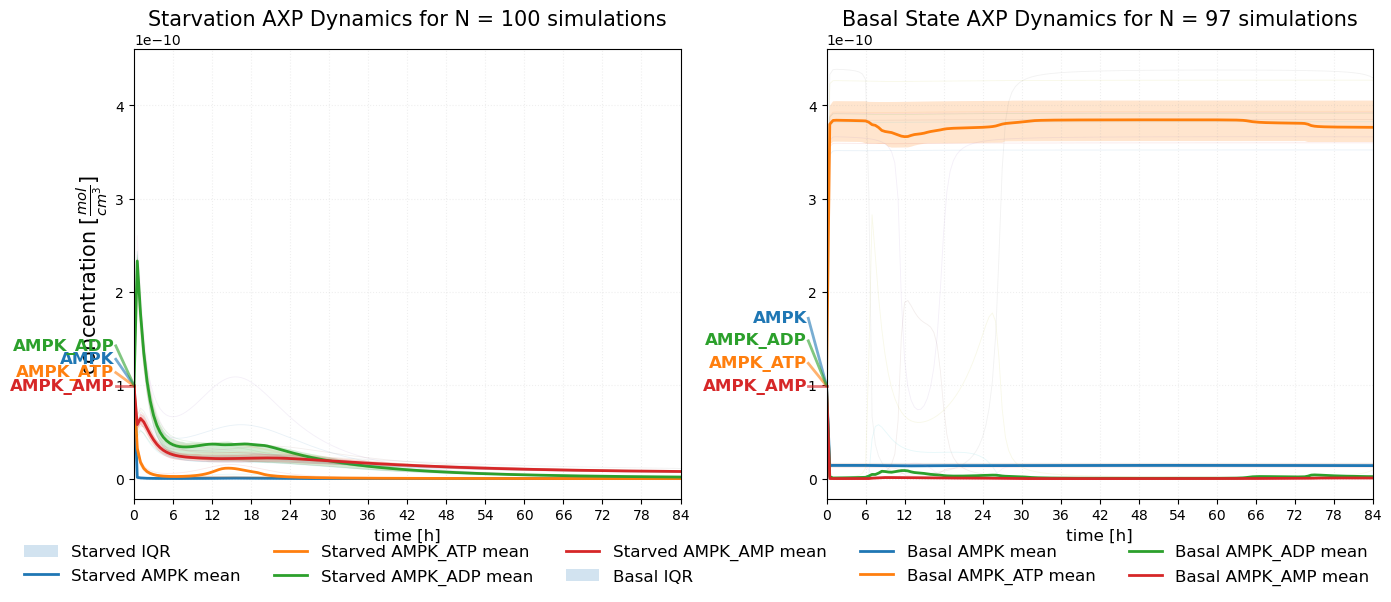

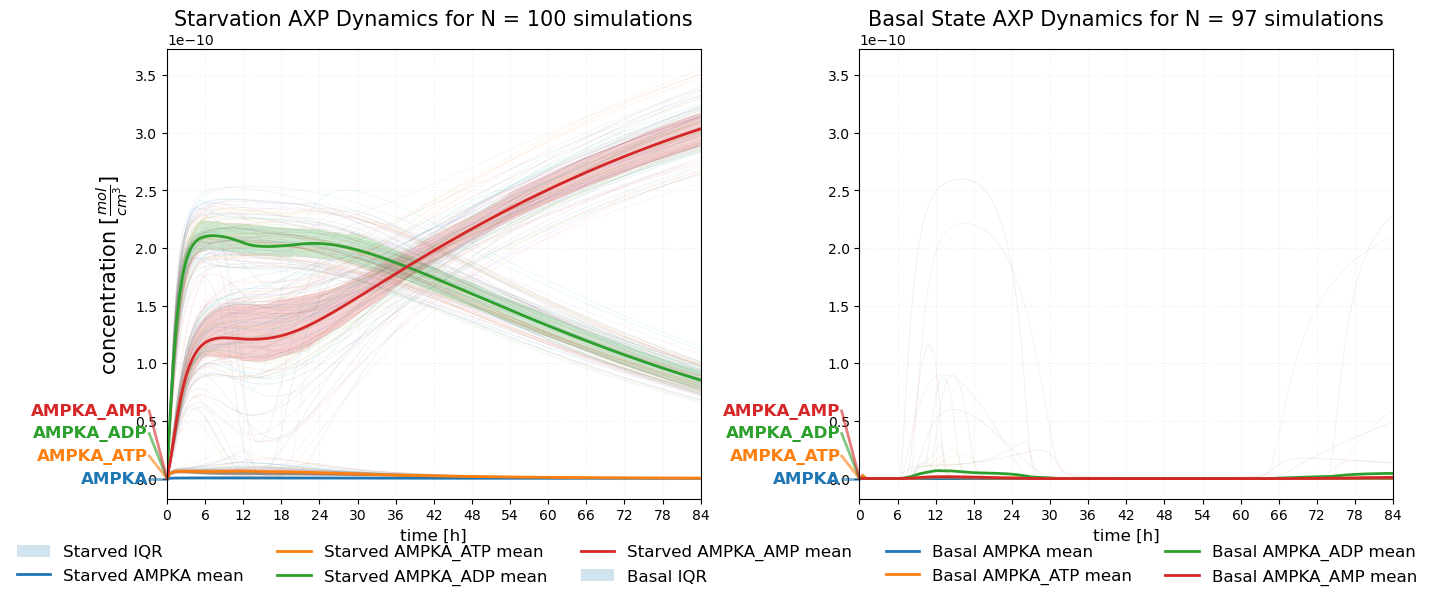

In [197]:
fig = plot_compare_summary(
    df_dict_a=mechs['starve'].orig_time_sim_df,
    df_dict_b=mechs['stac'].orig_time_sim_df,
    label_a='Starved', label_b='Basal',
    species=('AMPK', 'AMPK_ATP', 'AMPK_ADP', 'AMPK_AMP'),
    layout_mode="condition",
    show_iqr=True, show_p80=False,
    show_mean=True, show_median=False,
    sample_trajs=10,
    legend_pos="below",
    curve_labels=True,
    curve_label_min_gap_frac=0.05,
    curve_label_xpad=-3.0,
    curve_label_connectors=True,
    figsize=(14, 6)
)

fig = plot_compare_summary(
    df_dict_a=mechs['starve'].orig_time_sim_df,
    df_dict_b=mechs['stac'].orig_time_sim_df,
    label_a='Starved', label_b='Basal',
    species=('AMPKA', 'AMPKA_ATP', 'AMPKA_ADP', 'AMPKA_AMP'),
    layout_mode="condition",
    show_iqr=True, show_p80=False,
    show_mean=True, show_median=False,
    sample_trajs=90,
    legend_pos="below",
    curve_labels=True,
    curve_label_min_gap_frac=0.05,
    curve_label_xpad=-3.0,
    curve_label_connectors=True,
    figsize=(14, 6)
)

In [ ]:
ampks = {}
i = 0
for k in mechs.keys():
    for k2, v2 in mechs[k].orig_time_sim_df.items():
        if f'starve_{k2[-4:]}' in mechs['starve'].orig_time_sim_df.keys() and f'stac_{k2[-4:]}' in mechs['stac'].orig_time_sim_df.keys() and k2[-4:] != '0015' and k2[-4:] != '0063' and k2[-4:] != '0066' :
            AMPK = v2.AMPK + v2.AMPK_ATP + v2.AMPK_ADP + v2.AMPK_AMP
            AMPKA = v2.AMPKA + v2.AMPKA_ATP + v2.AMPKA_ADP + v2.AMPKA_AMP
            data_to_ampks = {'t': t, 'AMPK': AMPK, 'AMPKA': AMPKA}
            i+=1
            ampks[k] ={f"{k2}": pd.DataFrame(data_to_ampks)}

fig = plot_compare_summary(
    df_dict_a=ampks['starve'],
    df_dict_b=ampks['stac'],
    label_a='Starved', label_b='Basal',
    species=('AMPK', 'AMPKA'),
    layout_mode="condition",
    show_iqr=True, show_p80=False,
    show_mean=True, show_median=False,
    sample_trajs=90,
    legend_pos="below",
    curve_labels=True,
    curve_label_min_gap_frac=0.05,
    curve_label_xpad=-3.0,
    curve_label_connectors=True,
    figsize=(14, 8)
)

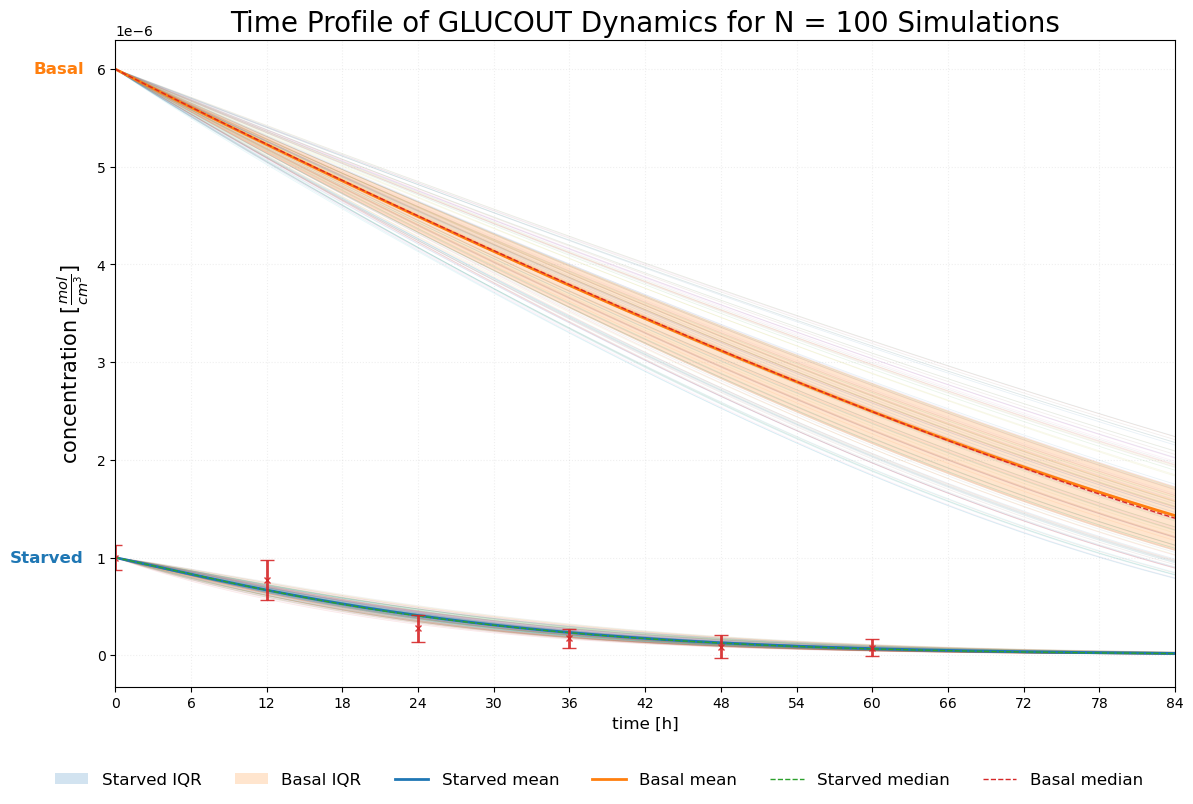

In [111]:
from typing import Dict, Iterable, Optional, Tuple

def _normalize_species(species):
    if isinstance(species, str):
        return (species,)
    return tuple(species)

def _stack_runs(df_dict, species, n_expected=None):
    species = _normalize_species(species)
    max_idx = max(df.index.max() for df in df_dict.values())
    if n_expected is not None:
        max_idx = max(max_idx, n_expected)
    idx = pd.RangeIndex(1, max_idx + 1)

    mats = []
    for _, df in df_dict.items():
        tmp = (df.sort_index()
                 .reindex(idx)
                 .apply(pd.to_numeric, errors='coerce')
                 .ffill().bfill())
        if set(species).issubset(tmp.columns):
            mats.append(tmp.loc[:, list(species)].to_numpy())
    if not mats:
        raise ValueError(f"No runs contained the requested species: {species}")
    return idx, np.stack(mats, axis=0)

def _summary(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    q10 = np.quantile(X, 0.10, axis=0)
    q25 = np.quantile(X, 0.25, axis=0)
    med  = np.quantile(X, 0.50, axis=0)
    q75 = np.quantile(X, 0.75, axis=0)
    q90 = np.quantile(X, 0.90, axis=0)
    mean = X.mean(axis=0)
    return q10, q25, med, q75, q90, mean

def plot_compare_summary(
    df_dict_a: Dict[str, pd.DataFrame],
    df_dict_b: Dict[str, pd.DataFrame],
    label_a: str = 'cond A',
    label_b: str = 'cond B',
    species=('ATP','ADP','AMP'),
    dt_minutes=30,
    total_hours=84,
    # ---- layout switch ----
    layout_mode: str = "species",   # "species" | "condition"
    # ---- stat controls ----
    show_iqr: bool = True,
    show_p80: bool = False,
    show_mean: bool = True,
    show_median: bool = False,
    sample_trajs: int = 0,          # 0 -> no thin trajectories
    traj_alpha: float = 0.10,
    band_alpha_iqr: float = 0.20,
    band_alpha_p80: float = 0.10,
    legend_pos: str = "below",      # "below" | "above" | "inside"
    # -----------------------
    show_axp: bool = True,          # only used if plotting the AXP trio
    figsize=(12, 8),
    curve_labels: bool = False,
    curve_label_min_gap_frac: float = 0.02,
    curve_label_xpad: float = -3.0,
    curve_label_connectors: bool = True,
    # ---- NEW: separate figures per species ----
    multi_fig: bool = False,
):
    """
    Compare conditions A vs B for the given species.

    layout_mode = "species":
        One subplot per species. Each subplot shows both conditions.

    layout_mode = "condition":
        Two subplots (A, B). Each subplot shows all species for that condition.

    multi_fig = True:
        Instead of one figure for all species, return a *list of figures*,
        one figure per species, using the chosen layout_mode.
    """
    if layout_mode not in {"species", "condition"}:
        raise ValueError('layout_mode must be "species" or "condition".')

    species = _normalize_species(species)

    # --- NEW: create one fig per species if requested -------------------
    if multi_fig and len(species) > 1:
        figs = []
        for sp in species:
            figs.append(
                plot_compare_summary(
                    df_dict_a=df_dict_a,
                    df_dict_b=df_dict_b,
                    label_a=label_a,
                    label_b=label_b,
                    species=(sp,),
                    dt_minutes=dt_minutes,
                    total_hours=total_hours,
                    layout_mode=layout_mode,
                    show_iqr=show_iqr,
                    show_p80=show_p80,
                    show_mean=show_mean,
                    show_median=show_median,
                    sample_trajs=sample_trajs,
                    traj_alpha=traj_alpha,
                    band_alpha_iqr=band_alpha_iqr,
                    band_alpha_p80=band_alpha_p80,
                    legend_pos=legend_pos,
                    show_axp=show_axp,
                    figsize=figsize,
                    curve_labels=curve_labels,
                    curve_label_min_gap_frac=curve_label_min_gap_frac,
                    curve_label_xpad=curve_label_xpad,
                    curve_label_connectors=curve_label_connectors,
                    multi_fig=False,      # avoid infinite recursion
                )
            )
        return figs
    # --------------------------------------------------------------------

    n_expected = int(total_hours*60/dt_minutes + 1)

    # stack & summarize
    idx_a, Xa = _stack_runs(df_dict_a, species, n_expected)  # [runs, time, species]
    idx_b, Xb = _stack_runs(df_dict_b, species, n_expected)
    t_h_a = (idx_a.values - 1) * dt_minutes / 60.0
    t_h_b = (idx_b.values - 1) * dt_minutes / 60.0

    qa10, qa25, qamed, qa75, qa90, qamean = _summary(Xa)
    qb10, qb25, qbmed, qb75, qb90, qbmean = _summary(Xb)

    rng = np.random.default_rng(0)
    samp_a = rng.choice(Xa.shape[0], size=min(sample_trajs, Xa.shape[0]), replace=False) if sample_trajs else []
    samp_b = rng.choice(Xb.shape[0], size=min(sample_trajs, Xb.shape[0]), replace=False) if sample_trajs else []

    legend_data = {label_a: {}, label_b: {}}

    # ---------------- LAYOUT 1: one subplot per species ----------------
    if layout_mode == "species":
        fig, axes = plt.subplots(1, len(species), figsize=figsize, sharex=True)
        if len(species) == 1:
            axes = [axes]

        for si, sp in enumerate(species):
            ax = axes[si]

            for ridx in samp_a:
                ax.plot(t_h_a, Xa[ridx, :, si], lw=0.6, alpha=traj_alpha)
            for ridx in samp_b:
                ax.plot(t_h_b, Xb[ridx, :, si], lw=0.6, alpha=traj_alpha)

            if show_p80:
                ax.fill_between(t_h_a, qa10[:, si], qa90[:, si],
                                alpha=band_alpha_p80, linewidth=0, label=f'{label_a} 10–90%')
            if show_iqr:
                ax.fill_between(t_h_a, qa25[:, si], qa75[:, si],
                                alpha=band_alpha_iqr, linewidth=0, label=f'{label_a} IQR')

            if show_p80:
                ax.fill_between(t_h_b, qb10[:, si], qb90[:, si],
                                alpha=band_alpha_p80, linewidth=0, label=f'{label_b} 10–90%')
            if show_iqr:
                ax.fill_between(t_h_b, qb25[:, si], qb75[:, si],
                                alpha=band_alpha_iqr, linewidth=0, label=f'{label_b} IQR')

            if curve_labels:
                y0_a = qamean[0, si]
                y0_b = qbmean[0, si]
                ax.text(-2.5, y0_a, f"{label_a}", color='tab:blue',
                        va='center', ha='right', fontsize=12, weight='bold')
                ax.text(-2.5, y0_b, f"{label_b}", color='tab:orange',
                        va='center', ha='right', fontsize=12, weight='bold')

            if show_mean:
                ax.plot(t_h_a, qamean[:, si], lw=2, label=f'{label_a} mean')
                ax.plot(t_h_b, qbmean[:, si], lw=2, label=f'{label_b} mean')
            if show_median:
                ax.plot(t_h_a, qamed[:, si], lw=1, linestyle='--', label=f'{label_a} median')
                ax.plot(t_h_b, qbmed[:, si], lw=1, linestyle='--', label=f'{label_b} median')

            ax.set_title(f"Time Profile of {sp} Dynamics for N = {Xa.shape[0]} Simulations", fontsize=20)
            ax.set_xlim(0, total_hours)
            ax.set_xticks(np.arange(0, total_hours+0.1, 6))
            if si == 0:
                ax.set_ylabel(r'concentration $[\frac{mol}{cm^{3}}]$', fontsize=15)
            ax.set_xlabel('time [h]', fontsize=12)
            ax.grid(alpha=0.2, linestyle=':')

            if sp == 'GLUCOUT' and (label_a == 'Starved' or label_b == 'Starved'):
                ax.errorbar(
                    sejeong_gluc.t,
                    sejeong_gluc.y,
                    yerr=sejeong_gluc.sigma,
                    fmt='x',
                    capsize=5,
                    lw=1.8,
                    markersize=5,
                    color='tab:red',
                    ecolor='tab:red',
                    elinewidth=2,
                    alpha=0.9
                )

    # ---------------- LAYOUT 2: one subplot per condition ----------------
    else: # stac vs starve
        fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)

        def _plot_condition_panel(ax, t_h, X, q10, q25, qmed, q75, q90, qmean,
                                  samp_idx, cond_label, bucket):
            first_for_stat = True
            sp_colors = {}

            for si, sp in enumerate(species):
                for ridx in samp_idx:
                    ax.plot(t_h, X[ridx, :, si], lw=0.6, alpha=traj_alpha, label='_nolegend_')

                if show_p80:
                    band = ax.fill_between(
                        t_h, q10[:, si], q90[:, si],
                        alpha=band_alpha_p80, linewidth=0
                    )
                    if first_for_stat:
                        bucket[('P80', None)] = band
                if show_iqr:
                    band = ax.fill_between(
                        t_h, q25[:, si], q75[:, si],
                        alpha=band_alpha_iqr, linewidth=0
                    )
                    if first_for_stat:
                        bucket[('IQR', None)] = band

                if show_mean:
                    line = ax.plot(t_h, qmean[:, si], lw=2)[0]
                    sp_colors[sp] = line.get_color()
                    bucket[('mean', sp)] = line
                if show_median:
                    line = ax.plot(t_h, qmed[:, si], lw=1, linestyle='--')[0]
                    bucket[('median', sp)] = line

                first_for_stat = False

            if cond_label == 'Starved':
                ax.set_title(f"AXP Dynamics during Starvation  for N = {X.shape[0]} simulations", fontsize=15)
            else:
                ax.set_title(f"AXP Dynamics in Basal State  for N = {X.shape[0]} simulations", fontsize=15)
            ax.set_xlim(0, total_hours)
            ax.set_xticks(np.arange(0, total_hours+0.1, 6))
            ax.set_xlabel('time [h]', fontsize=12)
            ax.grid(alpha=0.2, linestyle=':')

            # left species labels
            if curve_labels and show_mean:
                y0s = [qmean[0, si] for si in range(len(species))]
                y_min, y_max = ax.get_ylim()
                y_range = max(1e-12, (y_max - y_min))
                y_labs = _spread(y0s, curve_label_min_gap_frac * y_range)

                x_min, x_max = ax.get_xlim()
                ax.set_xlim(0, x_max)

                for sp, y_lab, y_true in zip(species, y_labs, y0s):
                    col = sp_colors.get(sp, 'black')
                    ax.text(curve_label_xpad, y_lab, sp,
                            color=col, va='center', ha='right',
                            fontsize=12, weight='bold')
                    if curve_label_connectors:
                        ax.plot([curve_label_xpad + 0.2, 0],
                                [y_lab, y_true],
                                lw=2.0, alpha=0.6, color=col,
                                label='_nolegend_',
                                clip_on=False)

        _plot_condition_panel(axes[0], t_h_a, Xa, qa10, qa25, qamed, qa75, qa90, qamean,
                              samp_a, label_a, legend_data[label_a])
        _plot_condition_panel(axes[1], t_h_b, Xb, qb10, qb25, qbmed, qb75, qb90, qbmean,
                              samp_b, label_b, legend_data[label_b])

        axes[0].set_ylabel(r'concentration $[\frac{mol}{cm^{3}}]$', fontsize=15)

        # --- NEW: force y-ticks/labels on the right subplot as well -----
        axes[1].tick_params(labelleft=True)
        # ----------------------------------------------------------------

        if show_axp and set(species) == {'ATP','ADP','AMP'}:
            line_a = axes[0].plot(t_h_a, qamean.sum(axis=1), lw=1.2, linestyle=':')[0]
            line_b = axes[1].plot(t_h_b, qbmean.sum(axis=1), lw=1.2, linestyle=':')[0]
            legend_data[label_a][('AXP_mean', None)] = line_a
            legend_data[label_b][('AXP_mean', None)] = line_b

    # -------- legend placement (same as your last version) -------------
    if layout_mode == "condition" and legend_pos in {"below", "above"}:
        cols = []
        if show_iqr:
            cols.append(('IQR', None))
        if show_p80:
            cols.append(('P80', None))
        for sp in species:
            if show_mean:
                cols.append(('mean', sp))
            if show_median:
                cols.append(('median', sp))
        if show_axp and set(species) == {'ATP','ADP','AMP'}:
            cols.append(('AXP_mean', None))

        def desc_str(key):
            kind, sp = key
            if kind == 'IQR':
                return 'IQR'
            if kind == 'P80':
                return '10–90%'
            if kind == 'mean' and sp is not None:
                return f'{sp} mean'
            if kind == 'median' and sp is not None:
                return f'{sp} median'
            if kind == 'AXP_mean':
                return 'AXP mean'
            return str(key)

        handles, labels = [], []
        for cond_label in (label_a, label_b):
            bucket = legend_data[cond_label]
            for key in cols:
                h = bucket.get(key)
                if h is not None:
                    handles.append(h)
                    labels.append(f"{cond_label} {desc_str(key)}")

        ncol = len(cols) if cols else 1
    else:
        if layout_mode == "condition":
            h0, l0 = axes[0].get_legend_handles_labels()
            h1, l1 = axes[1].get_legend_handles_labels()
            handles, labels = list(h0), list(l0)
            for h, lab in zip(h1, l1):
                if lab not in labels:
                    handles.append(h)
                    labels.append(lab)
        else:
            handles, labels = axes[0].get_legend_handles_labels()
        ncol = 6

    if legend_pos == "below":
        fig.legend(handles, labels, frameon=False, loc='lower center',
                   bbox_to_anchor=(0.5, -0.01), ncol=ncol, fontsize=12)
        fig.tight_layout(rect=[0, 0.06, 1, 1])
    elif legend_pos == "above":
        fig.legend(handles, labels, frameon=False, loc='upper center',
                   bbox_to_anchor=(0.5, 1.15), ncol=ncol, fontsize=12)
        fig.tight_layout(rect=[0, 0, 1, 0.94])
    else:
        axes[-1].legend(handles, labels, frameon=False, loc='upper right')
        fig.tight_layout()

    fig.patch.set_facecolor('white')
    #fig.subplots_adjust(left=0.22)
    return fig

fig = plot_compare_summary(
    df_dict_a=mechs['starve'].orig_time_sim_df,
    df_dict_b=mechs['stac'].orig_time_sim_df,
    label_a='Starved', label_b='Basal',
    species=('GLUCOUT'),
    layout_mode="species",
    show_iqr=True, show_p80=False,
    show_mean=True, show_median=True,
    sample_trajs=100,
    legend_pos="below",
    curve_labels=True,
    curve_label_min_gap_frac=0.05,
    curve_label_xpad=-3.0,
    curve_label_connectors=True,
    figsize=(12, 8)
)

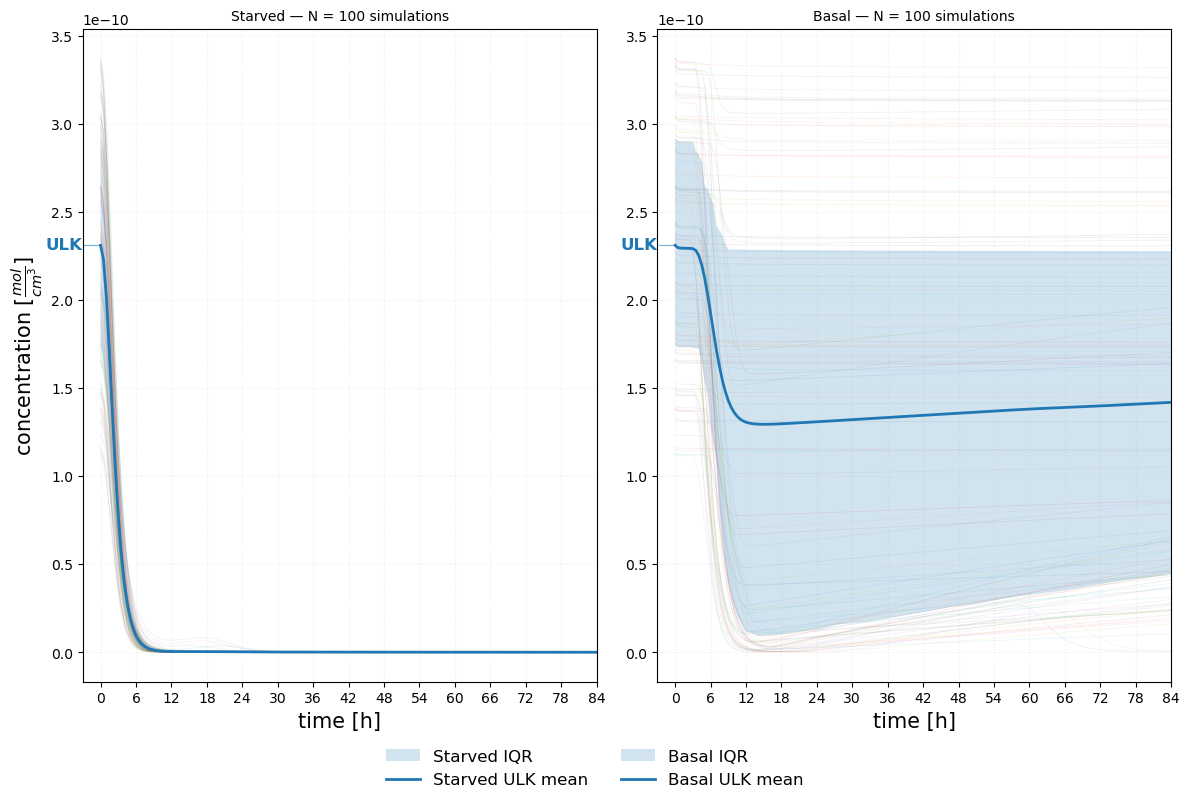

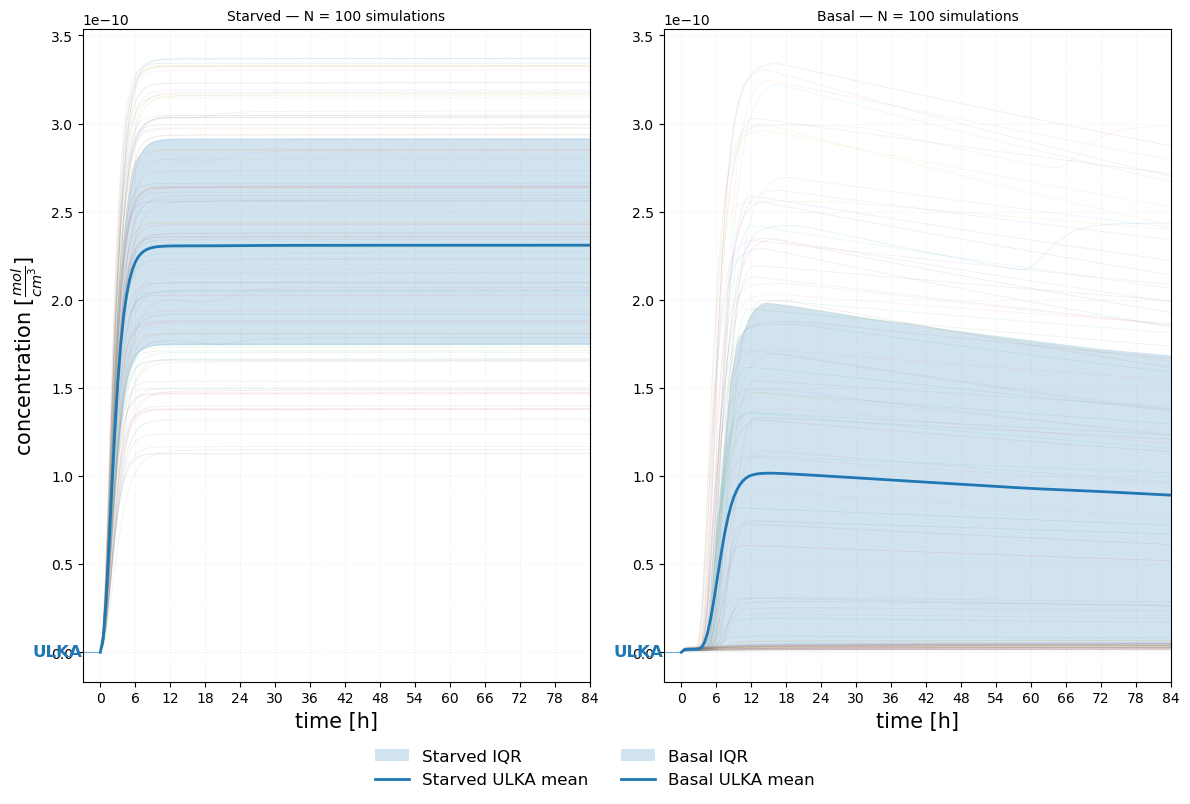

In [ ]:
from typing import Dict, Iterable, Optional, Tuple

def _normalize_species(species):
    if isinstance(species, str):
        return (species,)
    return tuple(species)

def _stack_runs(df_dict, species, n_expected=None):
    species = _normalize_species(species)
    max_idx = max(df.index.max() for df in df_dict.values())
    if n_expected is not None:
        max_idx = max(max_idx, n_expected)
    idx = pd.RangeIndex(1, max_idx + 1)

    mats = []
    for _, df in df_dict.items():
        tmp = (df.sort_index()
                 .reindex(idx)
                 .apply(pd.to_numeric, errors='coerce')
                 .ffill().bfill())
        if set(species).issubset(tmp.columns):
            mats.append(tmp.loc[:, list(species)].to_numpy())
    if not mats:
        raise ValueError(f"No runs contained the requested species: {species}")
    return idx, np.stack(mats, axis=0)

def _summary(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    q10 = np.quantile(X, 0.10, axis=0)
    q25 = np.quantile(X, 0.25, axis=0)
    med  = np.quantile(X, 0.50, axis=0)
    q75 = np.quantile(X, 0.75, axis=0)
    q90 = np.quantile(X, 0.90, axis=0)
    mean = X.mean(axis=0)
    return q10, q25, med, q75, q90, mean

def plot_compare_summary(
    df_dict_a: Dict[str, pd.DataFrame],
    df_dict_b: Dict[str, pd.DataFrame],
    label_a: str = 'cond A',
    label_b: str = 'cond B',
    species=('ATP','ADP','AMP'),
    dt_minutes=30,
    total_hours=84,
    # ---- layout switch ----
    layout_mode: str = "species",   # "species" | "condition"
    # ---- stat controls ----
    show_iqr: bool = True,
    show_p80: bool = False,
    show_mean: bool = True,
    show_median: bool = False,
    sample_trajs: int = 0,          # 0 -> no thin trajectories
    traj_alpha: float = 0.10,
    band_alpha_iqr: float = 0.20,
    band_alpha_p80: float = 0.10,
    legend_pos: str = "below",      # "below" | "above" | "inside"
    # -----------------------
    show_axp: bool = True,          # only used if plotting the AXP trio
    figsize=(12, 8),
    curve_labels: bool = False,
    curve_label_min_gap_frac: float = 0.02,
    curve_label_xpad: float = -3.0,
    curve_label_connectors: bool = True,
    # ---- NEW: separate figures per species ----
    multi_fig: bool = False,
):
    """
    Compare conditions A vs B for the given species.

    layout_mode = "species":
        One subplot per species. Each subplot shows both conditions.

    layout_mode = "condition":
        Two subplots (A, B). Each subplot shows all species for that condition.

    multi_fig = True:
        Instead of one figure for all species, return a *list of figures*,
        one figure per species, using the chosen layout_mode.
    """
    if layout_mode not in {"species", "condition"}:
        raise ValueError('layout_mode must be "species" or "condition".')

    species = _normalize_species(species)

    # --- NEW: create one fig per species if requested -------------------
    if multi_fig and len(species) > 1:
        figs = []
        for sp in species:
            figs.append(
                plot_compare_summary(
                    df_dict_a=df_dict_a,
                    df_dict_b=df_dict_b,
                    label_a=label_a,
                    label_b=label_b,
                    species=(sp,),
                    dt_minutes=dt_minutes,
                    total_hours=total_hours,
                    layout_mode=layout_mode,
                    show_iqr=show_iqr,
                    show_p80=show_p80,
                    show_mean=show_mean,
                    show_median=show_median,
                    sample_trajs=sample_trajs,
                    traj_alpha=traj_alpha,
                    band_alpha_iqr=band_alpha_iqr,
                    band_alpha_p80=band_alpha_p80,
                    legend_pos=legend_pos,
                    show_axp=show_axp,
                    figsize=figsize,
                    curve_labels=curve_labels,
                    curve_label_min_gap_frac=curve_label_min_gap_frac,
                    curve_label_xpad=curve_label_xpad,
                    curve_label_connectors=curve_label_connectors,
                    multi_fig=False,      # avoid infinite recursion
                )
            )
        return figs
    # --------------------------------------------------------------------

    n_expected = int(total_hours*60/dt_minutes + 1)

    # stack & summarize
    idx_a, Xa = _stack_runs(df_dict_a, species, n_expected)  # [runs, time, species]
    idx_b, Xb = _stack_runs(df_dict_b, species, n_expected)
    t_h_a = (idx_a.values - 1) * dt_minutes / 60.0
    t_h_b = (idx_b.values - 1) * dt_minutes / 60.0

    qa10, qa25, qamed, qa75, qa90, qamean = _summary(Xa)
    qb10, qb25, qbmed, qb75, qb90, qbmean = _summary(Xb)

    rng = np.random.default_rng(0)
    samp_a = rng.choice(Xa.shape[0], size=min(sample_trajs, Xa.shape[0]), replace=False) if sample_trajs else []
    samp_b = rng.choice(Xb.shape[0], size=min(sample_trajs, Xb.shape[0]), replace=False) if sample_trajs else []

    legend_data = {label_a: {}, label_b: {}}

    # ---------------- LAYOUT 1: one subplot per species ----------------
    if layout_mode == "species":
        fig, axes = plt.subplots(1, len(species), figsize=figsize, sharex=True)
        if len(species) == 1:
            axes = [axes]

        for si, sp in enumerate(species):
            ax = axes[si]

            for ridx in samp_a:
                ax.plot(t_h_a, Xa[ridx, :, si], lw=0.6, alpha=traj_alpha)
            for ridx in samp_b:
                ax.plot(t_h_b, Xb[ridx, :, si], lw=0.6, alpha=traj_alpha)

            if show_p80:
                ax.fill_between(t_h_a, qa10[:, si], qa90[:, si],
                                alpha=band_alpha_p80, linewidth=0, label=f'{label_a} 10–90%')
            if show_iqr:
                ax.fill_between(t_h_a, qa25[:, si], qa75[:, si],
                                alpha=band_alpha_iqr, linewidth=0, label=f'{label_a} IQR')

            if show_p80:
                ax.fill_between(t_h_b, qb10[:, si], qb90[:, si],
                                alpha=band_alpha_p80, linewidth=0, label=f'{label_b} 10–90%')
            if show_iqr:
                ax.fill_between(t_h_b, qb25[:, si], qb75[:, si],
                                alpha=band_alpha_iqr, linewidth=0, label=f'{label_b} IQR')

            if curve_labels:
                y0_a = qamean[0, si]
                y0_b = qbmean[0, si]
                ax.text(-2.5, y0_a, f"{label_a}", color='tab:blue',
                        va='center', ha='right', fontsize=12, weight='bold')
                ax.text(-2.5, y0_b, f"{label_b}", color='tab:orange',
                        va='center', ha='right', fontsize=12, weight='bold')

            if show_mean:
                ax.plot(t_h_a, qamean[:, si], lw=2, label=f'{label_a} mean')
                ax.plot(t_h_b, qbmean[:, si], lw=2, label=f'{label_b} mean')
            if show_median:
                ax.plot(t_h_a, qamed[:, si], lw=1, linestyle='--', label=f'{label_a} median')
                ax.plot(t_h_b, qbmed[:, si], lw=1, linestyle='--', label=f'{label_b} median')

            ax.set_title(f"Time Profile of {sp} Dynamics - N = {Xa.shape[0]} Simulations", fontsize=10)
            ax.set_xlim(0, total_hours)
            ax.set_xticks(np.arange(0, total_hours+0.1, 6))
            if si == 0:
                ax.set_ylabel(r'concentration $[\frac{mol}{cm^{3}}]$', fontsize=15)
            ax.set_xlabel('time [h]', fontsize=15)
            ax.grid(alpha=0.2, linestyle=':')

            if sp == 'GLUCOUT' and (label_a == 'Starved' or label_b == 'Starved'):
                ax.errorbar(
                    sejeong_gluc.t,
                    sejeong_gluc.y,
                    yerr=sejeong_gluc.sigma,
                    fmt='x',
                    capsize=5,
                    lw=1.8,
                    markersize=5,
                    color='tab:red',
                    ecolor='tab:red',
                    elinewidth=2,
                    alpha=0.9
                )

    # ---------------- LAYOUT 2: one subplot per condition ----------------
    else:
        fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)

        def _plot_condition_panel(ax, t_h, X, q10, q25, qmed, q75, q90, qmean,
                                  samp_idx, cond_label, bucket):
            first_for_stat = True
            sp_colors = {}

            for si, sp in enumerate(species):
                for ridx in samp_idx:
                    ax.plot(t_h, X[ridx, :, si], lw=0.6, alpha=traj_alpha, label='_nolegend_')

                if show_p80:
                    band = ax.fill_between(
                        t_h, q10[:, si], q90[:, si],
                        alpha=band_alpha_p80, linewidth=0
                    )
                    if first_for_stat:
                        bucket[('P80', None)] = band
                if show_iqr:
                    band = ax.fill_between(
                        t_h, q25[:, si], q75[:, si],
                        alpha=band_alpha_iqr, linewidth=0
                    )
                    if first_for_stat:
                        bucket[('IQR', None)] = band

                if show_mean:
                    line = ax.plot(t_h, qmean[:, si], lw=2)[0]
                    sp_colors[sp] = line.get_color()
                    bucket[('mean', sp)] = line
                if show_median:
                    line = ax.plot(t_h, qmed[:, si], lw=1, linestyle='--')[0]
                    bucket[('median', sp)] = line

                first_for_stat = False

            ax.set_title(f"{cond_label} — N = {X.shape[0]} simulations", fontsize=10)
            ax.set_xlim(0, total_hours)
            ax.set_xticks(np.arange(0, total_hours+0.1, 6))
            ax.set_xlabel('time [h]', fontsize=15)
            ax.grid(alpha=0.2, linestyle=':')

            # left species labels
            if curve_labels and show_mean:
                y0s = [qmean[0, si] for si in range(len(species))]
                y_min, y_max = ax.get_ylim()
                y_range = max(1e-12, (y_max - y_min))
                y_labs = _spread(y0s, curve_label_min_gap_frac * y_range)

                x_min, x_max = ax.get_xlim()
                ax.set_xlim(min(curve_label_xpad, x_min), x_max)

                for sp, y_lab, y_true in zip(species, y_labs, y0s):
                    col = sp_colors.get(sp, 'black')
                    ax.text(curve_label_xpad, y_lab, sp,
                            color=col, va='center', ha='right',
                            fontsize=12, weight='bold')
                    if curve_label_connectors:
                        ax.plot([curve_label_xpad + 0.2, 0],
                                [y_lab, y_true],
                                lw=0.8, alpha=0.6, color=col,
                                label='_nolegend_')

        _plot_condition_panel(axes[0], t_h_a, Xa, qa10, qa25, qamed, qa75, qa90, qamean,
                              samp_a, label_a, legend_data[label_a])
        _plot_condition_panel(axes[1], t_h_b, Xb, qb10, qb25, qbmed, qb75, qb90, qbmean,
                              samp_b, label_b, legend_data[label_b])

        axes[0].set_ylabel(r'concentration $[\frac{mol}{cm^{3}}]$', fontsize=15)

        # --- NEW: force y-ticks/labels on the right subplot as well -----
        axes[1].tick_params(labelleft=True)
        # ----------------------------------------------------------------

        if show_axp and set(species) == {'ATP','ADP','AMP'}:
            line_a = axes[0].plot(t_h_a, qamean.sum(axis=1), lw=1.2, linestyle=':')[0]
            line_b = axes[1].plot(t_h_b, qbmean.sum(axis=1), lw=1.2, linestyle=':')[0]
            legend_data[label_a][('AXP_mean', None)] = line_a
            legend_data[label_b][('AXP_mean', None)] = line_b

    # -------- legend placement (same as your last version) -------------
    if layout_mode == "condition" and legend_pos in {"below", "above"}:
        cols = []
        if show_iqr:
            cols.append(('IQR', None))
        if show_p80:
            cols.append(('P80', None))
        for sp in species:
            if show_mean:
                cols.append(('mean', sp))
            if show_median:
                cols.append(('median', sp))
        if show_axp and set(species) == {'ATP','ADP','AMP'}:
            cols.append(('AXP_mean', None))

        def desc_str(key):
            kind, sp = key
            if kind == 'IQR':
                return 'IQR'
            if kind == 'P80':
                return '10–90%'
            if kind == 'mean' and sp is not None:
                return f'{sp} mean'
            if kind == 'median' and sp is not None:
                return f'{sp} median'
            if kind == 'AXP_mean':
                return 'AXP mean'
            return str(key)

        handles, labels = [], []
        for cond_label in (label_a, label_b):
            bucket = legend_data[cond_label]
            for key in cols:
                h = bucket.get(key)
                if h is not None:
                    handles.append(h)
                    labels.append(f"{cond_label} {desc_str(key)}")

        ncol = len(cols) if cols else 1
    else:
        if layout_mode == "condition":
            h0, l0 = axes[0].get_legend_handles_labels()
            h1, l1 = axes[1].get_legend_handles_labels()
            handles, labels = list(h0), list(l0)
            for h, lab in zip(h1, l1):
                if lab not in labels:
                    handles.append(h)
                    labels.append(lab)
        else:
            handles, labels = axes[0].get_legend_handles_labels()
        ncol = 6

    if legend_pos == "below":
        fig.legend(handles, labels, frameon=False, loc='lower center',
                   bbox_to_anchor=(0.5, -0.01), ncol=ncol, fontsize=12)
        fig.tight_layout(rect=[0, 0.06, 1, 1])
    elif legend_pos == "above":
        fig.legend(handles, labels, frameon=False, loc='upper center',
                   bbox_to_anchor=(0.5, 1.15), ncol=ncol, fontsize=12)
        fig.tight_layout(rect=[0, 0, 1, 0.94])
    else:
        axes[-1].legend(handles, labels, frameon=False, loc='upper right')
        fig.tight_layout()

    fig.patch.set_facecolor('white')
    return fig

figs = plot_compare_summary(
    mechs['starve'].orig_time_sim_df,
    mechs['stac'].orig_time_sim_df,
    label_a='Starved', label_b='Basal',
    species=('ULK', 'ULKA'),
    layout_mode="condition",
    show_iqr=True, show_p80=False,
    show_mean=True, show_median=False,
    sample_trajs=100,
    legend_pos="below",
    curve_labels=True,
    multi_fig=True,              # <-- new
    curve_label_connectors=True,
    curve_label_min_gap_frac=0.12,
    curve_label_xpad=-3
)

# figs is now a list of Matplotlib Figure objects, one per species
for f in figs:
    f.show()


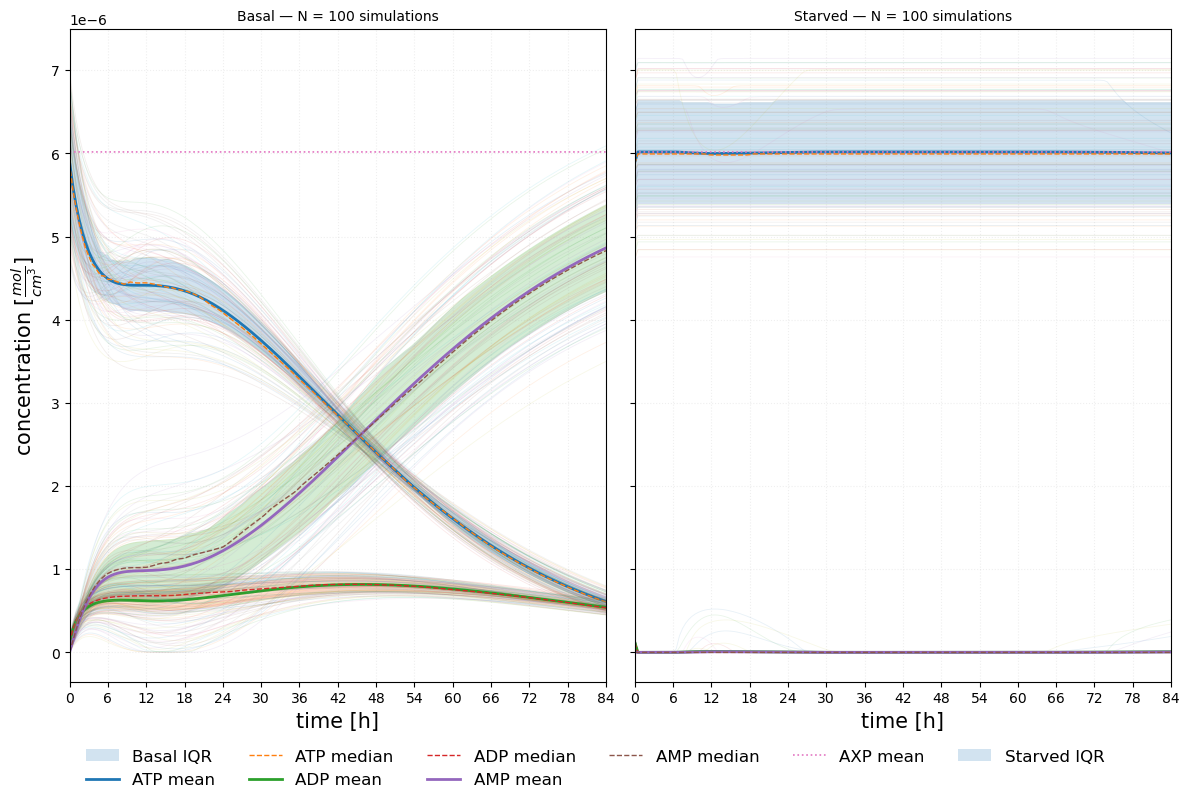

In [74]:
from typing import Dict, Iterable, Optional, Tuple

def _normalize_species(species):
    if isinstance(species, str):
        return (species,)
    return tuple(species)

def _stack_runs(df_dict, species, n_expected=None):
    species = _normalize_species(species)
    max_idx = max(df.index.max() for df in df_dict.values())
    if n_expected is not None:
        max_idx = max(max_idx, n_expected)
    idx = pd.RangeIndex(1, max_idx + 1)

    mats = []
    for _, df in df_dict.items():
        tmp = (df.sort_index()
                 .reindex(idx)
                 .apply(pd.to_numeric, errors='coerce')
                 .ffill().bfill())
        if set(species).issubset(tmp.columns):
            mats.append(tmp.loc[:, list(species)].to_numpy())
    if not mats:
        raise ValueError(f"No runs contained the requested species: {species}")
    return idx, np.stack(mats, axis=0)

def _summary(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    q10 = np.quantile(X, 0.10, axis=0)
    q25 = np.quantile(X, 0.25, axis=0)
    med = np.quantile(X, 0.50, axis=0)
    q75 = np.quantile(X, 0.75, axis=0)
    q90 = np.quantile(X, 0.90, axis=0)
    mean = X.mean(axis=0)
    return q10, q25, med, q75, q90, mean

def _spread(y_values, min_gap):
    """
    Given a list of y positions, return adjusted positions so that
    consecutive labels are at least `min_gap` apart (in data units),
    while preserving ordering as much as possible.
    """
    y = np.array(y_values, dtype=float)
    order = np.argsort(y)
    y_sorted = y[order]

    adj = np.empty_like(y_sorted)
    prev = -np.inf
    for i, val in enumerate(y_sorted):
        if val <= prev + min_gap:
            adj[i] = prev + min_gap
        else:
            adj[i] = val
        prev = adj[i]

    result = np.empty_like(adj)
    result[order] = adj
    return result

def plot_compare_summary(
    df_dict_a: Dict[str, pd.DataFrame],
    df_dict_b: Dict[str, pd.DataFrame],
    label_a: str = 'cond A',
    label_b: str = 'cond B',
    species=('ATP','ADP','AMP'),
    dt_minutes=30,
    total_hours=84,
    # ---- layout switch ----
    layout_mode: str = "species",   # "species" | "condition"
    # ---- stat controls ----
    show_iqr: bool = True,
    show_p80: bool = False,
    show_mean: bool = True,
    show_median: bool = False,
    sample_trajs: int = 0,          # 0 -> no thin trajectories
    traj_alpha: float = 0.10,
    band_alpha_iqr: float = 0.20,
    band_alpha_p80: float = 0.10,
    legend_pos: str = "below",      # "below" | "above" | "inside"
    # -----------------------
    show_axp: bool = True,          # only used if plotting the AXP trio
    figsize=(12, 8),
    curve_labels: bool = False
):
    """
    Compare conditions A vs B for the given species.

    layout_mode = "species":
        One subplot per species. Each subplot shows both conditions.
        `curve_labels` annotates the two condition curves near t=0.

    layout_mode = "condition":
        Two subplots (A, B). Each subplot shows all species for that condition.
        `curve_labels` is ignored (the condition is already in the title).

    All other options (IQR, 10–90%, mean, median, sample trajectories, legend,
    AXP overlay, Sejeong data overlay) remain available.
    """
    if layout_mode not in {"species", "condition"}:
        raise ValueError('layout_mode must be "species" or "condition".')

    species = _normalize_species(species)
    n_expected = int(total_hours*60/dt_minutes + 1)

    # stack & summarize
    idx_a, Xa = _stack_runs(df_dict_a, species, n_expected)  # [runs, time, species]
    idx_b, Xb = _stack_runs(df_dict_b, species, n_expected)
    t_h_a = (idx_a.values - 1) * dt_minutes / 60.0
    t_h_b = (idx_b.values - 1) * dt_minutes / 60.0

    qa10, qa25, qamed, qa75, qa90, qamean = _summary(Xa)
    qb10, qb25, qbmed, qb75, qb90, qbmean = _summary(Xb)

    # prepare sampling of individual trajectories
    rng = np.random.default_rng(0)
    samp_a = rng.choice(Xa.shape[0], size=min(sample_trajs, Xa.shape[0]), replace=False) if sample_trajs else []
    samp_b = rng.choice(Xb.shape[0], size=min(sample_trajs, Xb.shape[0]), replace=False) if sample_trajs else []

    # ---------------- LAYOUT 1: one subplot per species ----------------
    if layout_mode == "species":
        fig, axes = plt.subplots(1, len(species), figsize=figsize, sharex=True)
        if len(species) == 1:
            axes = [axes]

        for si, sp in enumerate(species):
            ax = axes[si]

            # optional thin single-run trajectories
            for ridx in samp_a:
                ax.plot(t_h_a, Xa[ridx, :, si], lw=0.6, alpha=traj_alpha)
            for ridx in samp_b:
                ax.plot(t_h_b, Xb[ridx, :, si], lw=0.6, alpha=traj_alpha)

            # condition A bands
            if show_p80:
                ax.fill_between(t_h_a, qa10[:, si], qa90[:, si],
                                alpha=band_alpha_p80, linewidth=0, label=f'{label_a} 10–90%')
            if show_iqr:
                ax.fill_between(t_h_a, qa25[:, si], qa75[:, si],
                                alpha=band_alpha_iqr, linewidth=0, label=f'{label_a} IQR')

            # condition B bands
            if show_p80:
                ax.fill_between(t_h_b, qb10[:, si], qb90[:, si],
                                alpha=band_alpha_p80, linewidth=0, label=f'{label_b} 10–90%')
            if show_iqr:
                ax.fill_between(t_h_b, qb25[:, si], qb75[:, si],
                                alpha=band_alpha_iqr, linewidth=0, label=f'{label_b} IQR')

            # add labels near t=0 for each species panel
            if curve_labels:
                y0_a = qamean[0, si]
                y0_b = qbmean[0, si]
                ax.text(-2.5, y0_a, f"{label_a}", color='tab:blue',
                        va='center', ha='right', fontsize=12, weight='bold')
                ax.text(-2.5, y0_b, f"{label_b}", color='tab:orange',
                        va='center', ha='right', fontsize=12, weight='bold')

            # central tendency lines
            if show_mean:
                ax.plot(t_h_a, qamean[:, si], lw=2, label=f'{label_a} mean')
                ax.plot(t_h_b, qbmean[:, si], lw=2, label=f'{label_b} mean')
            if show_median:
                ax.plot(t_h_a, qamed[:, si], lw=1, linestyle='--', label=f'{label_a} median')
                ax.plot(t_h_b, qbmed[:, si], lw=1, linestyle='--', label=f'{label_b} median')

            # axis cosmetics
            ax.set_title(f"Time Profile of {sp} Dynamics - N = {Xa.shape[0]} Simulations", fontsize=10)
            ax.set_xlim(0, total_hours)
            ax.set_xticks(np.arange(0, total_hours+0.1, 6))
            if si == 0:
                ax.set_ylabel(r'concentration $[\frac{mol}{cm^{3}}]$', fontsize=15)
            ax.set_xlabel('time [h]', fontsize=15)
            ax.grid(alpha=0.2, linestyle=':')

            # optional Sejeong glucose data overlay
            if sp == 'GLUCOUT' and (label_a == 'Starved' or label_b == 'Starved'):
                ax.errorbar(
                    sejeong_gluc.t,
                    sejeong_gluc.y,
                    yerr=sejeong_gluc.sigma,
                    fmt='x',
                    capsize=5,
                    lw=1.8,
                    markersize=5,
                    color='tab:red',
                    ecolor='tab:red',
                    elinewidth=2,
                    alpha=0.9
                )

    # ---------------- LAYOUT 2: one subplot per condition ----------------
    else:  # layout_mode == "condition"
        fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)

        # helper to draw one condition panel
        def _plot_condition_panel(ax, t_h, X, q10, q25, qmed, q75, q90, qmean,
                                  samp_idx, cond_label):
            first_for_stat = True  # avoid duplicate legend labels for bands *within this panel*
            for si, sp in enumerate(species):
                # thin individual trajectories
                for ridx in samp_idx:
                    ax.plot(t_h, X[ridx, :, si], lw=0.6, alpha=traj_alpha)

                # bands
                if show_p80:
                    ax.fill_between(
                        t_h, q10[:, si], q90[:, si],
                        alpha=band_alpha_p80, linewidth=0,
                        label=f'{cond_label} 10–90%' if first_for_stat else None
                    )
                if show_iqr:
                    ax.fill_between(
                        t_h, q25[:, si], q75[:, si],
                        alpha=band_alpha_iqr, linewidth=0,
                        label=f'{cond_label} IQR' if first_for_stat and not show_p80 else None
                    )

                # central tendency per species
                if show_mean:
                    ax.plot(t_h, qmean[:, si], lw=2, label=f'{sp} mean')
                if show_median:
                    ax.plot(t_h, qmed[:, si], lw=1, linestyle='--', label=f'{sp} median')

                first_for_stat = False

            ax.set_title(f"{cond_label} — N = {X.shape[0]} simulations", fontsize=10)
            ax.set_xlim(0, total_hours)
            ax.set_xticks(np.arange(0, total_hours+0.1, 6))
            ax.set_xlabel('time [h]', fontsize=15)
            ax.grid(alpha=0.2, linestyle=':')

        _plot_condition_panel(axes[0], t_h_a, Xa, qa10, qa25, qamed, qa75, qa90, qamean, samp_a, label_a)
        _plot_condition_panel(axes[1], t_h_b, Xb, qb10, qb25, qbmed, qb75, qb90, qbmean, samp_b, label_b)

        axes[0].set_ylabel(r'concentration $[\frac{mol}{cm^{3}}]$', fontsize=15)

        # optional AXP overlay in condition layout too
        if show_axp and set(species) == {'ATP','ADP','AMP'}:
            axes[0].plot(t_h_a, qamean.sum(axis=1), lw=1.2, linestyle=':', label='AXP mean')
            axes[1].plot(t_h_b, qbmean.sum(axis=1), lw=1.2, linestyle=':', label='AXP mean')

    # -------- shared legend placement (both layouts) --------
    if layout_mode == "condition":
        # collect handles from BOTH axes so Basal + Starved bands all appear
        h0, l0 = axes[0].get_legend_handles_labels()
        h1, l1 = axes[1].get_legend_handles_labels()
        handles, labels = list(h0), list(l0)
        for h, lab in zip(h1, l1):
            if lab not in labels:
                handles.append(h)
                labels.append(lab)
    else:
        handles, labels = axes[0].get_legend_handles_labels()

    if legend_pos == "below":
        fig.legend(handles, labels, frameon=False, loc='lower center',
                   bbox_to_anchor=(0.5, -0.01), ncol=6, fontsize=12)
        fig.tight_layout(rect=[0, 0.06, 1, 1])
    elif legend_pos == "above":
        fig.legend(handles, labels, frameon=False, loc='upper center',
                   bbox_to_anchor=(0.5, 1.15), ncol=6, fontsize=12)
        fig.tight_layout(rect=[0, 0, 1, 0.94])
    else:  # inside (previous behavior)
        axes[-1].legend(handles, labels, frameon=False, loc='upper right')
        fig.tight_layout()

    fig.patch.set_facecolor('white')
    return fig


fig = plot_compare_summary(
    df_dict_a=mechs['starve'].orig_time_sim_df,
    df_dict_b=mechs['stac'].orig_time_sim_df,
    label_a='Basal', label_b='Starved',
    species=('ATP','ADP', 'AMP'),
    layout_mode="condition",          # default; optional
    show_iqr=True, show_p80=False,
    show_mean=True, show_median=True,
    sample_trajs=100, legend_pos="below",
    curve_labels=True
)


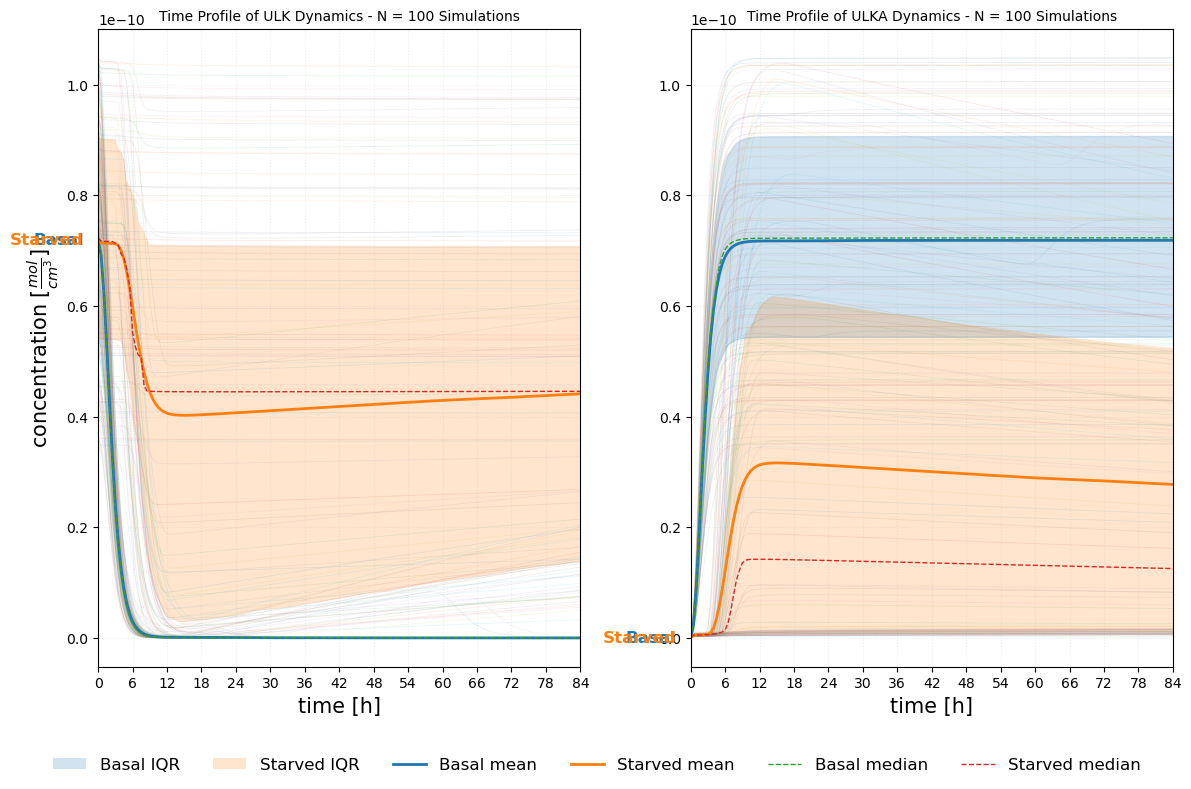

In [57]:
from typing import Dict, Iterable, Optional, Tuple

def _normalize_species(species):
    if isinstance(species, str):
        return (species,)
    return tuple(species)

def _stack_runs(df_dict, species, n_expected=None):
    species = _normalize_species(species)
    max_idx = max(df.index.max() for df in df_dict.values())
    if n_expected is not None:
        max_idx = max(max_idx, n_expected)
    idx = pd.RangeIndex(1, max_idx + 1)

    mats = []
    for _, df in df_dict.items():
        tmp = (df.sort_index()
                 .reindex(idx)
                 .apply(pd.to_numeric, errors='coerce')
                 .ffill().bfill())
        if set(species).issubset(tmp.columns):
            mats.append(tmp.loc[:, list(species)].to_numpy())
    if not mats:
        raise ValueError(f"No runs contained the requested species: {species}")
    return idx, np.stack(mats, axis=0)

def _summary(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    q10 = np.quantile(X, 0.10, axis=0)
    q25 = np.quantile(X, 0.25, axis=0)
    med = np.quantile(X, 0.50, axis=0)
    q75 = np.quantile(X, 0.75, axis=0)
    q90 = np.quantile(X, 0.90, axis=0)
    mean = X.mean(axis=0)
    return q10, q25, med, q75, q90, mean

def _spread(y_values, min_gap):
    """
    Given a list of y positions, return adjusted positions so that
    consecutive labels are at least `min_gap` apart (in data units),
    while preserving ordering as much as possible.
    """
    y = np.array(y_values, dtype=float)
    order = np.argsort(y)
    y_sorted = y[order]

    adj = np.empty_like(y_sorted)
    prev = -np.inf
    for i, val in enumerate(y_sorted):
        if val <= prev + min_gap:
            adj[i] = prev + min_gap
        else:
            adj[i] = val
        prev = adj[i]

    result = np.empty_like(adj)
    result[order] = adj
    return result


def plot_compare_summary(
    df_dict_a: Dict[str, pd.DataFrame],
    df_dict_b: Dict[str, pd.DataFrame],
    label_a: str = 'cond A',
    label_b: str = 'cond B',
    species=('ATP','ADP','AMP'),
    dt_minutes=30,
    total_hours=84,
    # ---- layout switch ----
    layout_mode: str = "species",   # "species" | "condition"
    # ---- stat controls ----
    show_iqr: bool = True,
    show_p80: bool = False,
    show_mean: bool = True,
    show_median: bool = False,
    sample_trajs: int = 0,          # 0 -> no thin trajectories
    traj_alpha: float = 0.10,
    band_alpha_iqr: float = 0.20,
    band_alpha_p80: float = 0.10,
    legend_pos: str = "below",      # "below" | "above" | "inside"
    # -----------------------
    show_axp: bool = True,          # only used if plotting the AXP trio
    figsize=(12, 8),
    curve_labels: bool = False,
    curve_label_min_gap_frac: float = 0.02,
    curve_label_xpad: float = -3.0,
    curve_label_connectors: bool = True,
):
    """
    Compare conditions A vs B for the given species.

    layout_mode = "species":
        One subplot per species. Each subplot shows both conditions.
        `curve_labels` annotates the two condition curves near t=0.

    layout_mode = "condition":
        Two subplots (A, B). Each subplot shows all species for that condition.
        If `curve_labels` is True and `show_mean` is True, species names are
        written to the left of each panel, vertically spaced using `_spread`.
    """
    if layout_mode not in {"species", "condition"}:
        raise ValueError('layout_mode must be "species" or "condition".')

    species = _normalize_species(species)
    n_expected = int(total_hours*60/dt_minutes + 1)

    # stack & summarize
    idx_a, Xa = _stack_runs(df_dict_a, species, n_expected)  # [runs, time, species]
    idx_b, Xb = _stack_runs(df_dict_b, species, n_expected)
    t_h_a = (idx_a.values - 1) * dt_minutes / 60.0
    t_h_b = (idx_b.values - 1) * dt_minutes / 60.0

    qa10, qa25, qamed, qa75, qa90, qamean = _summary(Xa)
    qb10, qb25, qbmed, qb75, qb90, qbmean = _summary(Xb)

    # prepare sampling of individual trajectories
    rng = np.random.default_rng(0)
    samp_a = rng.choice(Xa.shape[0], size=min(sample_trajs, Xa.shape[0]), replace=False) if sample_trajs else []
    samp_b = rng.choice(Xb.shape[0], size=min(sample_trajs, Xb.shape[0]), replace=False) if sample_trajs else []

    # ---------------- LAYOUT 1: one subplot per species ----------------
    if layout_mode == "species":
        fig, axes = plt.subplots(1, len(species), figsize=figsize, sharex=True)
        if len(species) == 1:
            axes = [axes]

        for si, sp in enumerate(species):
            ax = axes[si]

            # optional thin single-run trajectories
            for ridx in samp_a:
                ax.plot(t_h_a, Xa[ridx, :, si], lw=0.6, alpha=traj_alpha)
            for ridx in samp_b:
                ax.plot(t_h_b, Xb[ridx, :, si], lw=0.6, alpha=traj_alpha)

            # condition A bands
            if show_p80:
                ax.fill_between(t_h_a, qa10[:, si], qa90[:, si],
                                alpha=band_alpha_p80, linewidth=0, label=f'{label_a} 10–90%')
            if show_iqr:
                ax.fill_between(t_h_a, qa25[:, si], qa75[:, si],
                                alpha=band_alpha_iqr, linewidth=0, label=f'{label_a} IQR')

            # condition B bands
            if show_p80:
                ax.fill_between(t_h_b, qb10[:, si], qb90[:, si],
                                alpha=band_alpha_p80, linewidth=0, label=f'{label_b} 10–90%')
            if show_iqr:
                ax.fill_between(t_h_b, qb25[:, si], qb75[:, si],
                                alpha=band_alpha_iqr, linewidth=0, label=f'{label_b} IQR')

            # add labels near t=0 for each species panel (conditions)
            if curve_labels:
                y0_a = qamean[0, si]
                y0_b = qbmean[0, si]
                ax.text(-2.5, y0_a, f"{label_a}", color='tab:blue',
                        va='center', ha='right', fontsize=12, weight='bold')
                ax.text(-2.5, y0_b, f"{label_b}", color='tab:orange',
                        va='center', ha='right', fontsize=12, weight='bold')

            # central tendency lines
            if show_mean:
                ax.plot(t_h_a, qamean[:, si], lw=2, label=f'{label_a} mean')
                ax.plot(t_h_b, qbmean[:, si], lw=2, label=f'{label_b} mean')
            if show_median:
                ax.plot(t_h_a, qamed[:, si], lw=1, linestyle='--', label=f'{label_a} median')
                ax.plot(t_h_b, qbmed[:, si], lw=1, linestyle='--', label=f'{label_b} median')

            # axis cosmetics
            ax.set_title(f"Time Profile of {sp} Dynamics - N = {Xa.shape[0]} Simulations", fontsize=10)
            ax.set_xlim(0, total_hours)
            ax.set_xticks(np.arange(0, total_hours+0.1, 6))
            if si == 0:
                ax.set_ylabel(r'concentration $[\frac{mol}{cm^{3}}]$', fontsize=15)
            ax.set_xlabel('time [h]', fontsize=15)
            ax.grid(alpha=0.2, linestyle=':')

            # optional Sejeong glucose data overlay
            if sp == 'GLUCOUT' and (label_a == 'Starved' or label_b == 'Starved'):
                ax.errorbar(
                    sejeong_gluc.t,
                    sejeong_gluc.y,
                    yerr=sejeong_gluc.sigma,
                    fmt='x',
                    capsize=5,
                    lw=1.8,
                    markersize=5,
                    color='tab:red',
                    ecolor='tab:red',
                    elinewidth=2,
                    alpha=0.9
                )

    # ---------------- LAYOUT 2: one subplot per condition ----------------
    else:  # layout_mode == "condition"
        fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)

        # helper to draw one condition panel
        def _plot_condition_panel(ax, t_h, X, q10, q25, qmed, q75, q90, qmean,
                                  samp_idx, cond_label):
            first_for_stat = True  # avoid duplicate legend labels for bands *within this panel*
            sp_colors = {}

            for si, sp in enumerate(species):
                # thin individual trajectories
                for ridx in samp_idx:
                    ax.plot(t_h, X[ridx, :, si], lw=0.6, alpha=traj_alpha)

                # bands (same color cycle for all species; condition coded by label)
                if show_p80:
                    ax.fill_between(
                        t_h, q10[:, si], q90[:, si],
                        alpha=band_alpha_p80, linewidth=0,
                        label=f'{cond_label} 10–90%' if first_for_stat else None
                    )
                if show_iqr:
                    ax.fill_between(
                        t_h, q25[:, si], q75[:, si],
                        alpha=band_alpha_iqr, linewidth=0,
                        label=f'{cond_label} IQR' if first_for_stat and not show_p80 else None
                    )

                # central tendency per species (store color for labels)
                if show_mean:
                    line = ax.plot(t_h, qmean[:, si], lw=2, label=f'{sp} mean')
                    sp_colors[sp] = line[0].get_color()
                if show_median:
                    ax.plot(t_h, qmed[:, si], lw=1, linestyle='--', label=f'{sp} median')

                first_for_stat = False

            ax.set_title(f"{cond_label} — N = {X.shape[0]} simulations", fontsize=10)
            ax.set_xlim(0, total_hours)
            ax.set_xticks(np.arange(0, total_hours+0.1, 6))
            ax.set_xlabel('time [h]', fontsize=15)
            ax.grid(alpha=0.2, linestyle=':')

            # left species labels (only if mean curves exist)
            if curve_labels and show_mean:
                y0s = [qmean[0, si] for si in range(len(species))]
                y_min, y_max = ax.get_ylim()
                y_range = max(1e-12, (y_max - y_min))
                y_labs = _spread(y0s, curve_label_min_gap_frac * y_range)

                x_min, x_max = ax.get_xlim()
                ax.set_xlim(min(curve_label_xpad, x_min), x_max)

                for sp, y_lab, y_true in zip(species, y_labs, y0s):
                    col = sp_colors.get(sp, 'black')
                    ax.text(curve_label_xpad, y_lab, sp,
                            color=col, va='center', ha='right',
                            fontsize=12, weight='bold')
                    if curve_label_connectors:
                        ax.plot([curve_label_xpad + 0.2, 0],
                                [y_lab, y_true],
                                lw=0.8, alpha=0.6, color=col,
                                label='_nolegend_')

        _plot_condition_panel(axes[0], t_h_a, Xa, qa10, qa25, qamed, qa75, qa90, qamean, samp_a, label_a)
        _plot_condition_panel(axes[1], t_h_b, Xb, qb10, qb25, qbmed, qb75, qb90, qbmean, samp_b, label_b)

        axes[0].set_ylabel(r'concentration $[\frac{mol}{cm^{3}}]$', fontsize=15)

        # optional AXP overlay in condition layout too
        if show_axp and set(species) == {'ATP','ADP','AMP'}:
            axes[0].plot(t_h_a, qamean.sum(axis=1), lw=1.2, linestyle=':', label='AXP mean')
            axes[1].plot(t_h_b, qbmean.sum(axis=1), lw=1.2, linestyle=':', label='AXP mean')

    # -------- shared legend placement (both layouts) --------
    if layout_mode == "condition":
        # collect handles from BOTH axes so Basal + Starved bands all appear
        h0, l0 = axes[0].get_legend_handles_labels()
        h1, l1 = axes[1].get_legend_handles_labels()
        handles, labels = list(h0), list(l0)
        for h, lab in zip(h1, l1):
            if lab not in labels:
                handles.append(h)
                labels.append(lab)
    else:
        handles, labels = axes[0].get_legend_handles_labels()

    if legend_pos == "below":
        fig.legend(handles, labels, frameon=False, loc='lower center',
                   bbox_to_anchor=(0.5, -0.01), ncol=6, fontsize=12)
        fig.tight_layout(rect=[0, 0.06, 1, 1])
    elif legend_pos == "above":
        fig.legend(handles, labels, frameon=False, loc='upper center',
                   bbox_to_anchor=(0.5, 1.15), ncol=6, fontsize=12)
        fig.tight_layout(rect=[0, 0, 1, 0.94])
    else:  # inside (previous behavior)
        axes[-1].legend(handles, labels, frameon=False, loc='upper right')
        fig.tight_layout()

    fig.patch.set_facecolor('white')
    return fig

fig = plot_compare_summary(
    df_dict_a=mechs['starve'].orig_time_sim_df,
    df_dict_b=mechs['stac'].orig_time_sim_df,
    label_a='Basal', label_b='Starved',
    species=('ULK', 'ULKA'),
    layout_mode="species",
    show_iqr=True, show_p80=False,
    show_mean=True, show_median=True,
    sample_trajs=100,
    legend_pos="below",
    curve_labels=True,
    curve_label_min_gap_frac=1.02,
    curve_label_xpad=-3.0,
    curve_label_connectors=True,
)


In [ ]:
must_be_zero = ['RAP', 'RK', 'RKMTORA', 'RAPOUT']
mod = Model(model_name='gluc_rap_mTOR', ics_df_path='../input_files/species_ics_ranges.csv',
            dont_observe=proc.not_observables, time_points=t, time_course_vals=7e-10,
            uncertainty=True, must_be_zero=must_be_zero, inputs={'GLUCOUT': exp_food},
            food=food)

In [ ]:
gen = Genesis(mod, max_digit=4)
gen.create_xml_files(output_xmls_path=f'/home/nvme/Opt/7_Krisztian/xml/testing_{food}',
                     num_of_xmls=1000,
                     xml_template_path='../input_files/std_xml_template.xml',
                     prefix=food, kiir=False)

In [ ]:
date = datetime.datetime.now()
sim = Simulation(gen, 1000)
date_prefix = f"{date.year}{date.month}{date.day}"
sim.opp_gen(opp_output_dir='/home/nvme/Opt/7_Krisztian/1_mechtest',
            opp_name_prefix=f'{date_prefix}fail_testing_{food}',
            kiir=False, mech_file='7_Krisztian/mech/Minimal_gluc_rap_mTOR_v1.inp',
            food=food)

In [ ]:
sim.opps

In [ ]:
mech_test = OptimaMechtest(job_name="20251110fail_testing_stac_1000.opp",
                      input_mech='Minimal_gluc_rap_mTOR_v1')

In [ ]:
mech_v1 = OptimaMechtest(job_name="20251110_testing_starve_1000.opp",
                      input_mech='Minimal_gluc_rap_mTOR_v1')

In [ ]:
# Plotting helpers
t = np.arange(0, 4410, 90)
tick_interval = 360  # in minutes
xticks = np.arange(0, max(t) + tick_interval, tick_interval)
xticklabels = [f"{int(x/60)} h" for x in xticks]  # convert minutes → hours

In [ ]:
sejeong_gluc = pd.read_csv('../input_files/sejeong_gluc_cc_starve.csv')
sejeong_gluc.t = sejeong_gluc.t * 60
sejeong_gluc.y = sejeong_gluc.y * 1e-6
sejeong_gluc.sigma = sejeong_gluc.sigma * 1e-6
sejeong_gluc

In [ ]:
# assuming your DataFrame has columns: 't' (time), 'y' (value), and 'sigma' (std)
plt.figure(figsize=(5.5, 3.5))

plt.errorbar(
    sejeong_gluc.t / 60,             # x-values
    sejeong_gluc.y,             # y-values
    yerr=sejeong_gluc.sigma,    # error bars
    fmt='x',                   # circles with line
    capsize=4,                  # small caps on error bars
    lw=1.8,                     # line width
    markersize=5,
    color='tab:blue',
    ecolor='tab:blue',          # color of error bars
    elinewidth=1,
    alpha=0.9
)

plt.xlabel('time [min]')
plt.ylabel('concentration [mol/cm³]')
plt.title('Sejeong glucose time course (starve)')
plt.grid(alpha=0.2, linestyle=':')
plt.tight_layout()
plt.show()

In [ ]:
mechs['starve'].orig_time_sim_df['starve_0001']

In [ ]:
plt.plot(mechs['starve'].orig_time_sim_df['starve_0061'].ULK, label='ULK')
plt.plot(mechs['starve'].orig_time_sim_df['starve_0061'].ULKA, label='ULK')
plt.plot(mechs['starve'].orig_time_sim_df['starve_0061'].MTOR, label='MTOR')
plt.plot(mechs['starve'].orig_time_sim_df['starve_0061'].MTORA, label='MTORA')
plt.legend()

In [ ]:
for k, v in mechs['stac'].orig_time_sim_df.items():
    plt.plot(t, v.AMPK_ATP)
    plt.plot(t, v.AMPK_ADP)
    plt.plot(t, v.AMPK_AMP)
plt.xticks(xticks, xticklabels)
plt.tight_layout()

In [ ]:
for k, v in mechs['stac'].orig_time_sim_df.items():
    plt.plot(t, v.ATP)
    plt.plot(t, v.ADP)
    plt.plot(t, v.AMP)
plt.xticks(xticks, xticklabels)
plt.tight_layout()
#plt.plot(sejeong_gluc.t, sejeong_gluc.y, label='exp_data')
#plt.legend()

In [ ]:
data_to_plot_dict = {}
mech_starve = OptimaMechtest(job_name="2025119_testing_starve.opp",
                      input_mech='Minimal_gluc_rap_mTOR_v1')
data_to_plot_dict['starve'] = mech_starve.orig_time_sim_df['starve_0874']
mech_stac = OptimaMechtest(job_name="2025119_testing_stac.opp",
                      input_mech='Minimal_gluc_rap_mTOR_v1')
data_to_plot_dict['stac'] = mech_stac.orig_time_sim_df['stac_0874']

In [ ]:
holczer_starve = pd.read_csv('../input_files/Holczer_starving.csv')
scaler = {'mTORa': data_to_plot_dict['starve']['MTORA'].iloc[0],
          'ULKa': data_to_plot_dict['starve']['ULK'].iloc[0],
          'AMPKa': data_to_plot_dict['starve']['AMPK'].iloc[0]}
xticks = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
xticklabels = ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24']
for col in holczer_starve.columns:
    if 'std' not in col and 'time' not in col and 'AUT' not in col:
        plt.errorbar(holczer_starve.time, holczer_starve[col] * scaler[col],
                     yerr=holczer_starve[f"{col}std"] * scaler[col], fmt='-o', capsize=4,
                     elinewidth=1.2, markeredgewidth=1.2, label=col)
plt.legend()
plt.xticks(xticks, xticklabels)
print(scaler)

In [ ]:
data_to_plot_dict = {}
mech_starve = OptimaMechtest(job_name="2025119_testing_starve.opp",
                      input_mech='Minimal_gluc_rap_mTOR_v1')
data_to_plot_dict['starve'] = mech_starve.orig_time_sim_df['starve_0874']
mech_stac = OptimaMechtest(job_name="2025119_testing_stac.opp",
                      input_mech='Minimal_gluc_rap_mTOR_v1')
data_to_plot_dict['stac'] = mech_stac.orig_time_sim_df['stac_0874']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    glucin_0 = data_to_plot_dict[key]['GLUCIN'].iloc[0]
    glucout_0 = data_to_plot_dict[key]['GLUCOUT'].iloc[0]
    for col in data_to_plot_dict[key].columns:
        if col in ['GLUCIN', 'GLUCOUT']:
            ax.plot(t, data_to_plot_dict[key][col], label=col)
    if glucout_0 <= 1e-6:
        ax.plot(sejeong_gluc.t, sejeong_gluc.y, label='GLUCOUT_exp')

    ax.legend()
    ax.set_title(f"Glucose Dynamics - {key}: gluci_0 = {glucin_0:.2e}, gluco_0={glucout_0:.2e}")
    ax.set_xlabel("time [min]")
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")
    ax.set_xticks(xticks, xticklabels)

plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    glucin_0 = data_to_plot_dict[key]['GLUCIN'].iloc[0]
    glucout_0 = data_to_plot_dict[key]['GLUCOUT'].iloc[0]
    for col in data_to_plot_dict[key].columns:
        if col in ['ATP', 'ADP', 'AMP']:
            ax.plot(t, data_to_plot_dict[key][col], label=col)
    all_AXP = data_to_plot_dict[key].ATP + data_to_plot_dict[key].ADP + data_to_plot_dict[key].AMP
    ax.plot(t, all_AXP, 'k--', label='AXP')

    ax.legend()
    ax.set_title(f"AXP Dynamics - {key}: gluci_0 = {glucin_0:.2e}, gluco_0={glucout_0:.2e}")
    ax.set_xlabel("time [min]")  # use ax.set_xlabel() instead of plt.xlabel()
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")  # use ax.set_ylabel()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

plt.tight_layout()
plt.show()

In [ ]:
data_to_plot_dict['starve'].GLUCIN

In [ ]:
plt.plot(t, data_to_plot_dict['starve'].GLUCIN, label='sim_val')
plt.plot(t, np.ones(data_to_plot_dict['starve'].GLUCIN.shape)*8.5e-08, label='min_phys_val')
plt.title('Intracellular Glucose Concentration')
plt.legend()
plt.xticks(xticks, xticklabels)
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    glucin_0 = data_to_plot_dict[key]['GLUCIN'].iloc[0]
    glucout_0 = data_to_plot_dict[key]['GLUCOUT'].iloc[0]
    for col in data_to_plot_dict[key].columns:
        if col in ['ATP', 'ADP', 'AMP']:
            ax.plot(t, data_to_plot_dict[key][col], label=col)
    all_AXP = data_to_plot_dict[key].ATP + data_to_plot_dict[key].ADP + data_to_plot_dict[key].AMP
    ax.plot(t, all_AXP, 'k--', label='AXP')

    ax.legend()
    ax.set_title(f"AXP Dynamics - {key}: gluci_0 = {glucin_0:.2e}, gluco_0={glucout_0:.2e}")
    ax.set_xlabel("time [min]")  # use ax.set_xlabel() instead of plt.xlabel()
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")  # use ax.set_ylabel()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    glucin_0 = data_to_plot_dict[key]['GLUCIN'].iloc[0]
    glucout_0 = data_to_plot_dict[key]['GLUCOUT'].iloc[0]
    for col in data_to_plot_dict[key].columns:
        if 'AMPK' in col and 'LKB1' not in col and 'PP2A' not in col:
            ax.plot(t, data_to_plot_dict[key][col], label=col)

    ax.legend()
    ax.set_title(f"AMPK Dynamics - {key}: gluci_0 = {glucin_0:.2e}, gluco_0={glucout_0:.2e}")
    ax.set_xlabel("time [min]")
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")
    ax.set_xticks(xticks, xticklabels)

plt.tight_layout()
plt.show()

ATP-AMPK and thus inactive AMPK begins to drop real quick bc ATP begins to decrease real quick as well:
1. Physically speaking, then, ATPs bound to AMPK molecules begin to dissociate bc the cytosolic free ATP cc. begins to decrease and therefore, binding is no longer favoured
2. Computationally, since AMPK-AXP binding is implemented by MM kinetics, when free (cytosolic) ATP cc. drops below the K_m association constant --> ATP no longer binds AMPK
3. Biologically, active, i.e., ADP or AMP bound AMPK cc. rises bc the cell goes into survival mode and downregs anabolic while upregs catabolic processes --> it tries autophagy

Additionally:

- On the left, we can note that the fact that in the beginning ADP-AMPKA is dominant over AMP-AMPK agrees with other in silico models and experiments in active muscle tissue, where it's been shown (coccimiglio et al.) that under physiological levels, ADP is more important in AMPK activation as the cc. of AMP is real low. However, once starvation really begins and AMP cc. skyrockets --> it becomes apparent (in experiments) that AMP is a several fold stronger activator of AMPK than ADP is (this is due to allosteric activation as well as the stabilization of the active AMPK enzyme - this latter is exactly what is achieved by ADP as well)
- On the right, again, AMPK-AMP is not as elevated as AMPK-ADP, bc the cc of ADP is much bigger and thus ADP is the dominant activator of AMPK
## COOL!

In [ ]:
data_to_plot_dict = {}
mech_starve = OptimaMechtest(job_name="2025119_testing_starve.opp",
                      input_mech='Minimal_gluc_rap_mTOR_v1')
data_to_plot_dict['starve'] = mech_starve.orig_time_sim_df['starve_0874']
mech_stac = OptimaMechtest(job_name="2025119_testing_stac.opp",
                      input_mech='Minimal_gluc_rap_mTOR_v1')
data_to_plot_dict['stac'] = mech_stac.orig_time_sim_df['stac_0874']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    glucin_0 = data_to_plot_dict[key]['GLUCIN'].iloc[0]
    glucout_0 = data_to_plot_dict[key]['GLUCOUT'].iloc[0]
    for col in data_to_plot_dict[key].columns:
        if 'AMPK' in col and 'LKB1' not in col and 'PP2A' not in col:
            ax.plot(t, data_to_plot_dict[key][col], label=col)

    ax.legend()
    ax.set_title(f"Glucose Dynamics - {key}: gluci_0 = {glucin_0:.2e}, gluco_0={glucout_0:.2e}")
    ax.set_xlabel("time [min]")
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")
    ax.set_xticks(xticks, xticklabels)

plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    glucin_0 = data_to_plot_dict[key]['GLUCIN'].iloc[0]
    glucout_0 = data_to_plot_dict[key]['GLUCOUT'].iloc[0]
    for col in data_to_plot_dict[key].columns:
        if 'MTOR' in col or 'ULK' in col:# or 'ULK' in col or 'TSC' in col or 'RHEB' in col or 'AKT' in col:
            ax.plot(t, data_to_plot_dict[key][col], label=col)

    ax.legend()
    ax.set_title(f"mTOR-ULK Dynamics - {key}: gluci_0 = {glucin_0:.2e}, gluco_0={glucout_0:.2e}")
    ax.set_xlabel("time [min]")  # use ax.set_xlabel() instead of plt.xlabel()
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")  # use ax.set_ylabel()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

plt.tight_layout()
plt.show()

In [ ]:
data_to_plot_dict['stac'].MTORA

In [ ]:
mech_v1 = OptimaMechtest(job_name="2025119_testing_starve.opp",
                      input_mech='Minimal_gluc_rap_mTOR_v1')
data_to_plot = mech_v1.orig_time_sim_df['starve_0874']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax1 = axes[0]
ax2 = axes[1]

glucin_0 = data_to_plot['GLUCIN'].iloc[0]
glucout_0 = data_to_plot['GLUCOUT'].iloc[0]
for col in data_to_plot.columns:
    if 'MTOR' in col or 'ULK' in col or 'TSC' in col or 'RHEB' in col or 'AKT' in col:
        ax1.plot(t, data_to_plot[col], label=col)

ax1.legend()
ax1.set_title(f'AMPK Dynamics, with glucin_0 = {glucin_0:.2e}, glucout_0={glucout_0:.2e}')
ax1.set_xlabel("time [min]")
ax1.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")
ax1.set_xticks(xticks, xticklabels)
plt.tight_layout()

for col in data_to_plot.columns:
    if 'AMPK' in col and 'LKB1' not in col and 'PP2A' not in col:
        ax2.plot(t, data_to_plot[col], label=col)

ax2.legend()
ax2.set_title(f"AXP Dynamics, with glucin_0 = {glucin_0:.2e}, glucout_0={glucout_0:.2e}")
ax2.set_xlabel("time [min]")  # use ax.set_xlabel() instead of plt.xlabel()
ax2.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")  # use ax.set_ylabel()
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticklabels)
plt.tight_layout()
plt.show()

In [ ]:
mech_v1 = OptimaMechtest(job_name="2025119_testing_stac.opp",
                      input_mech='Minimal_gluc_rap_mTOR_v1')
data_to_plot = mech_v1.orig_time_sim_df['stac_0874']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax1 = axes[0]
ax2 = axes[1]

glucin_0 = data_to_plot['GLUCIN'].iloc[0]
glucout_0 = data_to_plot['GLUCOUT'].iloc[0]
for col in data_to_plot.columns:
    if 'MTOR' in col or 'ULK' in col or 'TSC' in col or 'RHEB' in col or 'AKT' in col:
        ax1.plot(t, data_to_plot[col], label=col)

ax1.legend()
ax1.set_title(f'AMPK Dynamics, with glucin_0 = {glucin_0:.2e}, glucout_0={glucout_0:.2e}')
ax1.set_xlabel("time [min]")
ax1.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")
ax1.set_xticks(xticks, xticklabels)
plt.tight_layout()

for col in data_to_plot.columns:
    if 'AMPK' in col and 'LKB1' not in col and 'PP2A' not in col:
        ax2.plot(t, data_to_plot[col], label=col)

ax2.legend()
ax2.set_title(f"AXP Dynamics, with glucin_0 = {glucin_0:.2e}, glucout_0={glucout_0:.2e}")
ax2.set_xlabel("time [min]")  # use ax.set_xlabel() instead of plt.xlabel()
ax2.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")  # use ax.set_ylabel()
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticklabels)
plt.tight_layout()
plt.show()

In [ ]:
write_inp(species_list=species2,
          out_path='/home/nvme/Opt/7_Krisztian/mech/dummy.inp')

In [ ]:
mech_orig = OptimaMechtest(job_name="2025119_stac_starve_rap2.opp",
                      input_mech='Minimal_gluc_rap_mTOR_v0')
data_to_plot_dict['rap_mTOR_orig'] = mech_orig.orig_time_sim_df['stac_0901']

In [ ]:
data_to_plot_dict.keys()

In [ ]:
mech = OptimaMechtest(job_name='2025119_stac_starve_rap.opp',
                      input_mech='Minimal_gluc_rap_mTOR_v0')

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    glucin_0 = data_to_plot_dict[key]['GLUCIN'].iloc[0]
    glucout_0 = data_to_plot_dict[key]['GLUCOUT'].iloc[0]
    for col in data_to_plot_dict[key].columns:
        if col in ['GLUCIN', 'GLUCOUT']:
            ax.plot(t, data_to_plot_dict[key][col], label=col)

    ax.legend()
    ax.set_title(key)
    ax.set_xlabel("time [min]")
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")
    ax.set_xticks(xticks, xticklabels)

plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    glucin_0 = data_to_plot_dict[key]['GLUCIN'].iloc[0]
    glucout_0 = data_to_plot_dict[key]['GLUCOUT'].iloc[0]
    for col in data_to_plot_dict[key].columns:
        if col in ['ATP', 'ADP', 'AMP']:
            ax.plot(t, data_to_plot_dict[key][col], label=col)
    all_AXP = data_to_plot_dict[key].ATP + data_to_plot_dict[key].ADP + data_to_plot_dict[key].AMP
    ax.plot(t, all_AXP, 'k--', label='AXP')

    ax.legend()
    ax.set_title(f"{key} glucin_0 = {glucin_0:.2e}, glucout_0={glucout_0:.2e}")
    ax.set_xlabel("time [min]")  # use ax.set_xlabel() instead of plt.xlabel()
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")  # use ax.set_ylabel()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

plt.tight_layout()
plt.show()

There is no feedback on the AXP module from mTOR activation/inactivation. This is a limitation that will have to be mentioned. It occurs, because we treat the AXPs only as mediators of GLUCOSE input and we do not care about what happens to the AXP pool after they mediated glucose input

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    print(key)
    for col in data_to_plot_dict[key].columns:
        if ('ULK' in col or 'AMPKA' in col) and 'LKB1' not in col and 'PP2A' not in col and 'RK' not in col:
            ax.plot(t, data_to_plot_dict[key][col], label=col)
    ax.legend(loc='lower right')
    ax.set_title(f"{key} glucin_0 = {data_to_plot_dict[key]['GLUCIN'].iloc[0]:.2e}, glucout_0={data_to_plot_dict[key]['GLUCOUT'].iloc[0]:.2e}")
    ax.set_xlabel("time [min]")
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")
    ax.set_xticks(xticks, xticklabels)

plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    key_list = list(data_to_plot_dict.keys())
    key = key_list[i]
    print(key)
    for col in data_to_plot_dict[key].columns:
        if ('AMPK' in col) and 'LKB1' not in col and 'PP2A' not in col and 'RK' not in col and 'AMPKA' not in col:
            ax.plot(t, data_to_plot_dict[key][col], label=col)
    ax.legend(loc='upper right')
    ax.set_title(f"{key} glucin_0 = {data_to_plot_dict[key]['GLUCIN'].iloc[0]:.2e}, glucout_0={data_to_plot_dict[key]['GLUCOUT'].iloc[0]:.2e}")
    ax.set_xlabel("time [min]")
    ax.set_ylabel(r"concentration $[\frac{mol}{cm^3}]$")
    ax.set_xticks(xticks, xticklabels)

plt.tight_layout()

In [ ]:
for col in data_to_plot:
    if 'NAD' in col or 'FAD' in col or 'Q' in col:
        plt.plot(t, data_to_plot[col], label=col)
plt.legend()
plt.xlabel(r"time [min]")
plt.ylabel(r"concentration $[\frac{mol}{cm^3}]$")
plt.xticks(xticks, xticklabels)
plt.tight_layout()

In [ ]:
mechna = OptimaMechtest(job_name="20251018_starve_transport_clean.opp",
                      input_mech='Minimal_gluc_phos_transport_clean')
to_p = mech.orig_time_sim_df['sejtlegzes_0001']

In [ ]:
gluc = to_p['GLUCOUT'].iloc[0]
for col in to_p:
    if col in ['ATP', 'ADP', 'AMP']:
        plt.plot(t, to_p[col], label=col)
plt.legend()
plt.title(f'AXP dynamics for glucose = {gluc}')

In [ ]:
mech0 = OptimaMechtest(job_name="20251019_starve_transport_GPT.opp",
                      input_mech='Minimal_gluc_phos_transport_GPT')
to_plot = mech0.orig_time_sim_df['starvation_GPT_0001']

In [ ]:
mech0 = OptimaMechtest(job_name="20251011_starve_AXP_dynamics.opp",
                      input_mech='Minimal_gluc_AXP_dynamics')
to_plot = mech0.orig_time_sim_df['starve_AXP_dynamics']

In [ ]:
mech0.fine_time_df_dict['starvation_GPT_0001']['t[s]']

In [ ]:
gluc = to_plot['GLUCIN'].iloc[0]
for col in to_plot:
    if col in ['ATP', 'ADP', 'AMP']:
        plt.plot(t, to_plot[col], label=col)
plt.legend()
plt.title(f'AXP dynamics for glucose = {gluc}')